In [8]:
import numpy as np
import pandas as pd
import itertools
#from tqdm import tqdm
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
plt.style.use("default")
import re
import requests
from bs4 import BeautifulSoup
# For reproducibility
np.random.seed(42)


In [63]:
# ------------------------------
# Universe from daily screener output (etf_screened_today.csv)
# ------------------------------
from pathlib import Path
repo_root = Path.cwd().parent

config_dir = repo_root / "data"
config_dir.mkdir(parents=True, exist_ok=True)

_screen_path = config_dir / "etf_screened_today.csv"

screen_df = pd.read_csv(_screen_path)

if "include_for_algo" not in screen_df.columns:
    raise ValueError(f"Screener CSV missing include_for_algo column: {_screen_path}")

screen_pass = screen_df[screen_df["include_for_algo"] == True].copy()

# Normalize tickers
for col in ["ETF", "Underlying"]:
    if col in screen_pass.columns:
        screen_pass[col] = (
            screen_pass[col].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()
        )

if "Underlying" not in screen_pass.columns or "ETF" not in screen_pass.columns:
    raise ValueError(f"Screener CSV must contain ETF + Underlying columns: {_screen_path}")

print(f"Screener path: {_screen_path}")



Screener path: c:\Users\werdn\Documents\Investing\ls-algo\data\etf_screened_today.csv


In [62]:
import ftplib

ftp = ftplib.FTP("ftp2.interactivebrokers.com")
ftp.login(user="shortstock", passwd="")  # password is blank / anonymous

files = ftp.nlst()
print(files)

ftp.quit()


['australia.txt', 'australia.txt.md5', 'austria.txt', 'austria.txt.md5', 'belgium.txt', 'belgium.txt.md5', 'british.txt', 'british.txt.md5', 'canada.txt', 'canada.txt.md5', 'dutch.txt', 'dutch.txt.md5', 'france.txt', 'france.txt.md5', 'germany.txt', 'germany.txt.md5', 'hongkong.txt', 'hongkong.txt.md5', 'india.txt', 'india.txt.md5', 'italy.txt', 'italy.txt.md5', 'japan.txt', 'japan.txt.md5', 'mexico.txt', 'mexico.txt.md5', 'singapore.txt', 'singapore.txt.md5', 'spain.txt', 'spain.txt.md5', 'stockmargin_final_dtls.IB-AU.dat', 'stockmargin_final_dtls.IB-AU.dat.md5', 'stockmargin_final_dtls.IB-CAN.dat', 'stockmargin_final_dtls.IB-CAN.dat.md5', 'stockmargin_final_dtls.IB-HK.dat', 'stockmargin_final_dtls.IB-HK.dat.md5', 'stockmargin_final_dtls.IB-IN.dat', 'stockmargin_final_dtls.IB-IN.dat.md5', 'stockmargin_final_dtls.IB-JP.dat', 'stockmargin_final_dtls.IB-JP.dat.md5', 'stockmargin_final_dtls.IB-SG.dat', 'stockmargin_final_dtls.IB-SG.dat.md5', 'stockmargin_final_dtls.IB-UKL.dat', 'stockmarg

'221 Goodbye.'

In [13]:
import ftplib
import io

def fetch_ibkr_shortstock_file(filename="usa.txt") -> pd.DataFrame:
    ftp = ftplib.FTP("ftp2.interactivebrokers.com")
    ftp.login(user="shortstock", passwd="")

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    # Find the header line that starts with #SYM|
    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#SYM|"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_line = lines[header_idx]
    data_lines = lines[header_idx + 1:]

    # Build column names from header
    header_cols = [c.strip().lstrip("#").lower() for c in header_line.split("|")]

    # Join data lines back to a CSV-like string
    data_str = "\n".join(data_lines)
    data_buf = io.StringIO(data_str)

    # Read data; allow Python engine for safety
    df = pd.read_csv(
        data_buf,
        sep="|",
        header=None,
        engine="python"
    )

    # Trim / align columns
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]

    # Drop any empty / unnamed trailing columns
    df = df.drop(columns=[c for c in df.columns if not c or str(c).startswith("unnamed")], errors="ignore")

    return df


In [110]:
short_df = fetch_ibkr_shortstock_file("usa.txt")
short_df.head()


sym  cur                          name          con          isin  \
0     A  USD      AGILENT TECHNOLOGIES INC    1715006.0  XXXXXXXU1016   
1    AA  USD                    ALCOA CORP  251962528.0  XXXXXXX21065   
2   AAA  USD  ALTERNATIVE ACCESS FIRST PRI  591368776.0  XXXXXXXX6105   
3  AAAA  USD  AMPLIUS AGGRESSIVE A ALL ETF  799151665.0  XXXXXXXQ6897   
4  AAAC  USD          COLUMBIA AAA CLO ETF  837910779.0  XXXXXXXL7635   

   rebaterate  feerate available          figi  
0      3.3518   0.2782   4900000  BBG000C2V3D6  
1      3.3800   0.2500   5200000  BBG00B3T3HD3  
2     -1.3246   4.9546     75000  BBG01B0JRCS6  
3    -73.3704  77.0004    100000  BBG01W275XX6  
4         NaN      NaN     35000  BBG01YZNRVY0

In [111]:
short_df.columns

Index(['sym', 'cur', 'name', 'con', 'isin', 'rebaterate', 'feerate',
       'available', 'figi'],
      dtype='object')

In [135]:
import numpy as np

def build_ibkr_short_maps(
    filename="usa.txt",
    default_borrow=0.05,   # 5% if not found
    default_rebate=0.0
):
    """
    Use IBKR's public shortstock FTP file to build:
      - net borrow rate map (fee - rebate)
      - rebate rate map
      - available-shares map

    All rates returned as decimals (e.g. 0.12 = 12% per year).
    """

    short_df = fetch_ibkr_shortstock_file(filename)

    # Clean / normalize columns
    short_df["sym"] = short_df["sym"].astype(str).str.upper().str.strip()

    # Some files are in percent (e.g. 3.6300 means 3.63%)
    # Convert to decimals
    short_df["rebate_annual"] = pd.to_numeric(short_df["rebaterate"], errors="coerce") / 100.0
    short_df["fee_annual"]    = pd.to_numeric(short_df["feerate"],    errors="coerce") / 100.0
    short_df["available_int"] = pd.to_numeric(short_df["available"],  errors="coerce")

    # Net borrow cost to you ≈ fee - rebate.
    # If this goes negative (i.e. you actually earn carry),
    # you can either keep it or clip at 0. I'll clip at 0 to be conservative.
    short_df["net_borrow_annual"] = short_df["fee_annual"] - short_df["rebate_annual"]
    short_df["net_borrow_annual"] = short_df["net_borrow_annual"].clip(lower=0)

    # Filter only the symbols we care about
    sub = short_df.copy()

    borrow_map = {}
    rebate_map = {}
    available_map = {}

    for _, row in sub.iterrows():
        sym = row["sym"]
        if pd.notna(row["net_borrow_annual"]):
            borrow_map[sym] = float(row["net_borrow_annual"])
        if pd.notna(row["rebate_annual"]):
            rebate_map[sym] = float(row["rebate_annual"])
        if pd.notna(row["available_int"]):
            available_map[sym] = int(row["available_int"])

    # Defaults for anything missing
    borrow_map["default"] = default_borrow
    rebate_map["default"] = default_rebate

    return borrow_map, rebate_map, available_map


In [136]:
borrow_map, rebate_map, available_map = build_ibkr_short_maps(
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

borrow_map


{'A': 0.0,
 'AA': 0.0,
 'AAA': 0.062792,
 'AAAA': 1.503708,
 'AAAU': 0.0,
 'AABB': 0.004490000000000001,
 'AABVF': 0.0,
 'AACAY': 0.17245,
 'AACB': 0.118,
 'AACBU': 0.0,
 'AACG': 0.05049000000000001,
 'AACS': 0.0,
 'AACTF': 0.176916,
 'AADR': 0.08317,
 'AAEQ': 0.0,
 'AAGAF': 0.164976,
 'AAGC': 0.23043799999999998,
 'AAGFF': 0.054758,
 'AAGIY': 0.0,
 'AAGR': 0.21005000000000001,
 'AAIRF': 0.13238,
 'AAL': 0.0,
 'AALG': 0.23687399999999997,
 'AAME': 0.02339,
 'AAMI': 0.0,
 'AAMMF': 0.11976200000000001,
 'AAMTF': 0.0,
 'AAMUQ': 0.0,
 'AAOI': 0.0,
 'AAON': 0.0,
 'AAP': 0.0,
 'AAPB': 0.029422,
 'AAPD': 0.039628000000000003,
 'AAPG': 0.7174020000000001,
 'AAPI': 0.0,
 'AAPJ': 0.0,
 'AAPL': 0.0,
 'AAPR': 0.01802,
 'AAPT': 0.0,
 'AAPU': 0.07101199999999999,
 'AAPW': 0.23233399999999998,
 'AAPX': 0.13099,
 'AAPY': 0.046388000000000006,
 'AAQL': 0.0,
 'AARD': 0.004446000000000002,
 'AASP': 0.0,
 'AAT': 0.0,
 'AATC': 0.061308,
 'AATV': 0.0,
 'AAUAF': 0.0,
 'AAUC': 0.0,
 'AAUGF': 0.071604,
 'AAUS'

In [137]:
available_map

{'A': 4900000,
 'AA': 5200000,
 'AAA': 75000,
 'AAAA': 100000,
 'AAAC': 35000,
 'AAAU': 700000,
 'AABVF': 15000,
 'AACAY': 100000,
 'AACB': 2300000,
 'AACBU': 300,
 'AACG': 300000,
 'AACS': 1700000,
 'AACTF': 150000,
 'AADR': 15000,
 'AAEQ': 55000,
 'AAGAF': 1800000,
 'AAGC': 3100000,
 'AAGFF': 3800000,
 'AAGIY': 250000,
 'AAGR': 300000,
 'AAIRF': 70000,
 'AALG': 3000,
 'AAME': 200000,
 'AAMI': 500000,
 'AAMMF': 500000,
 'AAMTF': 9000,
 'AAMUQ': 850000,
 'AAOI': 1900000,
 'AAON': 650000,
 'AAP': 600000,
 'AAPB': 70000,
 'AAPD': 100000,
 'AAPG': 60000,
 'AAPI': 4000,
 'AAPR': 35000,
 'AAPT': 7400000,
 'AAPU': 50000,
 'AAPW': 25000,
 'AAPX': 7000,
 'AAPY': 2000,
 'AAQL': 1000,
 'AARD': 200000,
 'AASP': 4000,
 'AAT': 1000000,
 'AATC': 60000,
 'AATV': 35000,
 'AAUAF': 2300000,
 'AAUC': 1400000,
 'AAUGF': 85000,
 'AAUS': 200000,
 'AAVM': 300000,
 'AAVMY': 80000,
 'AAVVF': 1000000,
 'AAWH': 2700000,
 'AAXJ': 150000,
 'AAXT': 15000,
 'AB': 200000,
 'ABAT': 150000,
 'ABBB': 35000,
 'ABBNY': 25

In [20]:
def get_rebalance_days(idx: pd.DatetimeIndex, freq: str) -> set[pd.Timestamp]:
    """
    Return a set of pd.Timestamp rebalance days, guaranteed to be:
      - tz-naive
      - elements that appear in idx
      - comparable with loop variable t (which will be from idx)
    """
    if idx.tz is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)

    idx = pd.DatetimeIndex(idx)  # ensure DatetimeIndex
    if len(idx) == 0:
        return set()

    freq = str(freq).upper()

    # Always include the first day so portfolio can initialize when eligible
    days = {pd.Timestamp(idx[0])}

    if freq in ("NEVER",):
        return days

    if freq in ("D", "DAILY"):
        return set(pd.Timestamp(x) for x in idx)

    if freq not in ("W", "M", "Q"):
        raise ValueError("freq must be one of: 'D','W','M','Q','Never'")

    # last trading day in each period
    periods = idx.to_period(freq)
    last_days = (
        pd.Series(idx, index=idx)
        .groupby(periods)
        .apply(lambda s: s.iloc[-1])
        .tolist()
    )

    for d in last_days:
        days.add(pd.Timestamp(d))

    return days


In [ ]:
def first_valid_date(rets: pd.DataFrame, sym: str) -> pd.Timestamp | None:
    # prefer _TR if present
    candidates = [f"{sym}_TR", sym]
    for col in candidates:
        if col in rets.columns:
            s = rets[col]
            # valid = non-NA (you can also add: & (s != 0) if you want)
            fv = s.first_valid_index()
            if fv is not None:
                return pd.Timestamp(fv)
    return None

def build_pair_start_dates(rets: pd.DataFrame, pairs: list[tuple[str, str]]):
    """
    pairs are (underlying, etf) in your convention.
    returns dict: {(und, etf): start_date}
    """
    pair_start = {}
    for und, etf in pairs:
        und0 = und.replace(".", "-")
        etf0 = etf.replace(".", "-")

        d1 = first_valid_date(rets, und0)
        d2 = first_valid_date(rets, etf0)

        if d1 is None or d2 is None:
            continue  # cannot trade this pair at all

        pair_start[(und0, etf0)] = max(d1, d2)
    return pair_start

def apply_pair_start_mask(pair_rets_df: pd.DataFrame, pair_start_dates: dict, pairs: list[tuple[str,str]]):
    """
    pair_rets_df columns are pair keys like "UND|ETF"
    sets returns to 0 before that pair's start date (i.e., excludes it)
    """
    out = pair_rets_df.copy()
    for und, etf in pairs:
        key = f"{und.upper().replace('.','-')}|{etf.upper().replace('.','-')}"
        if key not in out.columns:
            continue
        start = pair_start_dates.get((und.replace(".","-"), etf.replace(".","-")))
        if start is None:
            # if we somehow created it but don't have a start date, zero it out completely
            out[key] = 0.0
            continue
        out.loc[out.index < start, key] = 0.0
    return out


def build_symbol_start_from_pairs(rets: pd.DataFrame, pairs: list[tuple[str, str]]) -> dict[str, pd.Timestamp]:
    """Return dict mapping each symbol in each pair to the pair's start date (max of leg start dates).
    Symbols are normalized by replacing '.'->'-'. Uses *_TR columns if present.
    """
    pair_start = build_pair_start_dates(rets, pairs)
    sym_start: dict[str, pd.Timestamp] = {}
    for (und, etf), d0 in pair_start.items():
        und_n = und.replace(".", "-")
        etf_n = etf.replace(".", "-")
        sym_start[und_n] = d0
        sym_start[etf_n] = d0
    return sym_start

def build_pairs_from_df(df: pd.DataFrame, und_col: str="Underlying", etf_col: str="ETF") -> list[tuple[str,str]]:
    """Build (underlying, etf) pairs from a dataframe with Underlying/ETF columns."""
    return list(zip(
        df[und_col].astype(str).str.replace(".", "-", regex=False),
        df[etf_col].astype(str).str.replace(".", "-", regex=False),
    ))


In [22]:
import yfinance as yf

def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}
    """
    t = yf.Ticker(ticker)

    df = t.history(period='max', auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    # Restrict dates if provided
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index))

    divs = divs.reindex(close.index, fill_value=0.0)

    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


In [115]:
trading_days = 252
def perf_stats(ret, label):
    T = len(ret)
    if T == 0:
        return {"Portfolio": label, "TradingDays": 0,
                "CAGR": np.nan, "Vol": np.nan, "MaxDD": np.nan}
    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1
    vol  = ret.std() * np.sqrt(trading_days)
    curve = (1 + ret).cumprod()
    dd = (curve / curve.cummax() - 1).min()
    return {"Portfolio": label, "TradingDays": T,
            "CAGR": cagr, "Vol": vol, "MaxDD": dd}


In [116]:
def summarize_pair_count(pc: pd.Series, min_pairs=20, prefix=""):
    out = {}

    if pc is None or pc.empty:
        out[f"{prefix}MinPairs"] = np.nan
        out[f"{prefix}MaxPairs"] = np.nan
        out[f"{prefix}AvgPairs"] = np.nan
        out[f"{prefix}FirstDate_{min_pairs}pairs"] = pd.NaT
        return out

    out[f"{prefix}MinPairs"] = int(pc.min())
    out[f"{prefix}MaxPairs"] = int(pc.max())
    out[f"{prefix}AvgPairs"] = float(pc.mean())

    eligible = pc[pc >= min_pairs]
    out[f"{prefix}FirstDate_{min_pairs}pairs"] = (
        eligible.index[0] if not eligible.empty else pd.NaT
    )

    return out


In [117]:
def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr|, vol_annual, etc.
        ret:   daily simple returns (aligned with tr_price.index[1:])
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {
        "cagr": cagr,
        "vol_annual": vol_annual,
        "n_obs": T,
    }
    return stats, ret

In [146]:
# ============================================================
# Portfolio backtest driven by YAML config (85/15 stock sleeves + flow overlay)
#
# Implements:
#   - core_leveraged (stock): 85% of (gross_leverage * equity) allocated across pairs
#       rule: |Beta_used| >= min_beta_used
#       weighting: equal (with optional max_name_weight cap)
#       hedge: long underlying $ = budget_per_pair
#              short ETF $       = long$ / max(|beta_used|, beta_floor)
#
#   - whitelist_stock (stock): 15% of (gross_leverage * equity) allocated across *pairs*,
#       but only for ETF tickers in whitelist list (their Underlying is from pairs_df)
#       weighting: zipf by list order with cap
#
#   - flow_program (flow): weekly add = (annual_deployment_rate/52) * equity_base
#       distributed across fixed weights as *short notionals*, accumulated over time,
#       subject to constraints:
#         - max_cumulative_weight (as % of current equity)
#         - pause_if_drawdown_exceeds
#
# Borrow:
#   - borrow_daily_map gives daily borrow rate for each SHORT ticker (ETF leg shorts + flow shorts)
#   - for ETF shorts inside pairs, we charge borrow on |shares|*price*borrow_daily
#   - for flow shorts, same
#
# Notes:
#   - pairs_df must contain: ETF, Underlying, Beta (and optionally Beta_used, Leverage)
#   - tr_prices must contain columns like "<TICKER>_TR" for all tickers used
#   - blacklist is applied to ETF tickers and underlying tickers
# ============================================================

import numpy as np
import pandas as pd

TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.1

# -----------------------------
# Helpers
# -----------------------------
def _norm_sym(x: str) -> str:
    return str(x).upper().replace(".", "-")

def get_rebalance_days(index: pd.Index, freq: str = "W") -> set[pd.Timestamp]:
    idx = pd.to_datetime(index)
    if freq.upper().startswith("W"):
        # first trading day of each ISO week
        w = idx.to_series().dt.to_period("W")
        flag = w.ne(w.shift(1))
        return set(idx[flag.values])
    elif freq.upper().startswith("M"):
        m = idx.to_series().dt.to_period("M")
        flag = m.ne(m.shift(1))
        return set(idx[flag.values])
    else:
        # daily
        return set(idx)

def _zipf_weights(n: int, exponent: float = 1.0) -> np.ndarray:
    r = np.arange(1, n + 1, dtype=float)
    w = 1.0 / np.power(r, exponent)
    w = w / w.sum() if w.sum() > 0 else w
    return w

def _cap_and_renorm(w: np.ndarray, cap: float | None) -> np.ndarray:
    if cap is None or not np.isfinite(cap) or cap <= 0:
        return w
    w = w.copy()
    # iterative cap & renorm
    for _ in range(10):
        over = w > cap
        if not over.any():
            break
        excess = (w[over] - cap).sum()
        w[over] = cap
        under = ~over
        under_sum = w[under].sum()
        if under_sum <= 0:
            # everything capped; just renorm
            w = w / w.sum() if w.sum() > 0 else w
            break
        w[under] += excess * (w[under] / under_sum)
    w = w / w.sum() if w.sum() > 0 else w
    return w

def _choose_beta(row: pd.Series, beta_floor: float) -> float:
    # Prefer Beta_used if present, else Beta; fall back to Leverage; else 1.0
    b = np.nan
    if "Beta_used" in row and np.isfinite(row["Beta_used"]):
        b = float(row["Beta_used"])
    elif "Beta" in row and np.isfinite(row["Beta"]):
        b = float(row["Beta"])
    if np.isfinite(b) and abs(b) >= beta_floor:
        return b

    lev = row.get("Leverage", np.nan)
    if np.isfinite(lev) and float(lev) > 0:
        return float(lev)

    return 1.0

def _borrow_daily(borrow_daily_map: dict[str, float], ticker: str) -> float:
    t = _norm_sym(ticker)
    b = borrow_daily_map.get(t, np.nan)
    if np.isfinite(b):
        return float(b)
    return float(DEFAULT_BORROW_ANNUAL / TRADING_DAYS)

def _annual_from_daily(bday: float) -> float:
    return float(bday) * TRADING_DAYS

# -----------------------------
# Main simulator
# -----------------------------
def simulate_portfolio_from_config(
    *,
    tr_prices: pd.DataFrame,
    pairs_df: pd.DataFrame,
    borrow_daily_map: dict[str, float],
    cfg: dict,
    backtest_start: str = "2023-01-01",
    beta_floor: float = 0.25,
) -> dict:
    px = tr_prices.loc[pd.to_datetime(tr_prices.index) >= pd.Timestamp(backtest_start)].copy()
    if px.empty:
        raise ValueError("No price data after backtest_start")

    # --- config extracts
    strat = cfg.get("strategy", {})
    screener = cfg.get("screener", {})
    port = cfg.get("portfolio", {})
    sleeves = port.get("sleeves", {})

    gross_leverage = float(strat.get("gross_leverage", 1.0))
    blacklist = set(_norm_sym(x) for x in (strat.get("blacklist", []) or []))

    max_borrow_annual = float(screener.get("borrow_low", 1.0))  # default: no filter if absent

    core = sleeves.get("core_leveraged", {})
    wl   = sleeves.get("whitelist_stock", {})
    flow = sleeves.get("flow_program", {})

    core_w = float(core.get("target_weight", 0.0))
    wl_w   = float(wl.get("target_weight", 0.0))

    core_beta_min = float(core.get("rules", {}).get("min_beta_used", 0.0))

    freq_core = "W"
    freq_wl   = "W"
    freq_flow = str(flow.get("frequency", "W"))
    def _is_banned_short(etf: str, *, bucket: str) -> bool:
        """
        Borrow-ban applies to core + flow by default,
        but whitelist_stock sleeve can override the ban for explicitly whitelisted ETFs.
        """
        etf = _norm_sym(etf)
        if bucket == "whitelist":
            return False  # override: never ban whitelisted sleeve constituents
        return etf in banned_short_tickers

    # --- build banned shorts by borrow (applies to any short ticker, but most relevant for ETF legs + flow shorts)
    banned_short_tickers = {
        _norm_sym(t) for t, bday in borrow_daily_map.items()
        if np.isfinite(bday) and _annual_from_daily(float(bday)) > max_borrow_annual
    }
    # --- normalize pairs df
    df = pairs_df.copy()
    df["ETF"] = df["ETF"].map(_norm_sym)
    df["Underlying"] = df["Underlying"].map(_norm_sym)
    if "Beta_used" in df.columns:
        df["Beta_used"] = pd.to_numeric(df["Beta_used"], errors="coerce")
    df["Beta"] = pd.to_numeric(df["Beta"], errors="coerce") if "Beta" in df.columns else np.nan

    # blacklist filter
    df = df[~df["ETF"].isin(blacklist)]
    df = df[~df["Underlying"].isin(blacklist)]

    # price availability helper
    def _has_cols(u: str, e: str) -> bool:
        return (f"{u}_TR" in px.columns) and (f"{e}_TR" in px.columns)

    # Pair start date: first day both legs exist
    def _pair_start(u: str, e: str):
        uc = f"{u}_TR"
        ec = f"{e}_TR"
        if uc not in px.columns or ec not in px.columns:
            return None
        d1 = px[uc].first_valid_index()
        d2 = px[ec].first_valid_index()
        if d1 is None or d2 is None:
            return None
        return max(pd.Timestamp(d1), pd.Timestamp(d2))

    pair_start = {}
    for _, r in df.iterrows():
        u, e = r["Underlying"], r["ETF"]
        d0 = _pair_start(u, e)
        if d0 is not None:
            pair_start[(u, e)] = d0

    # --- build whitelist pairs universe: pick rows whose ETF is in whitelist list
    wl_list = [_norm_sym(x) for x in (wl.get("universe", {}).get("etfs", []) or [])]
    wl_set = set(wl_list)

    # --- flow universe and weights
    flow_shorts = [_norm_sym(x) for x in (flow.get("universe", {}).get("shorts", []) or [])]
    flow_weights_raw = flow.get("weighting", {}).get("weights", {}) or {}
    flow_weights = { _norm_sym(k): float(v) for k,v in flow_weights_raw.items() if np.isfinite(v) and float(v) > 0 }
    # if shorts list is provided, restrict weights to that list
    if flow_shorts:
        flow_weights = {k:v for k,v in flow_weights.items() if k in set(flow_shorts)}
    # if any shorts missing weights, error (better than silent zero)
    missing_w = [t for t in flow_shorts if t not in flow_weights]
    if missing_w:
        raise ValueError(f"flow_program shorts missing weights: {missing_w}")
    # normalize
    s = sum(flow_weights.values())
    if s <= 0:
        raise ValueError("flow_program weights sum to 0")
    flow_weights = {k: v/s for k,v in flow_weights.items()}

    annual_deploy = float(flow.get("annual_deployment_rate", 0.0))
    deploy_base = str(flow.get("deployment_base", "current_equity")).lower()
    flow_constraints = flow.get("constraints", {}) or {}
    max_cum_w = float(flow_constraints.get("max_cumulative_weight", np.inf))
    dd_pause  = float(flow_constraints.get("pause_if_drawdown_exceeds", np.inf))

    # --- rebalance schedules
    idx = px.index
    active_pairs = pd.Series(index=idx, dtype=float)   # number of active ETF shorts in pair sleeves
    rebal_core = get_rebalance_days(idx, freq_core)
    rebal_wl   = get_rebalance_days(idx, freq_wl)
    rebal_flow = get_rebalance_days(idx, freq_flow)

    # --- portfolio state
    equity = float(strat.get("capital_usd", 1.0)) if "capital_usd" in strat else 1.0
    equity0 = equity

    # Shares for stock sleeves (reset each rebalance)
    sh_under = pd.Series(dtype=float)
    sh_etf   = pd.Series(dtype=float)

    # Flow sleeve: notionals outstanding per short ticker (accumulates)
    flow_notional = {t: 0.0 for t in flow_shorts}

    # Tracking
    port_ret = pd.Series(index=idx, dtype=float)
    curve = pd.Series(index=idx, dtype=float)
    dd = pd.Series(index=idx, dtype=float)
    gross_stock = pd.Series(index=idx, dtype=float)
    gross_flow  = pd.Series(index=idx, dtype=float)

    # for drawdown gating
    peak_equity = equity

    def _eligible_pairs(t: pd.Timestamp, *, bucket: str) -> list[pd.Series]:
        rows = []
        for _, r in df.iterrows():
            u, e = r["Underlying"], r["ETF"]
            if _is_banned_short(e, bucket=bucket):
                continue
            if not _has_cols(u, e):
                continue
            d0 = pair_start.get((u, e), None)
            if d0 is None or d0 > t:
                continue

            b_used = _choose_beta(r, beta_floor=beta_floor)

            if bucket == "core":
                if np.isfinite(b_used) and abs(float(b_used)) >= core_beta_min:
                    rows.append(r)
            elif bucket == "whitelist":
                if e in wl_set:
                    rows.append(r)
        return rows

    def _rebalance_stock_sleeves(t: pd.Timestamp):
        nonlocal sh_under, sh_etf

        core_rows = _eligible_pairs(t, bucket="core")
        wl_rows   = _eligible_pairs(t, bucket="whitelist")

        # If either sleeve has no names, its budget is reallocated to the other (avoid idle)
        w_core = core_w
        w_wl = wl_w
        if len(core_rows) == 0 and len(wl_rows) > 0:
            w_core, w_wl = 0.0, 1.0
        elif len(wl_rows) == 0 and len(core_rows) > 0:
            w_core, w_wl = 1.0, 0.0

        total_budget = gross_leverage * equity
        budget_core = total_budget * w_core
        budget_wl   = total_budget * w_wl

        # weights within core: equal (optionally cap per name, then renorm)
        su, se = {}, {}

        def _add_pair(r: pd.Series, long_u_dol: float):
            u, e = r["Underlying"], r["ETF"]
            b_used = _choose_beta(r, beta_floor=beta_floor)

            pu = float(px.at[t, f"{u}_TR"])
            pe = float(px.at[t, f"{e}_TR"])
            if not (np.isfinite(pu) and pu > 0 and np.isfinite(pe) and pe > 0):
                return

            short_e_dol = long_u_dol / max(abs(float(b_used)), beta_floor)

            su[u] = su.get(u, 0.0) + (long_u_dol / pu)
            se[e] = se.get(e, 0.0) - (short_e_dol / pe)

        # --- Core allocation
        if len(core_rows) > 0 and budget_core > 0:
            n = len(core_rows)
            w = np.ones(n) / n
            cap = core.get("weighting", {}).get("max_name_weight", None)
            if cap is not None and np.isfinite(cap):
                w = _cap_and_renorm(w, float(cap))
            for r, wi in zip(core_rows, w):
                _add_pair(r, long_u_dol=budget_core * float(wi))

        # --- Whitelist allocation (zipf)
        if len(wl_rows) > 0 and budget_wl > 0:
            # keep the whitelist "as_listed" ordering
            wl_rows_sorted = sorted(wl_rows, key=lambda r: wl_list.index(r["ETF"]) if r["ETF"] in wl_set else 10**9)
            n = len(wl_rows_sorted)

            zexp = float(wl.get("weighting", {}).get("zipf_exponent", 1.0))
            w = _zipf_weights(n, exponent=zexp)

            cap = wl.get("weighting", {}).get("caps", {}).get("max_name_weight", None)
            if cap is not None and np.isfinite(cap):
                w = _cap_and_renorm(w, float(cap))

            for r, wi in zip(wl_rows_sorted, w):
                _add_pair(r, long_u_dol=budget_wl * float(wi))

        sh_under = pd.Series(su, dtype=float)
        sh_etf   = pd.Series(se, dtype=float)

    def _maybe_add_flow(t: pd.Timestamp):
        nonlocal flow_notional

        # drawdown gate
        cur_dd = (equity / peak_equity) - 1.0 if peak_equity > 0 else 0.0
        if np.isfinite(dd_pause) and cur_dd <= -abs(dd_pause):
            return  # pause adds

        # cap gate: cumulative flow gross <= max_cum_w * equity
        # (compute current flow gross at today's prices)
        flow_gross_now = 0.0
        for s, notional in flow_notional.items():
            p = float(px.at[t, f"{s}_TR"]) if f"{s}_TR" in px.columns else np.nan
            if np.isfinite(p):
                flow_gross_now += abs(float(notional))
        if np.isfinite(max_cum_w) and (flow_gross_now > max_cum_w * equity):
            return  # pause adds

        base = equity if deploy_base == "current_equity" else equity0
        weekly_add = (annual_deploy / 52.0) * float(base)
        if weekly_add <= 0:
            return

        for s, w in flow_weights.items():
            if s in banned_short_tickers:
                continue
            if f"{s}_TR" not in px.columns:
                continue
            flow_notional[s] += weekly_add * float(w)  # accumulate SHORT notional dollars

    prev_t = None
    for t in idx:
        # Rebalance stock sleeves weekly (or per their schedule)
        if (t in rebal_core) or (t in rebal_wl):
            _rebalance_stock_sleeves(t)

        # Flow adds on its own schedule
        if t in rebal_flow:
            _maybe_add_flow(t)

        # mark-to-market PnL
        if prev_t is None:
            curve.at[t] = equity
            port_ret.at[t] = 0.0
            dd.at[t] = 0.0
            gross_stock.at[t] = 0.0
            gross_flow.at[t] = 0.0
            prev_t = t
            continue

        pnl = 0.0

        # --- underlying leg PnL (long)
        for u, sh in sh_under.items():
            c = f"{u}_TR"
            p0 = float(px.at[prev_t, c])
            p1 = float(px.at[t, c])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

        # --- ETF leg PnL (short) + borrow
        borrow_cost = 0.0
        for e, sh in sh_etf.items():
            c = f"{e}_TR"
            p0 = float(px.at[prev_t, c])
            p1 = float(px.at[t, c])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

            bday = _borrow_daily(borrow_daily_map, e)
            if np.isfinite(p0):
                borrow_cost += abs(float(sh)) * p0 * float(bday)

        # --- Flow shorts PnL + borrow (notional dollars, stored as positive = short notional)
        for s, notional in flow_notional.items():
            c = f"{s}_TR"
            if c not in px.columns:
                continue
            p0 = float(px.at[prev_t, c])
            p1 = float(px.at[t, c])
            if not (np.isfinite(p0) and np.isfinite(p1) and p0 > 0):
                continue
            # shares short = -notional / price
            sh = -float(notional) / p0
            pnl += float(sh) * (p1 - p0)

            bday = _borrow_daily(borrow_daily_map, s)
            borrow_cost += abs(float(sh)) * p0 * float(bday)
        # number of active pairs ~= number of ETF shorts in the stock sleeves
        active_pairs.at[t] = float(len(sh_etf)) if sh_etf is not None else 0.0

        pnl -= borrow_cost

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)

        # update peak/drawdown
        peak_equity = max(peak_equity, equity)
        curv = equity
        curve.at[t] = curv
        port_ret.at[t] = r
        dd.at[t] = (equity / peak_equity) - 1.0

        # diagnostics gross
        gs = 0.0
        for u, sh in sh_under.items():
            p = float(px.at[t, f"{u}_TR"])
            if np.isfinite(p):
                gs += abs(float(sh) * p)
        for e, sh in sh_etf.items():
            p = float(px.at[t, f"{e}_TR"])
            if np.isfinite(p):
                gs += abs(float(sh) * p)

        gf = 0.0
        for s, notional in flow_notional.items():
            gf += abs(float(notional))

        gross_stock.at[t] = gs / equity if equity > 0 else np.nan
        gross_flow.at[t]  = gf / equity if equity > 0 else np.nan

        prev_t = t

    return {
        "returns": port_ret.dropna(),
        "equity_curve": curve.dropna(),
        "drawdown": dd.dropna(),
        "gross_stock": gross_stock.dropna(),
        "gross_flow": gross_flow.dropna(),
        "active_pairs": active_pairs.dropna(),
        "banned_short_tickers": sorted(banned_short_tickers),
    }


import numpy as np
import pandas as pd

TRADING_DAYS = 252

def perf_stats_extended(ret: pd.Series, mar_annual: float = 0.0) -> dict:
    ret = ret.dropna()
    n = len(ret)
    if n == 0:
        return dict(
            TradingDays=0, TotalReturn=np.nan, CAGR=np.nan, AnnVol=np.nan, MaxDD=np.nan,
            Sharpe=np.nan, Sortino=np.nan, Calmar=np.nan,
            BestDay=np.nan, WorstDay=np.nan, PctPos=np.nan
        )

    curve = (1.0 + ret).cumprod()
    total = float(curve.iloc[-1] - 1.0)
    cagr  = float(curve.iloc[-1] ** (TRADING_DAYS / n) - 1.0)
    vol   = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    dd    = curve / curve.cummax() - 1.0
    maxdd = float(dd.min())

    mu_ann = float(ret.mean() * TRADING_DAYS)
    sharpe = float(mu_ann / vol) if vol > 0 else np.nan

    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0
    downside = ret[ret < mar_daily] - mar_daily
    down_vol = float(np.sqrt((downside**2).mean()) * np.sqrt(TRADING_DAYS)) if len(downside) else 0.0
    sortino  = float(mu_ann / down_vol) if down_vol > 0 else np.nan

    calmar = float(cagr / abs(maxdd)) if maxdd < 0 else np.nan

    return dict(
        TradingDays=int(n),
        TotalReturn=total,
        CAGR=cagr,
        AnnVol=vol,
        MaxDD=maxdd,
        Sharpe=sharpe,
        Sortino=sortino,
        Calmar=calmar,
        BestDay=float(ret.max()),
        WorstDay=float(ret.min()),
        PctPos=float((ret > 0).mean()),
    )


import yaml
# ============================================================
# Usage
# ============================================================

cfg = yaml.safe_load(open("../config/strategy_config.yml","r"))   # you likely already have this loaded


pairs_path = cfg["paths"]["screened_csv"]  # data/etf_screened_today.csv
pairs_df = pd.read_csv("../"+pairs_path)

# normalize expected columns (adjust if your screener uses different names)
required = ["ETF", "Underlying", "Beta"]
missing = [c for c in required if c not in pairs_df.columns]
if missing:
    raise ValueError(f"{pairs_path} missing columns: {missing}. Columns={list(pairs_df.columns)}")

pairs_ok = pairs_df[required].copy()

import yfinance as yf
import numpy as np

def build_prices_tr_from_yf(tickers: list[str], start="2022-12-15") -> pd.DataFrame:
    tickers = sorted(set([t.upper().replace(".", "-") for t in tickers]))
    data = yf.download(tickers=tickers, start=start, auto_adjust=False, progress=False, group_by="column")
    if isinstance(data.columns, pd.MultiIndex):
        adj = data["Adj Close"].copy()
    else:
        adj = data["Adj Close"].to_frame(name=tickers[0])

    adj.index = pd.to_datetime(adj.index).tz_localize(None).normalize()
    out = pd.DataFrame(index=adj.index)
    for t in tickers:
        out[f"{t}_TR"] = adj[t]
    return out

# tickers needed for prices
flow_shorts = cfg["portfolio"]["sleeves"]["flow_program"]["universe"]["shorts"]
tickers_needed = (
    pairs_ok["ETF"].tolist()
    + pairs_ok["Underlying"].tolist()
    + flow_shorts
)

prices = build_prices_tr_from_yf(tickers_needed, start="2022-12-15")

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\2028116665.py:556: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{t}_TR"] = adj[t]
C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\2028116665.py:556: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{t}_TR"] = adj[t]
C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\2028116665.py:556: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [ ]:
flow_shorts = cfg["portfolio"]["sleeves"]["flow_program"]["universe"]["shorts"]
all_short_tickers = sorted(set(pairs_ok["ETF"].unique()) | set([s.upper().replace(".", "-") for s in flow_shorts]))

def list_active_pairs_snapshot(
    *,
    tr_prices: pd.DataFrame,
    pairs_df: pd.DataFrame,
    borrow_daily_map: dict[str, float],
    cfg: dict,
    asof: pd.Timestamp | None = None,
    backtest_start: str = "2023-01-01",
    beta_floor: float = 0.25,
) -> pd.DataFrame:
    """
    Returns a DataFrame of pairs active at `asof` (defaults to last date),
    including sleeve label and ETF borrow (annualized).
    """
    px = tr_prices.loc[pd.to_datetime(tr_prices.index) >= pd.Timestamp(backtest_start)].copy()
    if px.empty:
        raise ValueError("No price data after backtest_start")

    if asof is None:
        asof = pd.Timestamp(px.index.max())
    else:
        asof = pd.Timestamp(asof)

    strat = cfg.get("strategy", {})
    screener = cfg.get("screener", {})
    sleeves = cfg.get("portfolio", {}).get("sleeves", {})

    blacklist = set(_norm_sym(x) for x in (strat.get("blacklist", []) or []))
    max_borrow_annual = float(screener.get("borrow_low", 1.0))

    core = sleeves.get("core_leveraged", {})
    wl   = sleeves.get("whitelist_stock", {})

    core_beta_min = float(core.get("rules", {}).get("min_beta_used", 0.0))

    # normalize df
    df = pairs_df.copy()
    df["ETF"] = df["ETF"].map(_norm_sym)
    df["Underlying"] = df["Underlying"].map(_norm_sym)
    if "Beta_used" in df.columns:
        df["Beta_used"] = pd.to_numeric(df["Beta_used"], errors="coerce")
    df["Beta"] = pd.to_numeric(df["Beta"], errors="coerce") if "Beta" in df.columns else np.nan
    df = df[~df["ETF"].isin(blacklist)]
    df = df[~df["Underlying"].isin(blacklist)]

    # banned shorts by borrow
    banned_short_tickers = {
        _norm_sym(t) for t, bday in borrow_daily_map.items()
        if np.isfinite(bday) and _annual_from_daily(float(bday)) > max_borrow_annual
    }

    # whitelist set (ETF tickers)
    wl_list = [_norm_sym(x) for x in (wl.get("universe", {}).get("etfs", []) or [])]
    wl_set = set(wl_list)

    def has_cols(u, e):
        return (f"{u}_TR" in px.columns) and (f"{e}_TR" in px.columns)

    def pair_start(u, e):
        uc, ec = f"{u}_TR", f"{e}_TR"
        if uc not in px.columns or ec not in px.columns:
            return None
        d1, d2 = px[uc].first_valid_index(), px[ec].first_valid_index()
        if d1 is None or d2 is None:
            return None
        return max(pd.Timestamp(d1), pd.Timestamp(d2))

    # build start map once
    start_map = {}
    for _, r in df.iterrows():
        u, e = r["Underlying"], r["ETF"]
        d0 = pair_start(u, e)
        if d0 is not None:
            start_map[(u, e)] = d0

    rows = []
    for _, r in df.iterrows():
        u, e = r["Underlying"], r["ETF"]
        in_wl = (e in wl_set)
        b_used = _choose_beta(r, beta_floor=beta_floor)
        in_core = np.isfinite(b_used) and abs(float(b_used)) >= core_beta_min

        # If it's only core, apply ban.
        # If it is whitelist (or both), allow it through even if banned.
        if (not in_wl) and (e in banned_short_tickers):
            continue

        if not has_cols(u, e):
            continue
        d0 = start_map.get((u, e))
        if d0 is None or d0 > asof:
            continue

        if not (in_core or in_wl):
            continue

        sleeve = "core_leveraged" if in_core else "whitelist_stock"
        # if it’s in both (possible), label both
        if in_core and in_wl:
            sleeve = "core_leveraged + whitelist_stock"

        bday = _borrow_daily(borrow_daily_map, e)
        rows.append({
            "Sleeve": sleeve,
            "ETF": e,
            "Underlying": u,
            "Beta_used": float(b_used),
            "Borrow_annual_ETF": float(bday) * TRADING_DAYS,
        })

    out_df = pd.DataFrame(rows)
    if out_df.empty:
        return out_df

    # nicer ordering
    out_df = out_df.sort_values(["Sleeve", "Borrow_annual_ETF"], ascending=[True, False]).reset_index(drop=True)
    return out_df


def _norm_sym(x: str) -> str:
    return str(x).upper().replace(".", "-")

def make_borrow_daily_map(
    tickers: list[str] | set[str],
    *,
    borrow_annual_map: dict[str, float] | None = None,
    default_borrow_annual: float = DEFAULT_BORROW_ANNUAL,
    trading_days: int = TRADING_DAYS,
    clamp_min_annual: float = 0.0,
    clamp_max_annual: float | None = None,
) -> dict[str, float]:
    """
    Build ticker -> DAILY borrow rate map.

    Parameters
    ----------
    tickers:
        Iterable of tickers you may short (ETF legs + flow shorts).
    borrow_annual_map:
        Optional overrides: {ticker: annual_borrow_decimal}. Example: {"SQQQ": 0.18}
    default_borrow_annual:
        Used when ticker not in borrow_annual_map.
    trading_days:
        Used to convert annual -> daily (annual / trading_days).
    clamp_min_annual / clamp_max_annual:
        Optional guardrails for bad data (e.g., negative or absurdly high).

    Returns
    -------
    dict[str, float]
        {TICKER: daily_borrow_decimal}
    """
    bam = borrow_annual_map or {}
    out: dict[str, float] = {}

    for t in tickers:
        sym = _norm_sym(t)
        ann = bam.get(sym, default_borrow_annual)

        try:
            ann = float(ann)
        except Exception:
            ann = float(default_borrow_annual)

        # handle nan/inf
        if not np.isfinite(ann):
            ann = float(default_borrow_annual)

        # clamp
        ann = max(float(clamp_min_annual), ann)
        if clamp_max_annual is not None and np.isfinite(clamp_max_annual):
            ann = min(ann, float(clamp_max_annual))

        out[sym] = ann / float(trading_days)

    return out

borrow_daily_map = make_borrow_daily_map(tickers=all_short_tickers,
                                         borrow_annual_map=borrow_map)

pairs_snapshot = list_active_pairs_snapshot(
    tr_prices=prices,
    pairs_df=pairs_ok,
    borrow_daily_map=borrow_daily_map,
    cfg=cfg,
    asof=None,                 # last available date
    backtest_start="2023-01-01",
    beta_floor=0.25,
)

display(pairs_snapshot)
print("N pairs:", len(pairs_snapshot))

out = simulate_portfolio_from_config(
    tr_prices=prices,
    pairs_df=pairs_ok,
    borrow_daily_map=borrow_daily_map,
    cfg=cfg,
    backtest_start="2023-01-01",
    beta_floor=0.25,
)

port_ret = out["returns"]
print(perf_stats_extended(port_ret))
print("Avg gross stock:", float(out["gross_stock"].mean()))
print("Avg gross flow :", float(out["gross_flow"].mean()))
print("Banned shorts sample:", out["banned_short_tickers"][:20])


Sleeve   ETF Underlying  Beta_used  Borrow_annual_ETF
0    core_leveraged  NVDU       NVDA   1.902510           0.079048
1    core_leveraged  MSFU       MSFT   1.723582           0.078694
2    core_leveraged   AVL       AVGO   1.986848           0.074026
3    core_leveraged  IREG       IREN   1.965906           0.072940
4    core_leveraged  CEGX        CEG   1.988741           0.072128
..              ...   ...        ...        ...                ...
62  whitelist_stock  MARO       MARA   0.784846           0.006898
63  whitelist_stock  XBTY       IBIT   0.552059           0.000000
64  whitelist_stock  HOOW       HOOD   1.206460           0.000000
65  whitelist_stock  MSFW       MSFT   1.212070           0.000000
66  whitelist_stock  PLTW       PLTR   1.190832           0.000000

[67 rows x 5 columns]

N pairs: 67
{'TradingDays': 781, 'TotalReturn': 2.924895200517916, 'CAGR': 0.5545564417956199, 'AnnVol': 0.11538225058242581, 'MaxDD': -0.06875366341790157, 'Sharpe': 3.884291394001975, 'Sortino': 4.838742997294746, 'Calmar': 8.065845719738457, 'BestDay': 0.05777405177544718, 'WorstDay': -0.021392147814703753, 'PctPos': 0.614596670934699}
Avg gross stock: 6.260346349585162
Avg gross flow : 0.04204094927607411
Banned shorts sample: ['AALG', 'AAPW', 'AAPX', 'ABNG', 'ADBG', 'AFRU', 'AIYY', 'AMDW', 'AMYY', 'APLX', 'APLY', 'APPX', 'ARCX', 'ARMG', 'ARMU', 'ASMG', 'ASMU', 'ASTX', 'AURU', 'AVGG']


In [144]:
import pandas as pd

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pairs_snapshot)


Sleeve   ETF Underlying  Beta_used  Borrow_annual_ETF
0    core_leveraged  NVDU       NVDA   1.902510           0.079048
1    core_leveraged  MSFU       MSFT   1.723582           0.078694
2    core_leveraged   AVL       AVGO   1.986848           0.074026
3    core_leveraged  IREG       IREN   1.965906           0.072940
4    core_leveraged  CEGX        CEG   1.988741           0.072128
5    core_leveraged  GEVX        GEV   1.993862           0.072102
6    core_leveraged  AAPU       AAPL   1.780744           0.071012
7    core_leveraged  PLTU       PLTR   1.991892           0.070270
8    core_leveraged  NEBX       NBIS   1.999977           0.069174
9    core_leveraged  UNHG        UNH   1.998572           0.066936
10   core_leveraged  BITX       IBIT   2.000742           0.065744
11   core_leveraged  COTG       COST   1.969812           0.065730
12   core_leveraged  AMZU       AMZN   1.730941           0.064998
13   core_leveraged  BOEG         BA   1.997285           0.064010
14   core_leveraged  PLTA       PLTR   1.993284           0.063940
15   core_leveraged  PANG       PANW   1.998494           0.062340
16   core_leveraged  AMDG        AMD   2.002811           0.058374
17   core_leveraged  MDBX        MDB   1.991765           0.056782
18   core_leveraged  KLAG       KLAC   2.022726           0.056340
19   core_leveraged  CSCL       CSCO   2.012682           0.055864
20   core_leveraged  GOOX      GOOGL   1.980140           0.054060
21   core_leveraged  TSLL       TSLA   1.799185           0.052682
22   core_leveraged  XOMX        XOM   1.954264           0.051962
23   core_leveraged  TEMT        TEM   1.985109           0.051502
24   core_leveraged  BTCL       IBIT   2.006349           0.051098
25   core_leveraged  NVDG       NVDA   1.968023           0.050792
26   core_leveraged  COZX       CORZ   2.045175           0.050774
27   core_leveraged  SNOU       SNOW   2.007157           0.050122
28   core_leveraged  GGLL      GOOGL   1.749574           0.049318
29   core_leveraged  PALU       PANW   2.005497           0.048750
30   core_leveraged   GSX         GS   2.053877           0.047070
31   core_leveraged  BOEU         BA   1.991346           0.046412
32   core_leveraged  LABX       ALAB   1.995765           0.046186
33   core_leveraged   ETU       ETHA   1.990324           0.044756
34   core_leveraged  NFXL       NFLX   1.996348           0.038138
35   core_leveraged  XXRP       XRPZ   2.025936           0.033348
36   core_leveraged  NVDL       NVDA   1.817322           0.032086
37   core_leveraged  CELT       CELH   1.976591           0.031960
38   core_leveraged  MSFL       MSFT   1.990668           0.030318
39   core_leveraged  TSLI       TSLA   1.978524           0.029534
40   core_leveraged  AAPB       AAPL   1.885026           0.029422
41   core_leveraged  CWVX       CRWV   1.988328           0.028562
42   core_leveraged  NFLU       NFLX   1.987277           0.023994
43   core_leveraged  INTW       INTC   1.988611           0.023034
44   core_leveraged  CRMG        CRM   1.986159           0.023018
45   core_leveraged  QCMU       QCOM   2.003390           0.020218
46   core_leveraged  UXRP       XRPZ   2.010009           0.019246
47   core_leveraged  NVDB       NVDA   1.999973           0.017898
48   core_leveraged  BITU       IBIT   1.991777           0.016310
49   core_leveraged  AMDL        AMD   1.999331           0.016056
50   core_leveraged  AMZZ       AMZN   1.993719           0.015342
51   core_leveraged  PTIR       PLTR   1.997117           0.013152
52   core_leveraged   FBL       META   1.813287           0.011668
53   core_leveraged  VRTL        VRT   1.983686           0.008662
54   core_leveraged  AMUU        AMD   2.007250           0.005380
55   core_leveraged  ETHU       ETHA   2.000240           0.000000
56   core_leveraged   MUU         MU   1.995436           0.000000
57   core_leveraged  SOLT       SOEZ   2.018291           0.000000
58   core_leveraged  BABX       BABA   1.926757           0.

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3755366263.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ap = ap.reindex(idx).fillna(method="ffill").fillna(0.0)


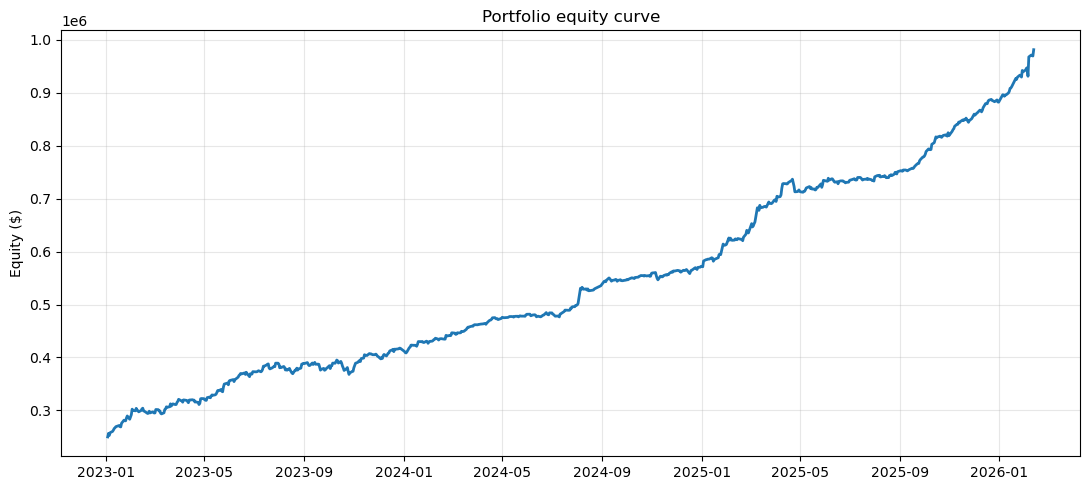

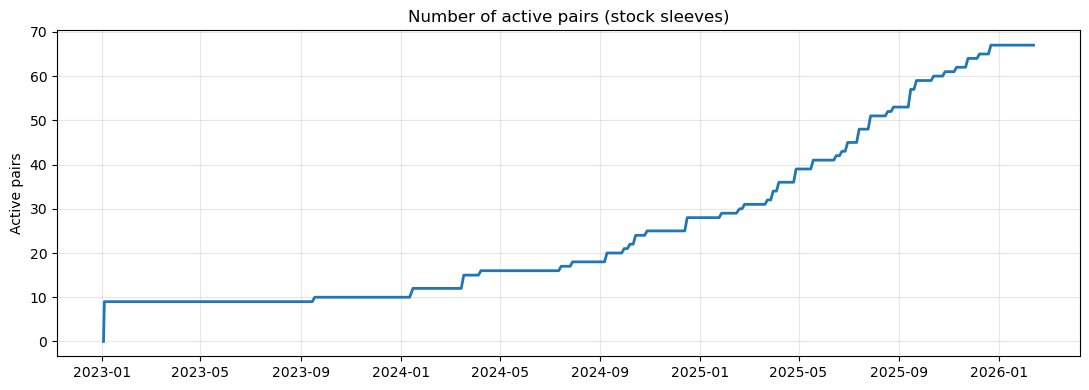

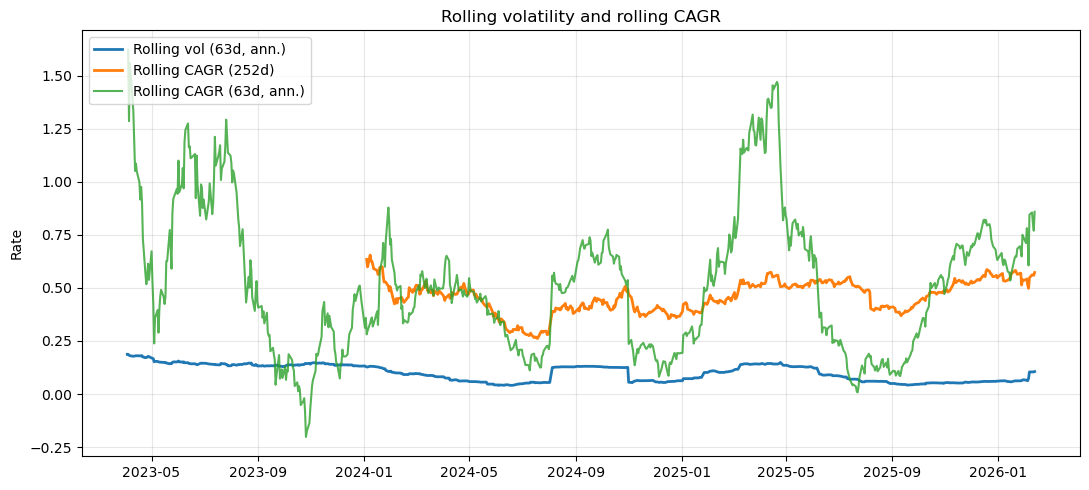

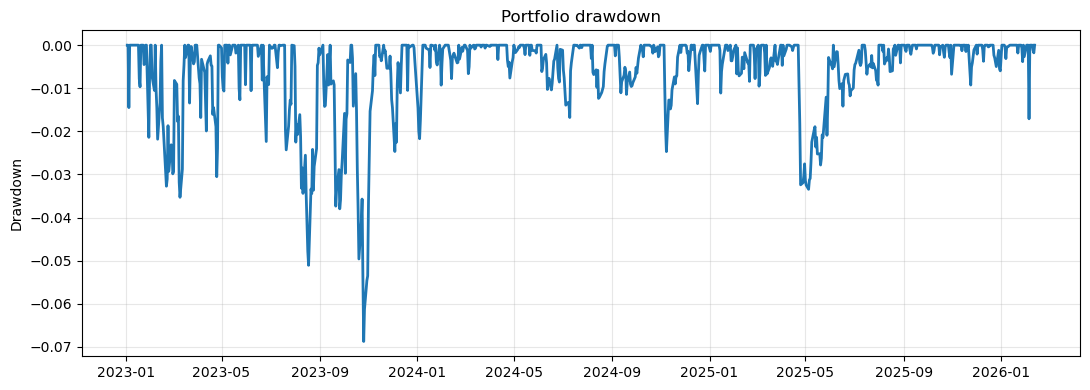

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# --- Series
ret   = out["returns"].copy()
eq    = out["equity_curve"].copy()
dd    = out["drawdown"].copy()
ap    = out.get("active_pairs", None)   # requires patch above

# Align
idx = eq.index
ret = ret.reindex(idx).fillna(0.0)
dd  = dd.reindex(idx).fillna(0.0)
if ap is not None:
    ap = ap.reindex(idx).fillna(method="ffill").fillna(0.0)

# --- Rolling metrics
# 3m rolling vol (63d) annualized
roll_vol_63 = ret.rolling(63).std(ddof=0) * np.sqrt(TRADING_DAYS)

# 12m rolling CAGR (252d) from equity curve
# CAGR(t) = (eq_t / eq_{t-252})^(252/252) - 1 = eq_t/eq_{t-252} - 1
roll_cagr_252 = (eq / eq.shift(TRADING_DAYS)) - 1.0

# (Optional) 3m rolling CAGR annualized from 63d window:
roll_cagr_63_ann = (eq / eq.shift(63))**(TRADING_DAYS/63) - 1.0

# -----------------------------
# Plot 1: Equity curve
# -----------------------------
plt.figure(figsize=(11,5))
plt.plot(eq.index, eq.values, linewidth=2.0)
plt.title("Portfolio equity curve")
plt.ylabel("Equity ($)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: Active pairs over time
# -----------------------------
if ap is not None:
    plt.figure(figsize=(11,4))
    plt.plot(ap.index, ap.values, linewidth=2.0)
    plt.title("Number of active pairs (stock sleeves)")
    plt.ylabel("Active pairs")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("out['active_pairs'] not found. Add the small patch to simulate_portfolio_from_config to track it.")

# -----------------------------
# Plot 3: Rolling vol + rolling CAGR
# -----------------------------
plt.figure(figsize=(11,5))
plt.plot(roll_vol_63.index, roll_vol_63.values, linewidth=2.0, label="Rolling vol (63d, ann.)")
plt.plot(roll_cagr_252.index, roll_cagr_252.values, linewidth=2.0, label="Rolling CAGR (252d)")
plt.plot(roll_cagr_63_ann.index, roll_cagr_63_ann.values, linewidth=1.5, alpha=0.8, label="Rolling CAGR (63d, ann.)")
plt.title("Rolling volatility and rolling CAGR")
plt.ylabel("Rate")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 4: Drawdown
# -----------------------------
plt.figure(figsize=(11,4))
plt.plot(dd.index, dd.values, linewidth=2.0)
plt.title("Portfolio drawdown")
plt.ylabel("Drawdown")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [93]:
# ============================================================
# PAIRWISE ANALYSIS (each ETF vs its underlying)
# - For EACH (ETF, Underlying) row:
#     * Long Underlying $ = equity (1.0x)
#     * Short ETF $       = equity / |Beta_used|
#     * Rebalance WEEKLY (fixed shares between rebalances)
#     * Charge borrow DAILY on prior-day short notional
# - DO NOT EXCLUDE any pairs
# - Save per-pair:
#     Return_total, CAGR, AnnVol, MaxDD, n_days, Beta_used, Borrow_annual
# - Plot bar chart sorted high -> low by CAGR
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05

def _safe_float(x):
    try:
        v = float(x)
        return v if np.isfinite(v) else np.nan
    except Exception:
        return np.nan

def choose_beta_used(row, beta_floor: float = 0.25) -> float:
    """
    Use Beta if finite and >= beta_floor in abs.
    Else fallback to Leverage (if present), else 1.0.
    """
    b = _safe_float(row.get("Beta", np.nan))
    if np.isfinite(b) and abs(b) >= beta_floor:
        return float(b)

    lev = _safe_float(row.get("Leverage", np.nan))
    if np.isfinite(lev) and lev > 0:
        return float(lev)

    return 1.0

def get_borrow_annual(etf: str) -> float:
    # Uses your existing borrow_map if present
    if "borrow_map" in globals() and borrow_map is not None:
        if etf in borrow_map:
            return float(borrow_map[etf])
        if "default" in borrow_map:
            return float(borrow_map["default"])
    return float(DEFAULT_BORROW_ANNUAL)

def perf_stats_from_daily_returns(ret: pd.Series):
    ret = ret.dropna()
    n = len(ret)
    if n == 0:
        return dict(CAGR=np.nan, AnnVol=np.nan, MaxDD=np.nan, TotalReturn=np.nan, TradingDays=0)

    curve = (1 + ret).cumprod()
    total = float(curve.iloc[-1] - 1.0)
    cagr = float(curve.iloc[-1] ** (TRADING_DAYS / n) - 1.0)
    vol = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    maxdd = float((curve / curve.cummax() - 1.0).min())
    return dict(CAGR=cagr, AnnVol=vol, MaxDD=maxdd, TotalReturn=total, TradingDays=n)

def simulate_pair_weekly_beta_hedged(
    tr_prices: pd.DataFrame,
    underlying: str,
    etf: str,
    beta_used: float,
    borrow_annual: float,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    initial_equity: float = 1.0,
) -> pd.Series:
    """
    Returns daily portfolio return series for ONE pair.
    """
    und = str(underlying).upper().replace(".", "-")
    e   = str(etf).upper().replace(".", "-")

    und_col = f"{und}_TR"
    etf_col = f"{e}_TR"

    if und_col not in tr_prices.columns or etf_col not in tr_prices.columns:
        return pd.Series(dtype=float)

    px = tr_prices[[und_col, etf_col]].copy()
    px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna(how="all")
    if px.empty:
        return pd.Series(dtype=float)

    # need overlapping history
    px = px.dropna(how="any")
    if len(px) < 5:
        return pd.Series(dtype=float)

    # rebalance calendar
    rebal_days = get_rebalance_days(px.index, freq)

    equity = float(initial_equity)
    sh_und = 0.0
    sh_etf = 0.0

    b_used = max(abs(float(beta_used)), beta_floor)
    bday = float(borrow_annual) / TRADING_DAYS

    ret = pd.Series(index=px.index, dtype=float)
    prev_t = None

    for t in px.index:
        # rebalance weekly: set notionals based on current equity
        if t in rebal_days or prev_t is None:
            pu = float(px.at[t, und_col])
            pe = float(px.at[t, etf_col])
            if not (np.isfinite(pu) and pu > 0 and np.isfinite(pe) and pe > 0):
                ret.at[t] = 0.0
                prev_t = t
                continue

            long_u_dol  = equity
            short_e_dol = equity / b_used

            sh_und = long_u_dol / pu
            sh_etf = -short_e_dol / pe  # negative shares = short

        if prev_t is None:
            ret.at[t] = 0.0
            prev_t = t
            continue

        # daily pnl
        pu0 = float(px.at[prev_t, und_col]); pu1 = float(px.at[t, und_col])
        pe0 = float(px.at[prev_t, etf_col]); pe1 = float(px.at[t, etf_col])

        pnl = 0.0
        if np.isfinite(pu0) and np.isfinite(pu1):
            pnl += sh_und * (pu1 - pu0)
        if np.isfinite(pe0) and np.isfinite(pe1):
            pnl += sh_etf * (pe1 - pe0)

        # borrow on prior-day short notional
        if np.isfinite(pe0):
            borrow_cost = abs(sh_etf) * pe0 * bday
        else:
            borrow_cost = 0.0

        pnl -= borrow_cost

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        ret.at[t] = r
        prev_t = t

    return ret.dropna()


def run_pairwise_analysis_and_plot(
    tr_prices: pd.DataFrame,
    pairs_df: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    output_csv: str = "pairwise_weekly_beta_hedged_results.csv",
):
    rows = []

    for _, row in pairs_df.iterrows():
        etf = str(row["ETF"]).upper().replace(".", "-")
        und = str(row["Underlying"]).upper().replace(".", "-")

        beta_used = choose_beta_used(row, beta_floor=beta_floor)
        borrow_ann = get_borrow_annual(etf)

        r = simulate_pair_weekly_beta_hedged(
            tr_prices=tr_prices,
            underlying=und,
            etf=etf,
            beta_used=beta_used,
            borrow_annual=borrow_ann,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            initial_equity=1.0,
        )

        stats = perf_stats_from_daily_returns(r)

        rows.append({
            "ETF": etf,
            "Underlying": und,
            "Beta_used": float(beta_used),
            "Borrow_annual": float(borrow_ann),
            "TradingDays": int(stats["TradingDays"]),
            "TotalReturn": float(stats["TotalReturn"]) if np.isfinite(stats["TotalReturn"]) else np.nan,
            "CAGR": float(stats["CAGR"]) if np.isfinite(stats["CAGR"]) else np.nan,
            "AnnVol": float(stats["AnnVol"]) if np.isfinite(stats["AnnVol"]) else np.nan,
            "MaxDD": float(stats["MaxDD"]) if np.isfinite(stats["MaxDD"]) else np.nan,
        })

    res = pd.DataFrame(rows)

    # Save
    res.to_csv(output_csv, index=False)
    print(f"Saved: {output_csv} | rows={len(res)}")

    # Sort by CAGR (highest -> lowest)
    plot_df = res.dropna(subset=["CAGR"]).sort_values("CAGR", ascending=False).reset_index(drop=True)

    # Bar chart
    plt.figure(figsize=(14, 6))
    x = np.arange(len(plot_df))
    plt.bar(x, plot_df["CAGR"].values)
    plt.xticks(x, [f"{a}/{b}" for a, b in zip(plot_df["ETF"], plot_df["Underlying"])],
               rotation=90, ha="center")
    plt.title(f"Pairwise Weekly Beta-Hedged Returns (sorted) | start={backtest_start}")
    plt.ylabel("CAGR")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

    return res


In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# -----------------------------
# Extra stats (adds Sortino etc.)
# -----------------------------
def perf_stats_extended(ret: pd.Series, mar_annual: float = 0.0) -> dict:
    """
    ret: daily return series
    mar_annual: minimum acceptable return (annual). Convert to daily for Sortino downside.
    """
    ret = ret.dropna()
    n = len(ret)
    if n == 0:
        return dict(
            TradingDays=0, TotalReturn=np.nan, CAGR=np.nan, AnnVol=np.nan, MaxDD=np.nan,
            Sharpe=np.nan, Sortino=np.nan, Calmar=np.nan,
            BestDay=np.nan, WorstDay=np.nan, PctPos=np.nan
        )

    curve = (1.0 + ret).cumprod()
    total = float(curve.iloc[-1] - 1.0)
    cagr  = float(curve.iloc[-1] ** (TRADING_DAYS / n) - 1.0)
    vol   = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    dd    = curve / curve.cummax() - 1.0
    maxdd = float(dd.min())

    # Sharpe (assume rf=0 for now; you can plug daily rf if desired)
    mu_ann = float(ret.mean() * TRADING_DAYS)
    sharpe = float(mu_ann / vol) if vol > 0 else np.nan

    # Sortino
    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0
    downside = ret[ret < mar_daily] - mar_daily
    down_vol = float(np.sqrt((downside**2).mean()) * np.sqrt(TRADING_DAYS)) if len(downside) else 0.0
    sortino  = float(mu_ann / down_vol) if down_vol > 0 else np.nan

    calmar = float(cagr / abs(maxdd)) if maxdd < 0 else np.nan

    return dict(
        TradingDays=int(n),
        TotalReturn=total,
        CAGR=cagr,
        AnnVol=vol,
        MaxDD=maxdd,
        Sharpe=sharpe,
        Sortino=sortino,
        Calmar=calmar,
        BestDay=float(ret.max()),
        WorstDay=float(ret.min()),
        PctPos=float((ret > 0).mean()),
    )

# -----------------------------
# Plot one pair report
# -----------------------------
def plot_pair_report(
    *,
    tr_prices: pd.DataFrame,
    etf: str,
    underlying: str,
    beta_used: float,
    borrow_annual: float,
    backtest_start: str,
    freq: str,
    beta_floor: float,
    outpath: str | None = None,
    mar_annual: float = 0.0,
):
    und = str(underlying).upper().replace(".", "-")
    e   = str(etf).upper().replace(".", "-")
    und_col = f"{und}_TR"
    etf_col = f"{e}_TR"

    # Portfolio returns
    r = simulate_pair_weekly_beta_hedged(
        tr_prices=tr_prices,
        underlying=und,
        etf=e,
        beta_used=beta_used,
        borrow_annual=borrow_annual,
        backtest_start=backtest_start,
        freq=freq,
        beta_floor=beta_floor,
        initial_equity=1.0,
    )
    if r.empty:
        return None

    stats = perf_stats_extended(r, mar_annual=mar_annual)
    curve = (1 + r).cumprod()
    dd = curve / curve.cummax() - 1.0

    # Price panel (normalize to 100 at start)
    px = tr_prices[[und_col, etf_col]].copy()
    px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna()
    px = px.loc[px.index.isin(r.index)]  # align to portfolio dates
    if px.empty:
        return None
    px_norm = 100.0 * px / px.iloc[0]

    # Stats box
    stat_lines = [
        f"CAGR: {stats['CAGR']:.2%}",
        f"AnnVol: {stats['AnnVol']:.2%}",
        f"MaxDD: {stats['MaxDD']:.2%}",
        f"Sharpe: {stats['Sharpe']:.2f}",
        f"Sortino: {stats['Sortino']:.2f}",
        f"Calmar: {stats['Calmar']:.2f}",
        f"% Pos Days: {stats['PctPos']:.1%}",
        f"Best/Worst Day: {stats['BestDay']:.2%} / {stats['WorstDay']:.2%}",
        f"N days: {stats['TradingDays']}",
    ]
    return stats

# -----------------------------
# Generate reports for Top 25
# -----------------------------
def analyze_top25_pairs(
    *,
    tr_prices: pd.DataFrame,
    pairs_df: pd.DataFrame,
    pairwise_results: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    top_n: int = 75,
    outdir: str = "pair_reports_top25",
    mar_annual: float = 0.0,
):
    top = (
        pairwise_results.dropna(subset=["CAGR"])
        .sort_values("CAGR", ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    out_rows = []
    for i, row in top.iterrows():
        etf = row["ETF"]
        und = row["Underlying"]

        # Get the original pair row so we match your beta selection logic (optional),
        # but we already have Beta_used + Borrow_annual in results, so use those.
        beta_used = float(row["Beta_used"])
        borrow_ann = float(row["Borrow_annual"])

        fname = f"{i+1:02d}_{etf}_vs_{und}.png"
        outpath = os.path.join(outdir, fname)

        stats = plot_pair_report(
            tr_prices=tr_prices,
            etf=etf,
            underlying=und,
            beta_used=beta_used,
            borrow_annual=borrow_ann,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            outpath=outpath,
            mar_annual=mar_annual,
        )
        if stats is None:
            continue
        if beta_used < 1.5:
            out_rows.append({
                "Rank": i+1,
                "ETF": etf,
                "Underlying": und,
                "Beta_used": beta_used,
                "Borrow_annual": borrow_ann,
                **stats
            })

    summary = pd.DataFrame(out_rows).sort_values("Rank")

    # optional: format borrow as percent for readability
    summary["Borrow_annual"] = summary["Borrow_annual"].astype(float)

    display(
        summary[[
            "Rank","ETF","Underlying","Beta_used","Borrow_annual",
            "CAGR","AnnVol","MaxDD","Sharpe","Sortino","Calmar",
            "PctPos","BestDay","WorstDay","TradingDays"
        ]].head(50)
    )
    return summary


# RUN
top25_summary = analyze_top25_pairs(
    tr_prices=prices,
    pairs_df=pairs_ok,
    pairwise_results=pairwise_results,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    top_n=100,
    outdir="pair_reports_top25",
    mar_annual=0.0,   # set to 0.05 if you want Sortino vs +5% hurdle
)


Rank   ETF Underlying  Beta_used  Borrow_annual       CAGR    AnnVol  \
0      1  MTYY       MSTR   0.381740       0.088768  31.270142  0.602610   
1      2   QBY       QBTS   0.277569       0.334608  30.242998  0.900106   
2      3  RGYY       RGTI   0.311495       0.050000   7.719314  0.842363   
3      4  MAAY       MARA   0.325114       0.118108   6.263336  0.554569   
4      7  COYY       COIN   0.538204       0.159928   1.246642  0.366972   
5      8  FBYY       META   0.585607       0.053158   1.140141  0.260852   
6      9  HOYY       HOOD   0.517759       0.256128   0.923416  0.435260   
7     18  SMYY       SMCI   0.432251       0.170632   0.462352  0.478036   
8     21  XBTY       IBIT   0.553822       0.000000   0.385038  0.315055   
9     25  IOYY       IONQ   0.402198       0.164114   0.348925  0.464966   
10    28  GMEY        GME   0.630216       0.050000   0.314485  0.203841   
11    40  AIYY         AI   0.717918       0.128934   0.205239  0.209288   
12    43  MARO       MARA   0.785206       0.005060   0.194753  0.179149   
13    55  PLTY       PLTR   0.794762       0.050000   0.165744  0.130318   
14    60  SMCY       SMCI   0.743427       0.130638   0.150015  0.209523   
15    64  TQQY        QQQ   0.853020       0.077514   0.145701  0.188399   
16    65  HOOY       HOOD   0.791190       0.050000   0.144312  0.134618   
17    75  AZYY       AMZN   0.621561       0.090902   0.133578  0.203466   
18    82  TSYY       TSLA   0.538119       0.066746   0.121449  0.438696   
19    84  RDYY       RDDT   0.836831       0.025192   0.119819  0.154248   

       MaxDD    Sharpe   Sortino      Calmar    PctPos   BestDay  WorstDay  \
0  -0.155771  6.098870  7.454489  200.743856  0.663265  0.132922 -0.088205   
1  -0.120998  4.272635  6.885748  249.945798  0.540000  0.209142 -0.077668   
2  -0.249688  2.993808  3.625338   30.915891  0.509434  0.213834 -0.149868   
3  -0.184511  3.865734  4.400485   33.945517  0.544118  0.089466 -0.095994   
4  -0.134790  2.389295  3.095882    9.248763  0.503650  0.117097 -0.070388   
5  -0.058284  3.049943  4.048017   19.561732  0.532468  0.070759 -0.032079   
6  -0.111163  1.717152  2.464983    8.306829  0.451613  0.093500 -0.046856   
7  -0.164857  1.034174  1.124615    2.804554  0.473118  0.121811 -0.107696   
8  -0.199980  1.190807  1.446463    1.925385  0.449735  0.086718 -0.070484   
9  -0.217531  0.876086  0.988419    1.604025  0.455882  0.074602 -0.091141   
10 -0.060633  1.443626  1.599068    5.186718  0.527778  0.064416 -0.058696   
11 -0.111803  0.994347  1.527755    1.835727  0.419530  0.132273 -0.049208   
12 -0.125817  1.083031  1.200854    1.547906  0.488055  0.037024 -0.045268   
13 -0.064306  1.241705  1.766313    2.577447  0.439169  0.045449 -0.021711   
14 -0.126166  0.770248  1.067871    1.189023  0.430986  0.092566 -0.040277   
15 -0.130890  0.815087  1.119497    1.113153  0.425620  0.073920 -0.045044   
16 -0.044539  1.068776  1.250260    3.240103  0.463542  0.030035 -0.026683   
17 -0.099301  0.717602  0.861270    1.345187  0.427184  0.045529 -0.030421   
18 -0.353592  0.480271  0.553782    0.343472  0.435540  0.101523 -0.150423   
19 -0.066478  0.810456  0.905331    1.802391  0.509259  0.048169 -0.021923   

    TradingDays  
0            98  
1            50  
2            53  
3            68  
4           137  
5            77  
6            93  
7            93  
8           189  
9            68  
10          108  
11          553  
12          293  
13          337  
14          355  
15          242  
16          192  
17          103  
18          287  
19          108

YieldBOOST Underlying UnderlyingLeveredETF       CAGR    AnnVol     MaxDD  \
11       MTYY       MSTR                 MSTP  29.018529  0.593289 -0.152100   
14        QBY       QBTS                 QBTX  29.163777  0.890460 -0.120012   
9        MAAY       MARA                 MRAL   6.113774  0.551224 -0.182609   
10       FBYY       META                  FBL   1.138006  0.260593 -0.058341   
16       RGYY       RGTI                 RGTU   7.332890  0.832517 -0.248149   
4        COYY       COIN                 COIG   1.233090  0.365929 -0.134645   
7        HOYY       HOOD                 HOOX   0.813588  0.420603 -0.106592   
3        XBTY       IBIT                 BITU   0.388949  0.316204 -0.201043   
15       TQQY        QQQ                 TQQQ   0.145742  0.188322 -0.130767   
19       SMYY       SMCI                 SMCL   0.455515  0.476067 -0.165504   
8        IOYY       IONQ                 IONL   0.330778  0.460288 -0.214884   
1        AZYY       AMZN                 AMZZ   0.133282  0.203337 -0.099236   
21       TSYY       TSLA                 TSLR   0.121459  0.438650 -0.353573   
13       PLYY       PLTR                 PTIR   0.048318  0.267536 -0.109502   
12       NVYY       NVDA                 NVDL  -0.170378  0.205461 -0.197947   
0        AMYY        AMD                 AMDL  -0.668036  0.644847 -0.530200   
20       YSPY        SPY                  SSO  -0.242950  0.180749 -0.238931   
6        HMYY       HIMS                 HIMZ  -0.842567  0.473954 -0.301961   
18       SEMY       SOXX                 SOXL  -0.470945  0.164467 -0.175290   
2        BBYY       BABA                 BABX  -0.867505  0.237844 -0.468533   
17       RTYY       RIOT                 RIOX  -0.986994  0.503262 -0.570160   
5        NUGY        GDX                 NUGT  -0.983628  0.248996 -0.611884   

       Sharpe    Sortino  Borrow_YieldBOOST  Borrow_UnderlyingLeveredETF  \
11   6.061998   7.393634           0.088768                     0.740546   
14   4.269752   6.920456           0.334608                     0.224506   
9    3.847797   4.452459           0.118108                     0.553718   
10   3.048876   4.046756           0.053158                     0.000000   
16   2.964812   3.508220           0.050000                     0.686420   
4    2.378505   3.079662           0.159928                     0.235898   
7    1.622513   2.308615           0.256128                     0.212264   
3    1.196533   1.454769           0.000000                     0.008182   
15   0.815537   1.120050           0.077514                     0.000000   
19   1.026632   1.115855           0.170632                     0.341684   
8    0.850828   0.972726           0.164114                     0.422306   
1    0.716645   0.860119           0.090902                     0.013592   
21   0.480294   0.553809           0.066746                     0.096834   
13   0.309068   0.385185           0.082928                     0.008712   
12  -0.806368  -0.882709           0.031266                     0.059100   
0   -1.383482  -1.568673           0.218240                     0.023664   
20  -1.449360  -1.748150           0.078890                     0.000000   
6   -3.643840  -3.173825           1.789904                     0.288282   
18  -3.784444  -4.187669           0.940808                     0.000000   
2   -8.344268  -6.951629           1.257440                     0.000000   
17  -8.302447  -7.376334           2.148698                     0.386188   
5  -16.255924 -11.224323           2.235346                     0.032182   

    TradingDays  
11           98  
14           50  
9            68  
10           77  
16           53  
4           137  
7            93  
3           189  
15          242  
19           93  
8            68  
1           103  
21          287  
13           98  
12          189  
0           103  
20          216  
6            49  
18           58  
2            77  
17           49  
5            58

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


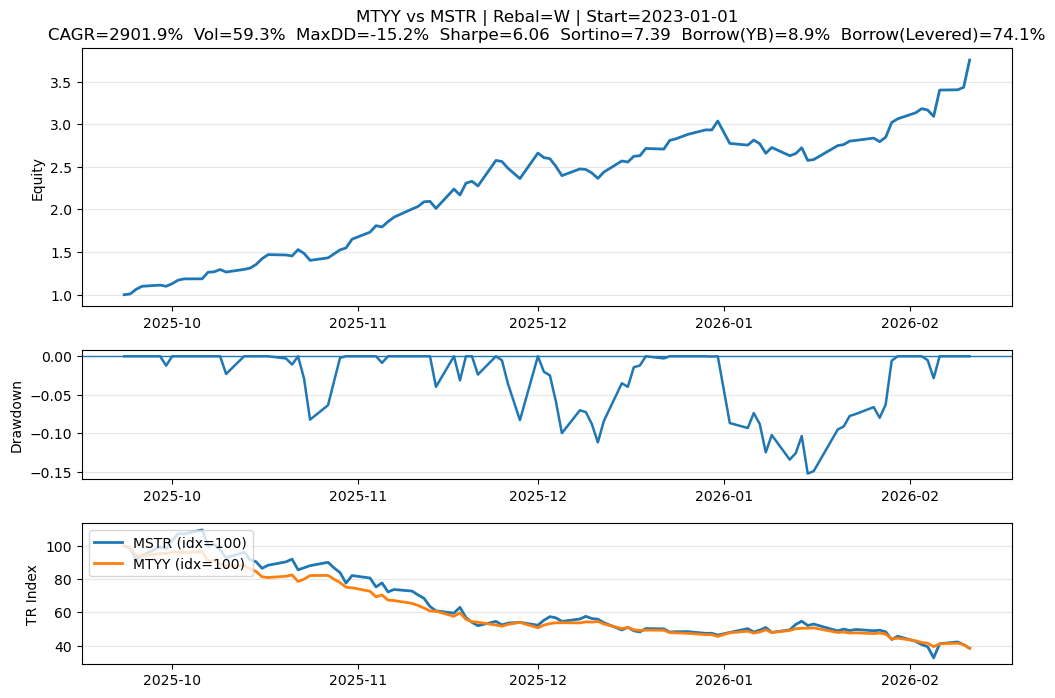

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


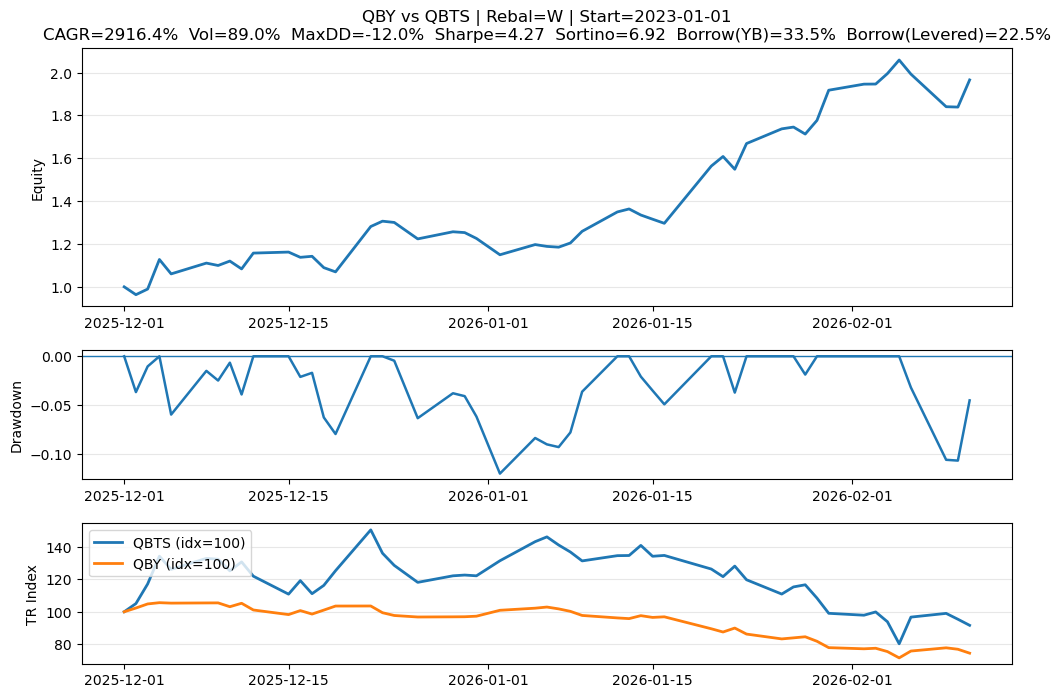

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


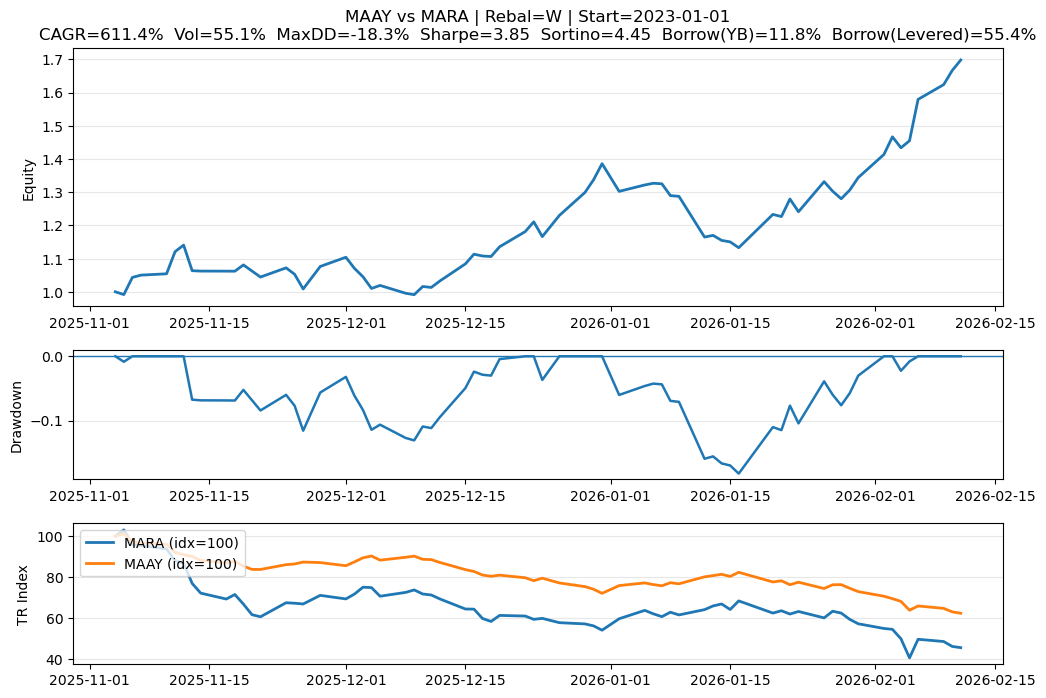

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


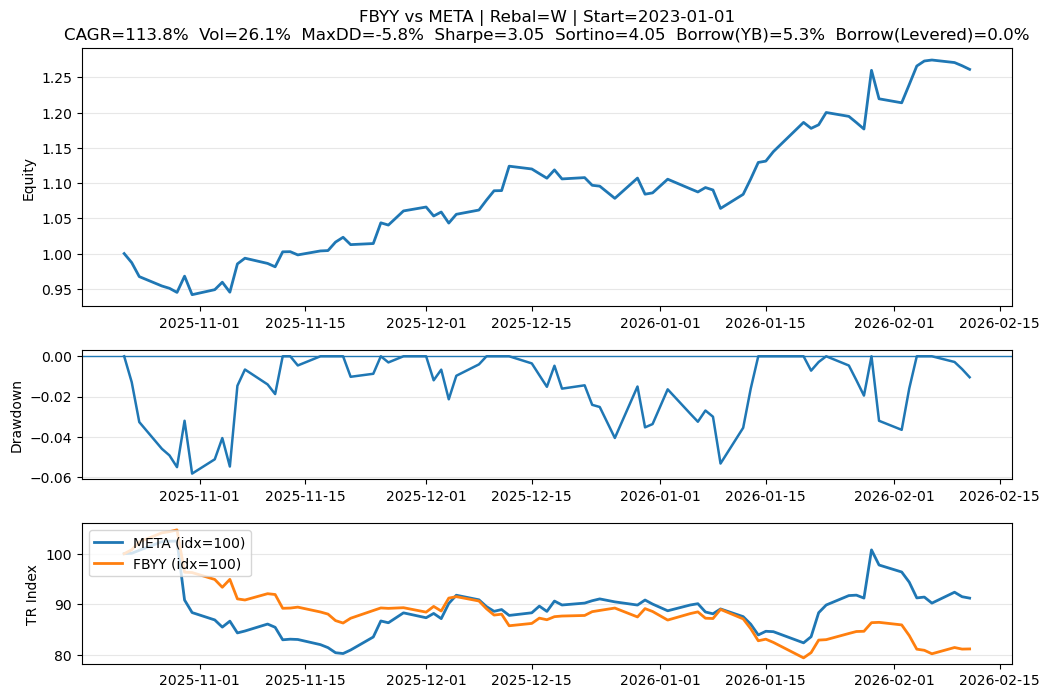

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


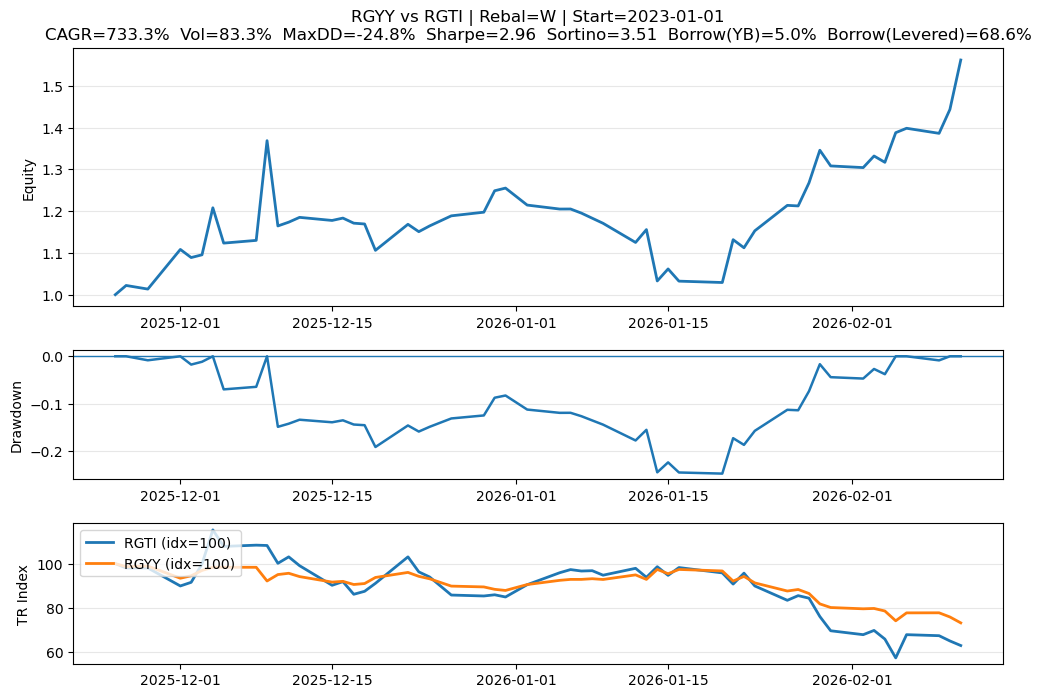

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


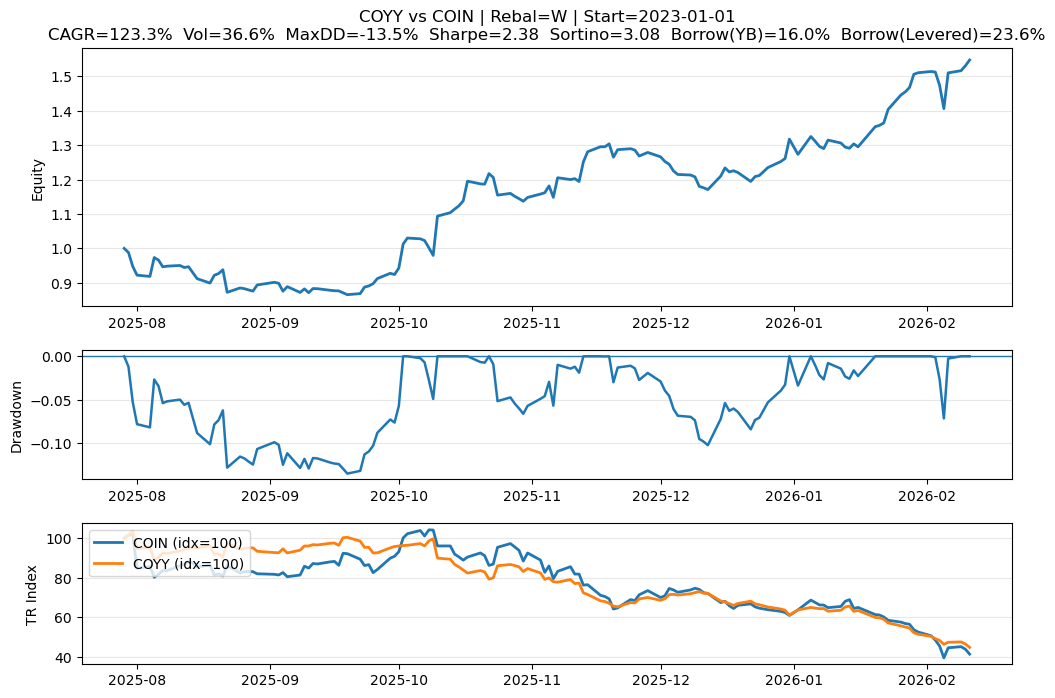

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


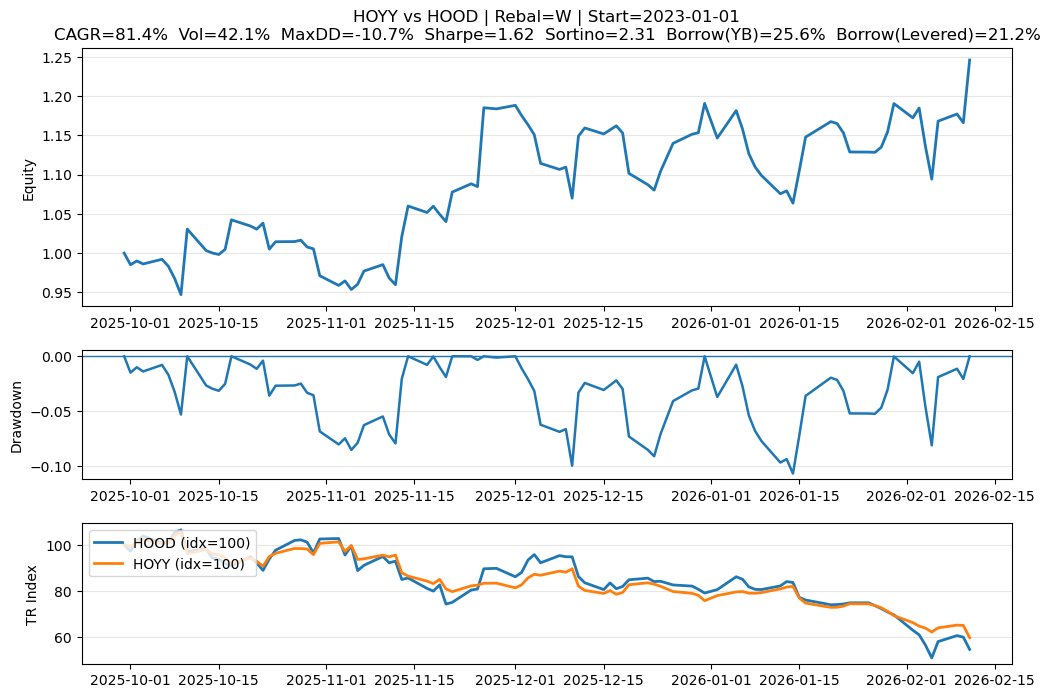

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


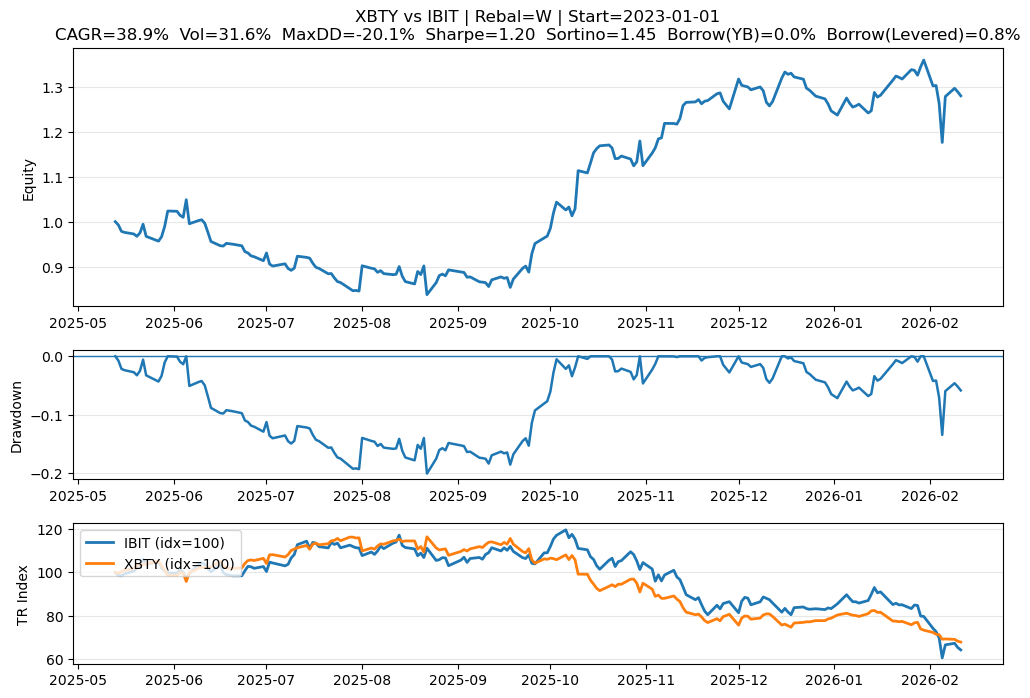

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


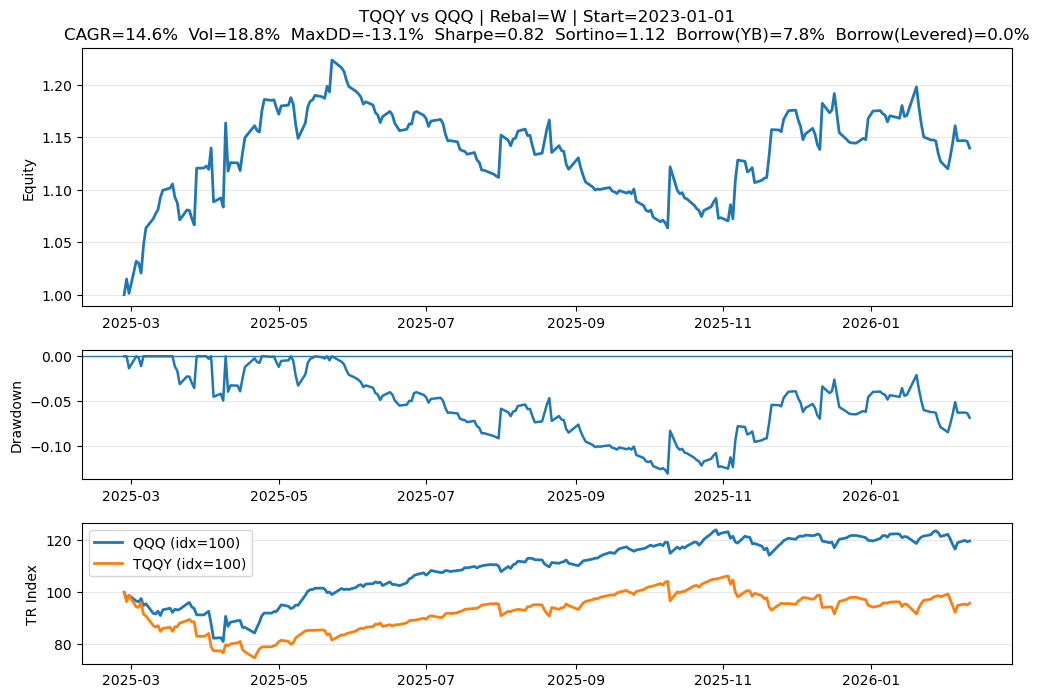

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


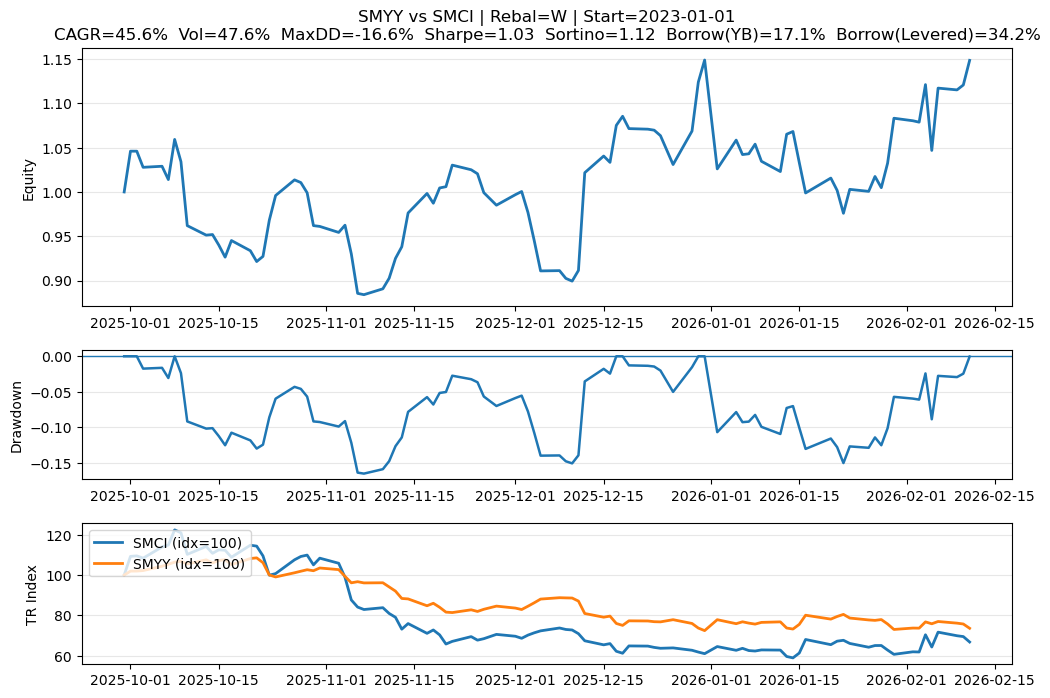

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


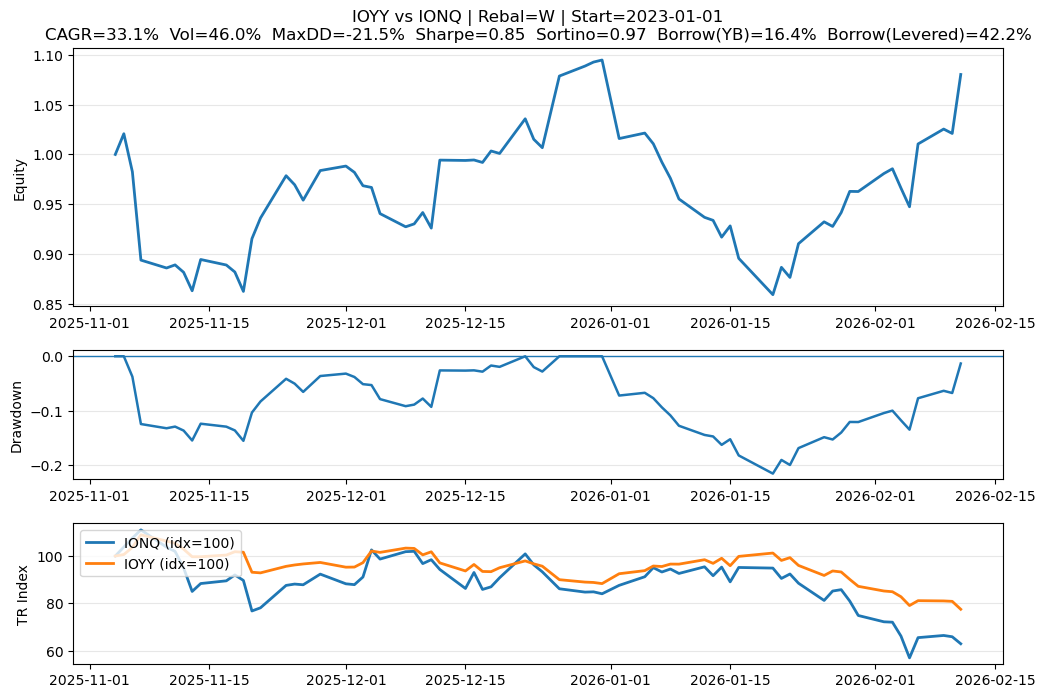

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


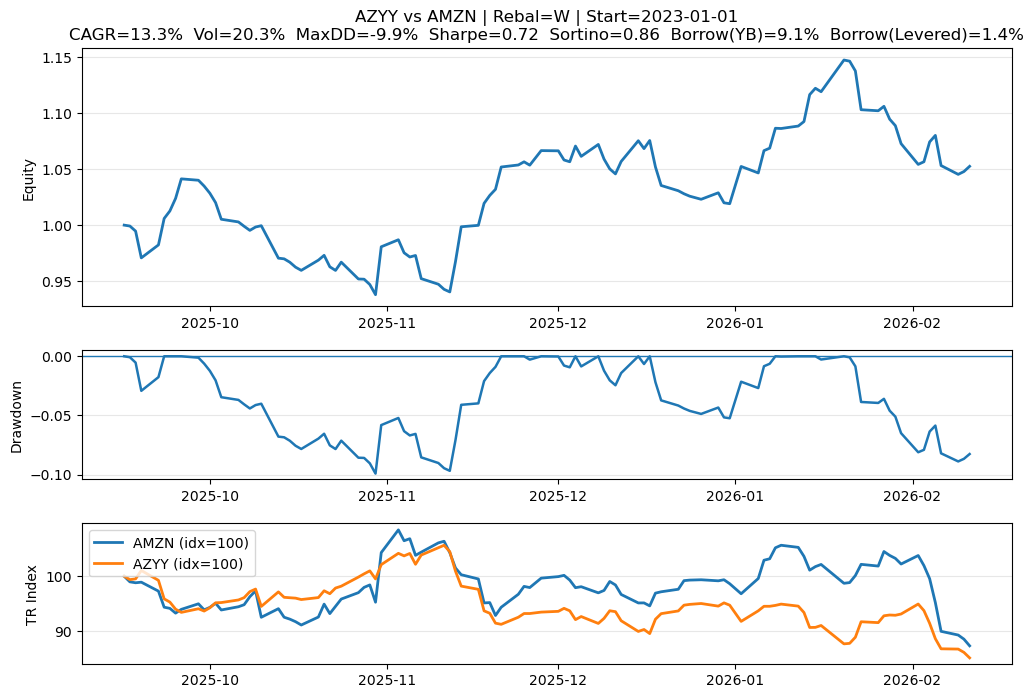

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


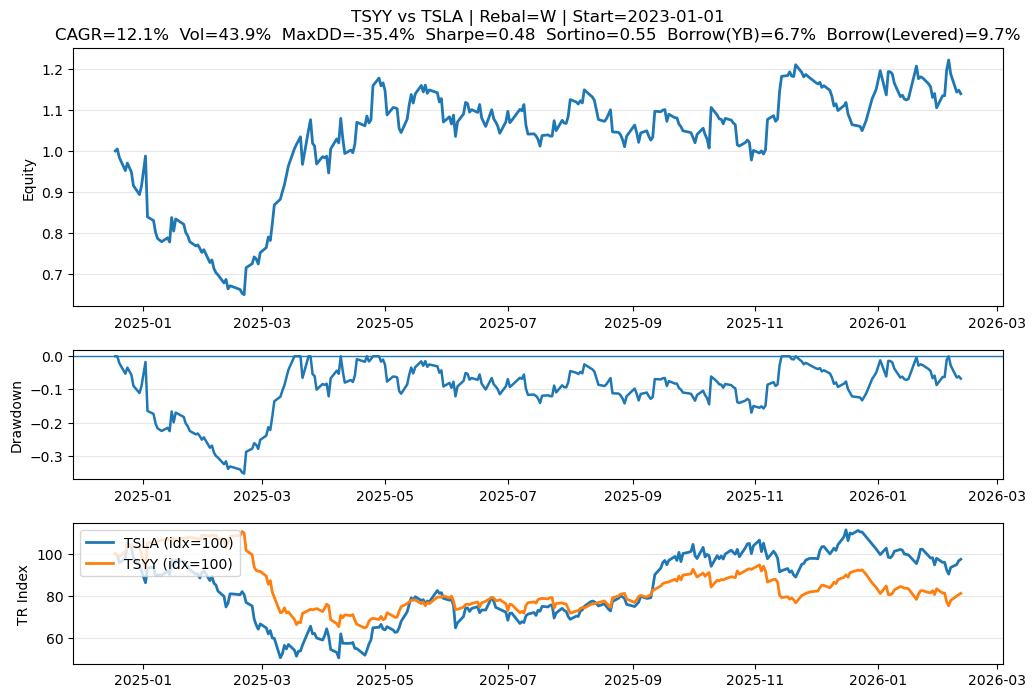

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


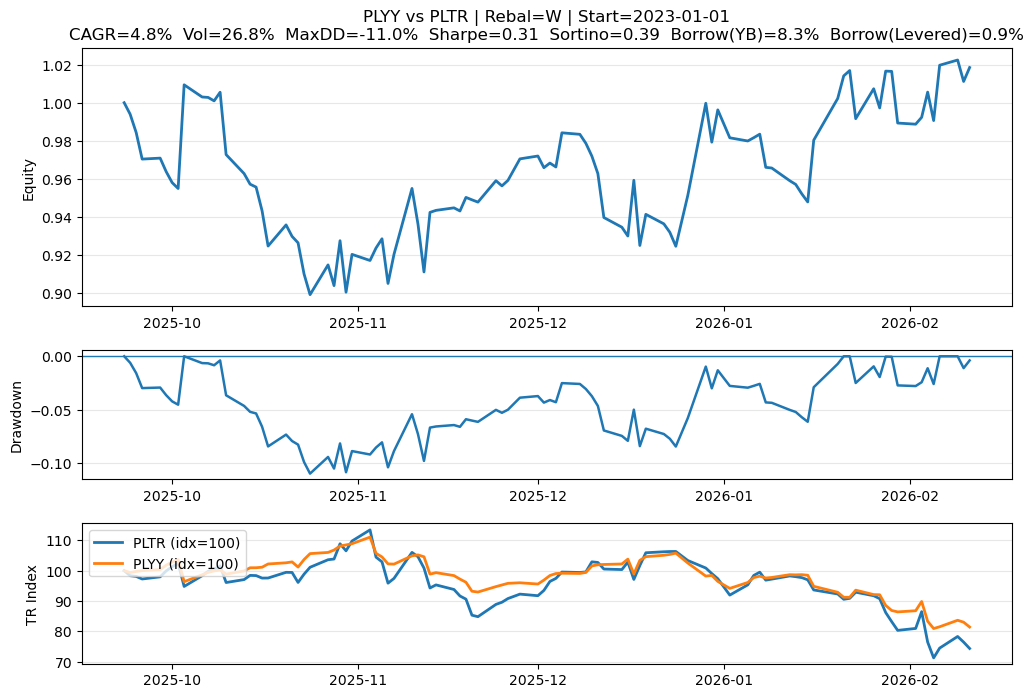

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


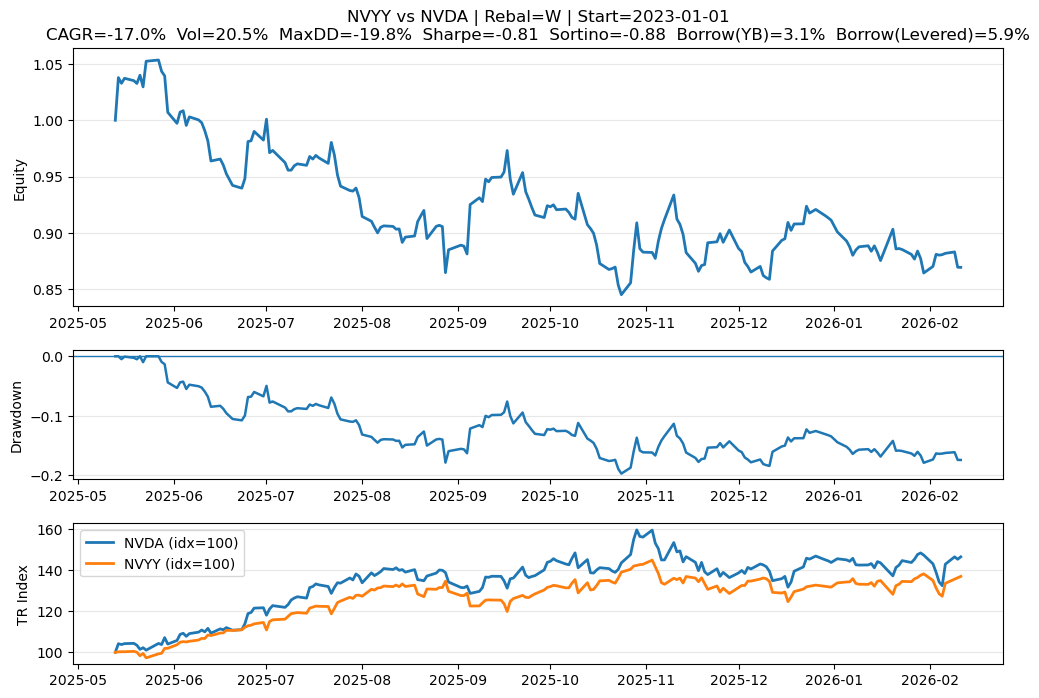

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


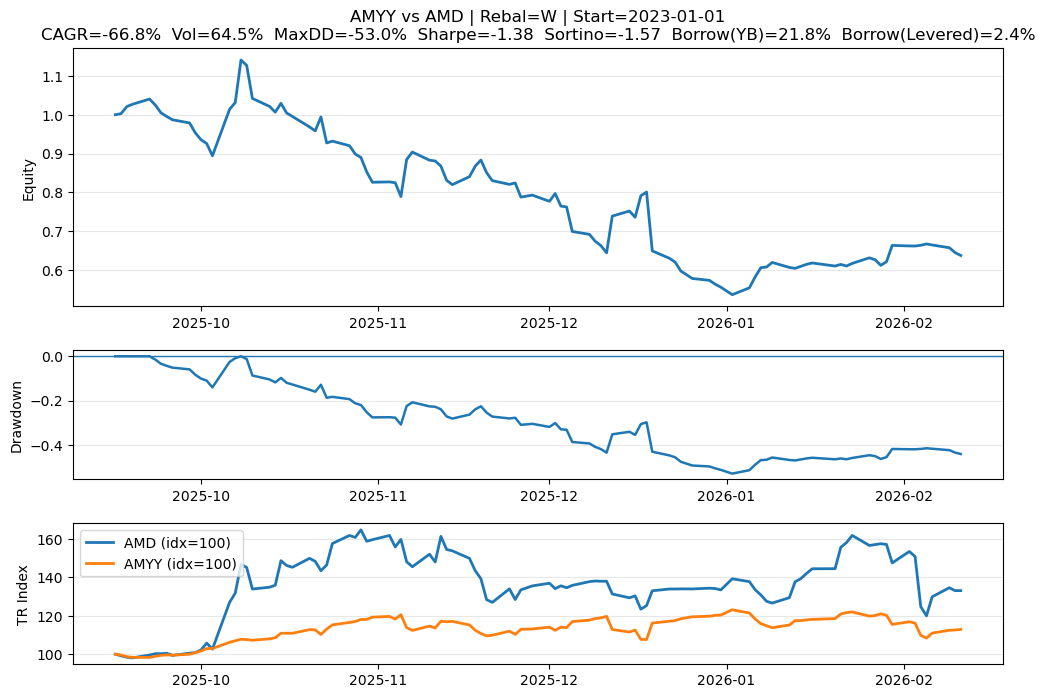

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


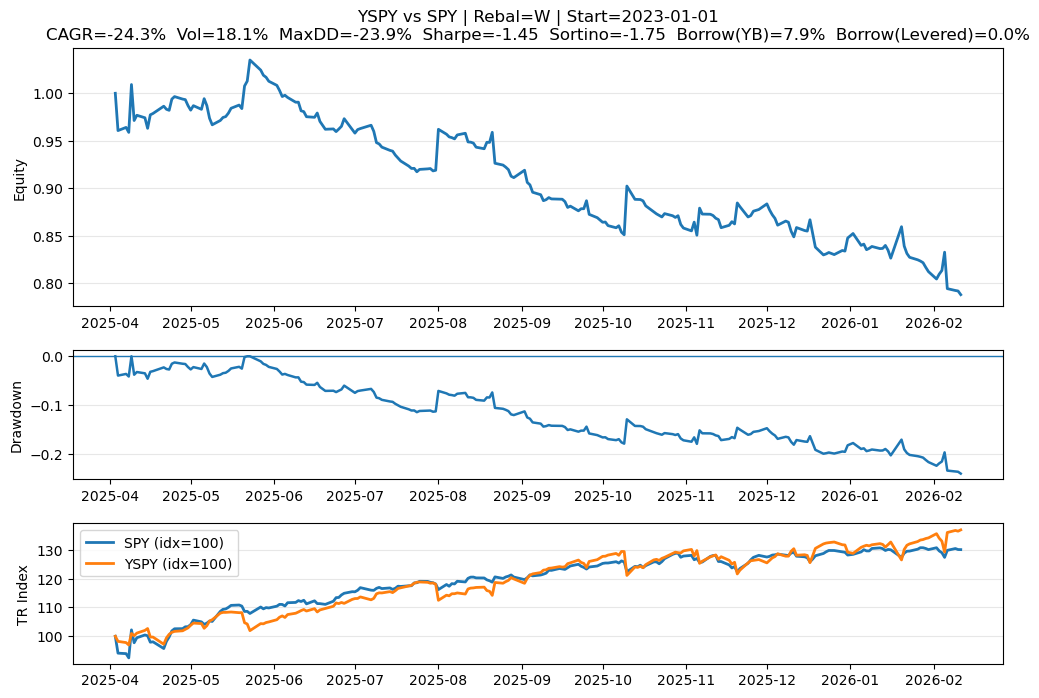

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


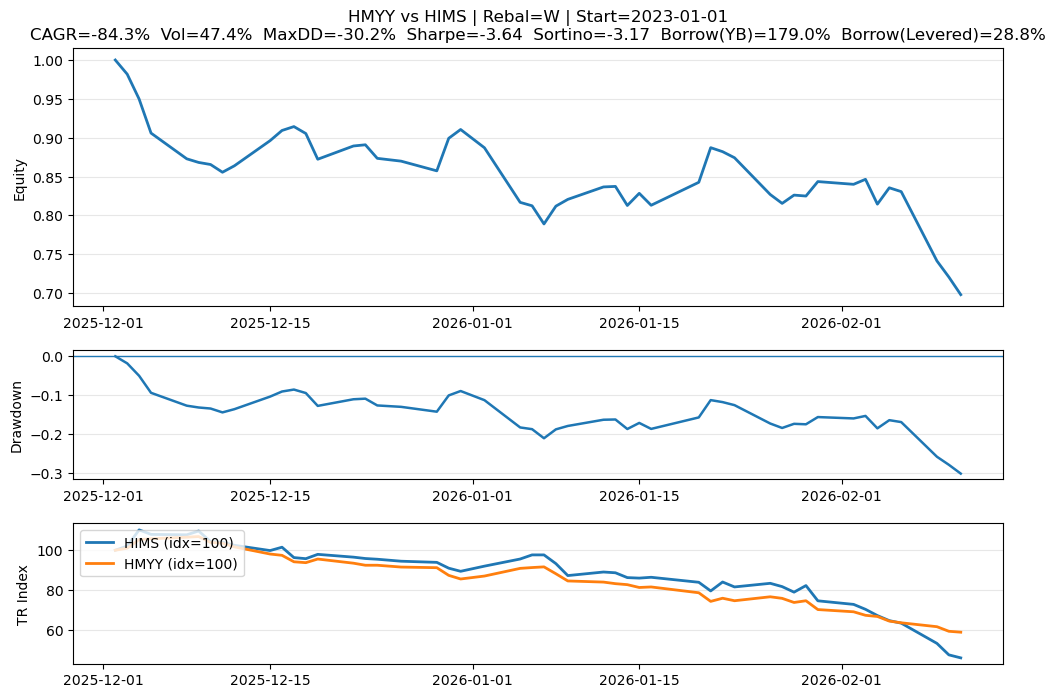

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


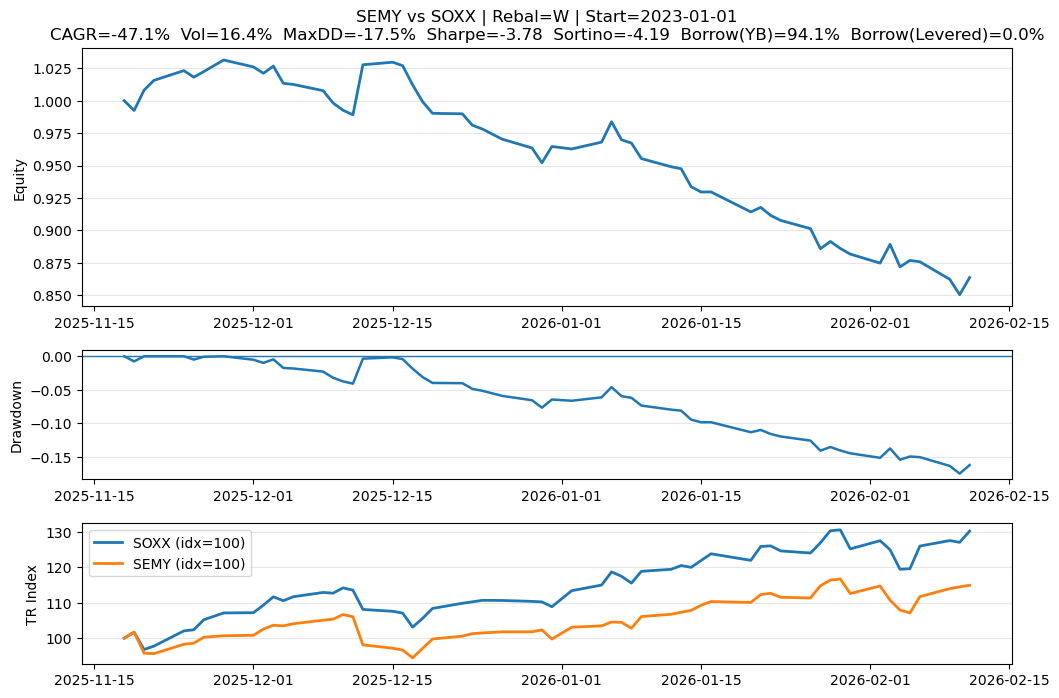

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


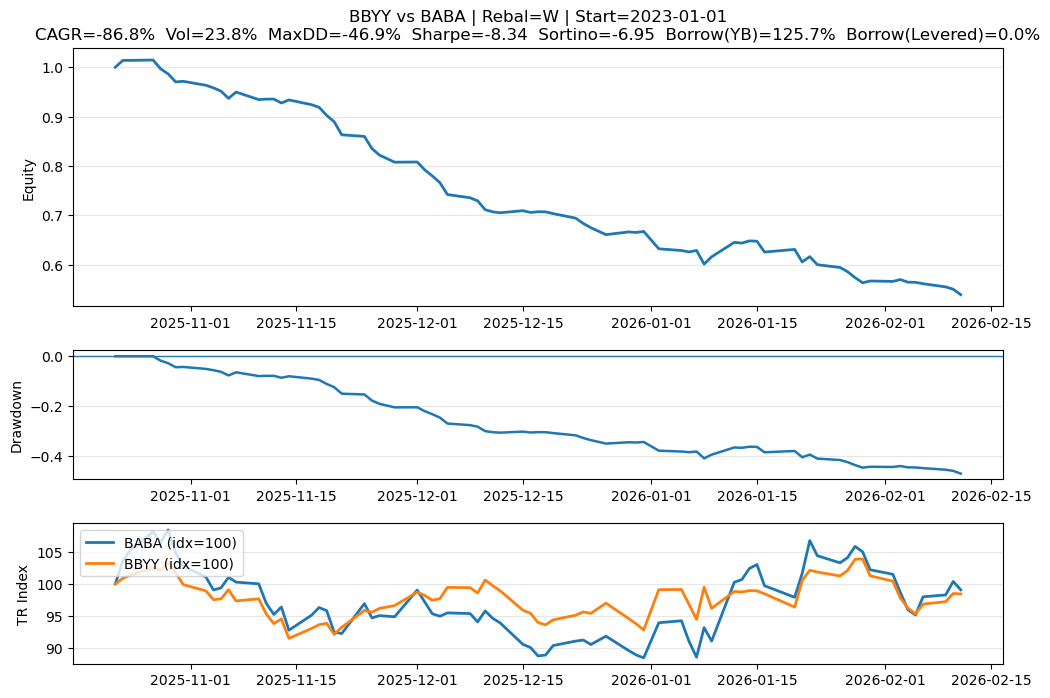

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


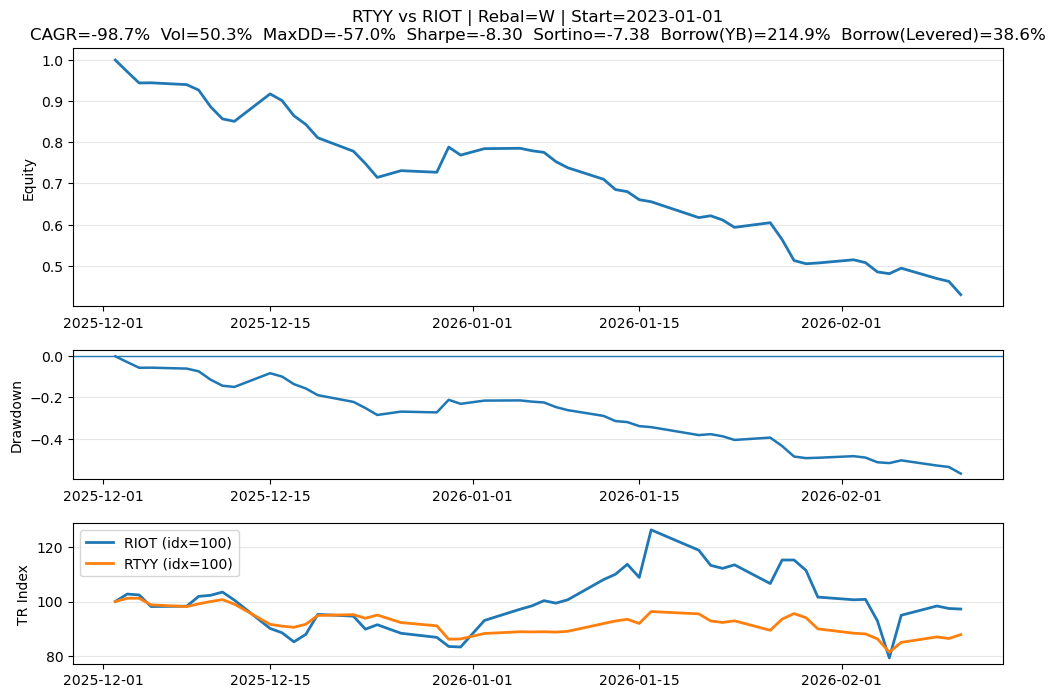

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3606453423.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


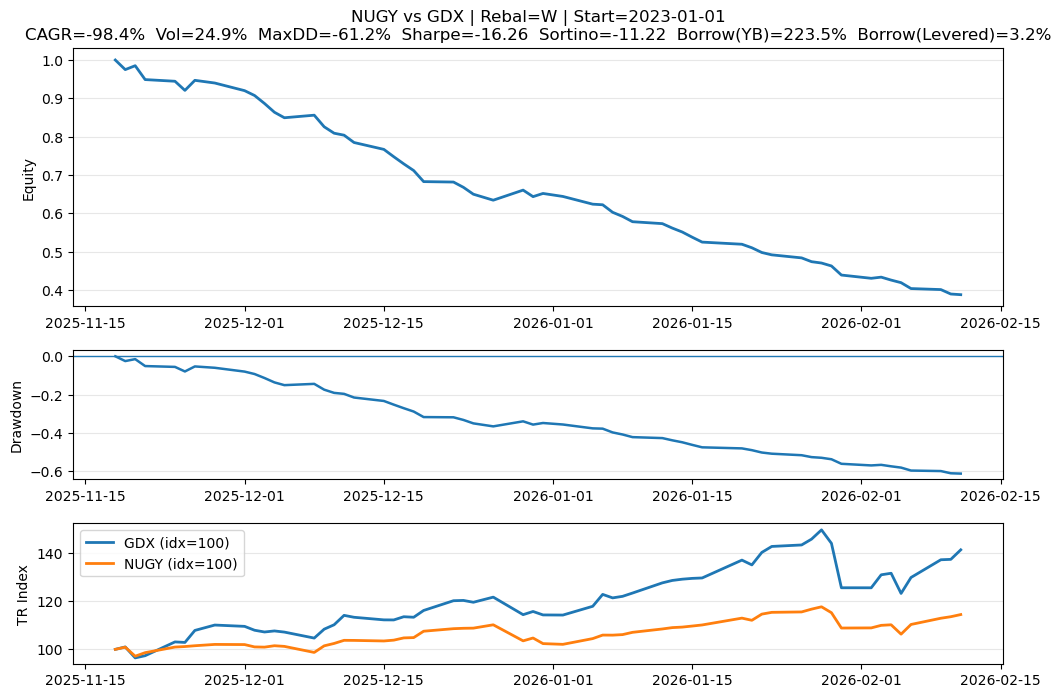

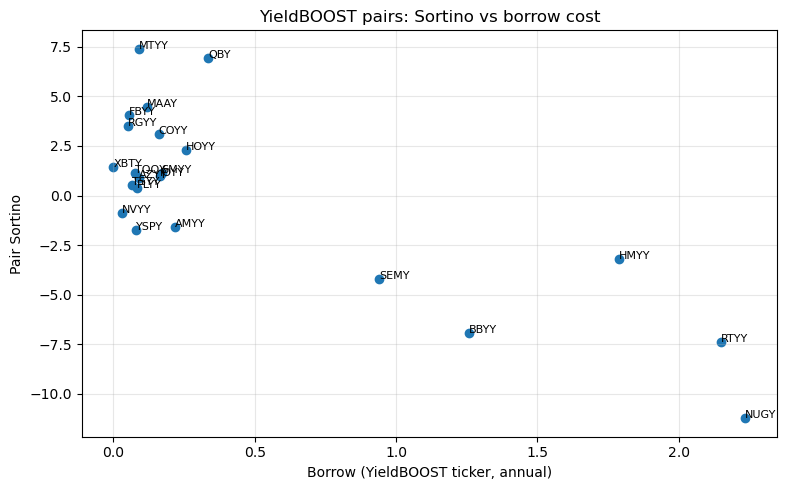

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05

# ============================================================
# YieldBOOST -> "Underlying Leveraged ETF" ticker mapping
# Notes:
# - For many GraniteShares YieldBOOST funds, the factsheets name the
#   "2x Long <STOCK> Daily ETF" but do NOT print the ticker.
# - Where GraniteShares has an obvious 2x-long ETF ticker (e.g., NVDL),
#   we map to that.
# - Where GraniteShares doesn’t have a clear in-family 2x-long ticker,
#   we map to the most common 2x product with listed options (often
#   Defiance / Tradr), but YOU SHOULD VERIFY these few.
# ============================================================
yieldboost_map = {
    # Single-stock (GraniteShares 2x-long family where known)
    "AMYY": "AMDL",   # 2x AMD (GraniteShares)
    "AZYY": "AMZZ",   # 2x AMZN (GraniteShares)
    "BBYY": "BABX",   # 2x BABA (GraniteShares)
    "FBYY": "FBL",    # 2x META (GraniteShares)
    "MAAY": "MRAL",   # 2x MARA (GraniteShares)
    "MTYY": "MSTP",   # 2x MSTR (GraniteShares)
    "NVYY": "NVDL",   # 2x NVDA (GraniteShares)
    "PLYY": "PTIR",   # 2x PLTR (GraniteShares)
    "SMYY": "SMCL",   # 2x SMCI (GraniteShares)
    "TSYY": "TSLR",   # 2x TSLA (GraniteShares)
    "IOYY": "IONL",   # 2x IONQ (GraniteShares)
    "COYY": "COIG",

    # These likely reference NON-GraniteShares 2x ETFs (verify)
    "HOYY": "HOOX",   # 2x HOOD (Defiance; verify vs HOOG/other)
    "HMYY": "HIMZ",   # 2x HIMS (Defiance; verify ticker)
    "QBY":  "QBTX",   # 2x QBTS (Tradr)
    "RGYY": "RGTU",   # 2x RGTI (Tradr; verify vs RGTX)
    "RTYY": "RIOX",   # 2x RIOT (Defiance; verify)

    # Index/crypto style (verify)
    "TQQY": "TQQQ",   # 3x QQQ (ProShares)
    "YSPY": "SSO",    # 2x SPY (ProShares Ultra S&P500)
    "XBTY": "BITU",   # 2x Bitcoin (ProShares Ultra Bitcoin) - verify vs other 2x BTC products
    "NUGY": "NUGT",   # 2x Gold Miners (Direxion) - proxy for "2x Long GDM Daily ETF"
    "SEMY": "SOXL",   # 3x Semis (Direxion) - proxy for "3x Long ICESEMI Daily ETF"
}

# ============================================================
# Borrow helper: uses borrow_map if you have it, else default
# (works for BOTH YieldBOOST tickers and the leveraged ETF tickers)
# ============================================================
def get_borrow_annual(symbol: str) -> float:
    sym = str(symbol).upper().replace(".", "-")
    if "borrow_map" in globals() and (globals().get("borrow_map") is not None):
        bm = globals()["borrow_map"]
        if sym in bm:
            return float(bm[sym])
        if "default" in bm:
            return float(bm["default"])
    return float(DEFAULT_BORROW_ANNUAL)

# ============================================================
# Perf stats (CAGR/Vol/MaxDD/Sortino)
# ============================================================
def perf_stats_extended(ret: pd.Series, mar_annual: float = 0.0) -> dict:
    ret = ret.dropna()
    n = len(ret)
    if n == 0:
        return dict(TradingDays=0, TotalReturn=np.nan, CAGR=np.nan, AnnVol=np.nan,
                    MaxDD=np.nan, Sharpe=np.nan, Sortino=np.nan, Calmar=np.nan)

    curve = (1.0 + ret).cumprod()
    total = float(curve.iloc[-1] - 1.0)
    cagr  = float(curve.iloc[-1] ** (TRADING_DAYS / n) - 1.0)
    vol   = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    dd    = curve / curve.cummax() - 1.0
    maxdd = float(dd.min())

    mu_ann = float(ret.mean() * TRADING_DAYS)
    sharpe = float(mu_ann / vol) if vol > 0 else np.nan

    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0
    downside = ret[ret < mar_daily] - mar_daily
    down_vol = float(np.sqrt((downside**2).mean()) * np.sqrt(TRADING_DAYS)) if len(downside) else 0.0
    sortino  = float(mu_ann / down_vol) if down_vol > 0 else np.nan

    calmar = float(cagr / abs(maxdd)) if maxdd < 0 else np.nan

    return dict(
        TradingDays=int(n),
        TotalReturn=total,
        CAGR=cagr,
        AnnVol=vol,
        MaxDD=maxdd,
        Sharpe=sharpe,
        Sortino=sortino,
        Calmar=calmar,
    )

# ============================================================
# Your existing simulator must already exist in the notebook:
#   simulate_pair_weekly_beta_hedged(...)
#
# We’ll use your existing “pair” definition:
#   Long Underlying $ = equity (1.0x)
#   Short ETF $       = equity / |Beta_used|
#
# For YieldBOOST, you likely want to hedge it with *the underlying stock*.
# So: etf = YieldBOOST ticker, underlying = the stock ticker.
# ============================================================

def summarize_yieldboost_pairs(
    *,
    tr_prices: pd.DataFrame,
    yieldboost_pairs_df: pd.DataFrame,   # must have columns: ETF, Underlying, Beta_used (or Beta)
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
) -> pd.DataFrame:
    out = []

    for _, row in yieldboost_pairs_df.iterrows():
        yb  = str(row["ETF"]).upper().replace(".", "-")
        und = str(row["Underlying"]).upper().replace(".", "-")

        beta_used = float(row.get("Beta_used", row.get("Beta", 1.0)))
        yb_borrow = get_borrow_annual(yb)

        # 2x/3x leveraged ETF that YieldBOOST references for its put-selling
        lev_etf = yieldboost_map.get(yb, None)
        lev_borrow = get_borrow_annual(lev_etf) if lev_etf else np.nan

        r = simulate_pair_weekly_beta_hedged(
            tr_prices=tr_prices,
            underlying=und,
            etf=yb,
            beta_used=beta_used,
            borrow_annual=yb_borrow,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            initial_equity=1.0,
        )

        stats = perf_stats_extended(r, mar_annual=mar_annual)

        out.append({
            "YieldBOOST": yb,
            "Underlying": und,
            "UnderlyingLeveredETF": lev_etf,
            "Beta_used": beta_used,
            "Borrow_YieldBOOST": yb_borrow,
            "Borrow_UnderlyingLeveredETF": lev_borrow,
            **stats
        })

    return pd.DataFrame(out)

def plot_each_pair(
    *,
    tr_prices: pd.DataFrame,
    summary: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
    top_n: int | None = None,
    sort_by: str = "Sortino",
):
    df = summary.copy()
    if sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    for _, row in df.iterrows():
        yb  = row["YieldBOOST"]
        und = row["Underlying"]
        beta_used = float(row["Beta_used"])
        yb_borrow = float(row["Borrow_YieldBOOST"])

        r = simulate_pair_weekly_beta_hedged(
            tr_prices=tr_prices,
            underlying=und,
            etf=yb,
            beta_used=beta_used,
            borrow_annual=yb_borrow,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            initial_equity=1.0,
        )
        if r.empty:
            print(f"Skip {yb}/{und}: no returns")
            continue

        stats = perf_stats_extended(r, mar_annual=mar_annual)
        curve = (1 + r).cumprod()
        dd = curve / curve.cummax() - 1.0

        # Price panel (normalize to 100)
        und_col = f"{und}_TR"
        yb_col  = f"{yb}_TR"
        px = tr_prices[[und_col, yb_col]].copy()
        px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna()
        px = px.loc[px.index.isin(r.index)]
        if px.empty:
            print(f"Skip {yb}/{und}: no aligned price history")
            continue
        px_norm = 100.0 * px / px.iloc[0]

        fig = plt.figure(figsize=(12, 8))
        gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.1, 1.2], hspace=0.25)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        ax3 = fig.add_subplot(gs[2], sharex=ax1)

        ax1.plot(curve.index, curve.values, linewidth=2.0)
        ax1.set_title(
            f"{yb} vs {und} | Rebal={freq} | Start={backtest_start}\n"
            f"CAGR={stats['CAGR']:.1%}  Vol={stats['AnnVol']:.1%}  MaxDD={stats['MaxDD']:.1%}  "
            f"Sharpe={stats['Sharpe']:.2f}  Sortino={stats['Sortino']:.2f}  "
            f"Borrow(YB)={row['Borrow_YieldBOOST']:.1%}  Borrow(Levered)={row['Borrow_UnderlyingLeveredETF'] if pd.notna(row['Borrow_UnderlyingLeveredETF']) else np.nan:.1%}"
        )
        ax1.set_ylabel("Equity")
        ax1.grid(True, axis="y", alpha=0.3)

        ax2.plot(dd.index, dd.values, linewidth=1.8)
        ax2.axhline(0, linewidth=1)
        ax2.set_ylabel("Drawdown")
        ax2.grid(True, axis="y", alpha=0.3)

        ax3.plot(px_norm.index, px_norm[und_col].values, linewidth=2.0, label=f"{und} (idx=100)")
        ax3.plot(px_norm.index, px_norm[yb_col].values, linewidth=2.0, label=f"{yb} (idx=100)")
        ax3.set_ylabel("TR Index")
        ax3.legend(loc="upper left")
        ax3.grid(True, axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()

# ============================================================
# RUN EXAMPLE
# Requirements:
# - tr_prices (your prices DataFrame) must contain columns like:
#     "SMYY_TR", "SMCI_TR", etc.
# - yieldboost_pairs_df should be your subset DataFrame containing the
#   YieldBOOST tickers you want to analyze, with at least:
#     ETF, Underlying, Beta_used (or Beta)
# ============================================================

# Example: build from your existing pairs_ok / pairwise_results
# (this assumes your "pairs_ok" already includes these YieldBOOST ETFs)
yieldboost_tickers = sorted([k for k in yieldboost_map.keys() if yieldboost_map[k] is not None] + ["YBST","YBTY"])
yieldboost_pairs_df = pairs_ok[pairs_ok["ETF"].str.upper().isin(yieldboost_tickers)].copy()

# If you already computed Beta_used elsewhere, keep it; otherwise you can set it:
if "Beta_used" not in yieldboost_pairs_df.columns and "Beta" in yieldboost_pairs_df.columns:
    yieldboost_pairs_df["Beta_used"] = yieldboost_pairs_df["Beta"].astype(float)*1

summary = summarize_yieldboost_pairs(
    tr_prices=prices,                 # <-- your TR price panel
    yieldboost_pairs_df=yieldboost_pairs_df,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    mar_annual=0.0,
)

display(
    summary.sort_values("Sortino", ascending=False)[
        ["YieldBOOST","Underlying","UnderlyingLeveredETF","CAGR","AnnVol","MaxDD","Sharpe","Sortino",
         "Borrow_YieldBOOST","Borrow_UnderlyingLeveredETF","TradingDays"]
    ].head(50)
)

# Plot each pair (sorted by Sortino). Use top_n if you want fewer charts.
plot_each_pair(
    tr_prices=prices,
    summary=summary,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    mar_annual=0.0,
    top_n=25,
    sort_by="Sortino",
)

# Optional: quick “LP-friendly” scatter: Sortino vs borrow costs
tmp = summary.dropna(subset=["Sortino"]).copy()
plt.figure(figsize=(8,5))
plt.scatter(tmp["Borrow_YieldBOOST"], tmp["Sortino"])
for _, r in tmp.iterrows():
    plt.text(r["Borrow_YieldBOOST"], r["Sortino"], r["YieldBOOST"], fontsize=8)
plt.xlabel("Borrow (YieldBOOST ticker, annual)")
plt.ylabel("Pair Sortino")
plt.title("YieldBOOST pairs: Sortino vs borrow cost")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Required globals (you already have these above)
# -----------------------------
# TRADING_DAYS = 252
# def get_borrow_annual(symbol: str) -> float: ...
# def perf_stats_extended(ret: pd.Series, mar_annual: float = 0.0) -> dict: ...

# ============================================================
# YieldBOOST -> inverse leveraged ETF mapping
# ============================================================
yieldboost_map = {
    #"NVYY": "NVDQ",   # 2x NVDA inverse
    "TSYY": "TSLQ",   # 2x TSLA inverse
    "TQQY": "SQQQ",   # 3x QQQ inverse
    "YSPY": "SDS",    # 2x SPY inverse
    #"NUGY": "DUST",   # 2x Gold Miners inverse
    #"SEMY": "SOXS",   # 3x Semis inverse
}

def _approx_inverse_beta(inv_ticker: str) -> float:
    inv = str(inv_ticker).upper().replace(".", "-")
    # crude defaults (override if you later estimate real beta_inv)
    if inv in {"SQQQ", "SOXS"}:
        return -3.0
    return -2.0

# ============================================================
# Utilities: index normalization + price fetching for inverse ETFs
# ============================================================
def _normalize_index(idx):
    idx = pd.to_datetime(idx)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    return idx.normalize()

def ensure_inverse_etf_tr_prices(
    *,
    prices: pd.DataFrame,
    inverse_tickers: list[str],
    start: str = "2022-12-15",
    end: str | None = None,
    cache_csv: str | None = None,
) -> pd.DataFrame:
    """
    Adds missing <TICKER>_TR columns for inverse ETFs into `prices`.
    Uses yfinance Adj Close as a workable TR proxy for ETFs.
    """
    import yfinance as yf  # local import

    df = prices.copy()
    df.index = _normalize_index(df.index)

    invs = sorted({str(t).upper().replace(".", "-") for t in inverse_tickers if t})
    need = [t for t in invs if f"{t}_TR" not in df.columns]

    if not need:
        return df

    # Optional cache load
    cache = None
    if cache_csv is not None:
        try:
            cache = pd.read_csv(cache_csv, index_col=0, parse_dates=True)
            cache.index = _normalize_index(cache.index)
        except Exception:
            cache = None

    # Fill from cache if possible
    to_fetch = need
    if cache is not None:
        for t in need:
            col = f"{t}_TR"
            if col in cache.columns:
                s = cache[col].copy()
                s = s.reindex(df.index).ffill()
                df[col] = s
        to_fetch = [t for t in need if f"{t}_TR" not in df.columns]

    # Fetch what remains
    if to_fetch:
        data = yf.download(
            tickers=to_fetch,
            start=start,
            end=end,
            auto_adjust=False,
            progress=False,
            group_by="column",
            actions=False,
            threads=True,
        )

        if isinstance(data.columns, pd.MultiIndex):
            adj = data["Adj Close"].copy()
        else:
            # single ticker
            adj = data["Adj Close"].to_frame(name=to_fetch[0])

        adj.index = _normalize_index(adj.index)

        for t in to_fetch:
            s = adj[t].dropna().copy()
            s = s.reindex(df.index).ffill()
            df[f"{t}_TR"] = s

    # Save cache (optional)
    if cache_csv is not None:
        inv_cols = [f"{t}_TR" for t in invs if f"{t}_TR" in df.columns]
        df[inv_cols].to_csv(cache_csv)

    return df

# ============================================================
# Weekly "adds" simulator: start with $1mm, add $10k gross short weekly
# (per pair)
# ============================================================
def simulate_short_short_weekly_adds(
    *,
    tr_prices: pd.DataFrame,
    yb: str,
    inv: str,
    beta_yb: float,
    beta_inv: float | None = None,
    hedge_factor: float = 1.0,          # <-- NEW
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    initial_equity: float = 1_000_000.0,
    weekly_gross_add: float = 10_000.0,
    h_min: float = 0.0,
    h_max: float = 3.0,
    borrow_yb_annual: float | None = None,
    borrow_inv_annual: float | None = None,
) -> pd.Series:
    """
    Weekly adds with a tunable hedge_factor:
      - baseline hedge ratio h = |beta_yb / beta_inv|
      - effective ratio h_eff = hedge_factor * h
      - weights: w_yb = 1/(1+h_eff), w_inv = h_eff/(1+h_eff)
    hedge_factor=0 => all YB
    hedge_factor=1 => beta-hedged
    hedge_factor large => mostly INV
    """
    yb  = str(yb).upper().replace(".", "-")
    inv = str(inv).upper().replace(".", "-")

    yb_col  = f"{yb}_TR"
    inv_col = f"{inv}_TR"
    if yb_col not in tr_prices.columns or inv_col not in tr_prices.columns:
        return pd.Series(dtype=float)

    px = tr_prices[[yb_col, inv_col]].copy()
    px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna()
    if px.empty:
        return pd.Series(dtype=float)

    ret = px.pct_change().dropna()
    if ret.empty:
        return pd.Series(dtype=float)
    ret.columns = ["yb", "inv"]

    if borrow_yb_annual is None:
        borrow_yb_annual = get_borrow_annual(yb)
    if borrow_inv_annual is None:
        borrow_inv_annual = get_borrow_annual(inv)

    beta_inv_eff = float(beta_inv) if beta_inv is not None else float(_approx_inverse_beta(inv))
    if beta_inv_eff == 0:
        return pd.Series(dtype=float)

    # baseline hedge ratio
    h = float(np.clip(abs(beta_yb / beta_inv_eff), h_min, h_max))

    # apply hedge_factor and clamp
    h_eff = float(np.clip(max(0.0, hedge_factor) * h, h_min, h_max))

    # normalized weights (sum to 1 gross)
    w_yb  = 1.0 / (1.0 + h_eff)
    w_inv = h_eff / (1.0 + h_eff)

    b_yb_daily  = (1.0 + float(borrow_yb_annual)) ** (1.0 / TRADING_DAYS) - 1.0
    b_inv_daily = (1.0 + float(borrow_inv_annual)) ** (1.0 / TRADING_DAYS) - 1.0

    idx = ret.index
    if freq.upper().startswith("W"):
        rebalance_flag = idx.to_series().dt.to_period("W").ne(idx.to_series().shift(1).dt.to_period("W"))
    else:
        rebalance_flag = pd.Series(True, index=idx)

    equity = float(initial_equity)
    prev_equity = equity

    yb_notional_out = 0.0
    inv_notional_out = 0.0

    out = []

    for t in idx:
        if rebalance_flag.loc[t]:
            yb_notional_out  += weekly_gross_add * w_yb
            inv_notional_out += weekly_gross_add * w_inv

        pnl = (-yb_notional_out  * ret.at[t, "yb"]) + (-inv_notional_out * ret.at[t, "inv"])
        borrow = (yb_notional_out * b_yb_daily) + (inv_notional_out * b_inv_daily)
        pnl -= borrow

        equity = equity + pnl
        out.append((equity / prev_equity) - 1.0)
        prev_equity = equity

        if equity <= 0:
            break

    return pd.Series(out, index=idx[:len(out)], name=f"{yb}_addshort__{inv}_hf{hedge_factor:g}")

# ============================================================
# Summary + plot using weekly adds simulator
# ============================================================
def summarize_yieldboost_short_short_adds(
    *,
    tr_prices: pd.DataFrame,
    yieldboost_pairs_df: pd.DataFrame,   # needs ETF and Beta_used or Beta
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    mar_annual: float = 0.0,
    initial_equity: float = 1_000_000.0,
    weekly_gross_add: float = 10_000.0,
    h_min: float = 0.0,
    h_max: float = 3.0,
) -> pd.DataFrame:
    out = []

    for _, row in yieldboost_pairs_df.iterrows():
        yb = str(row["ETF"]).upper().replace(".", "-")
        inv = yieldboost_map.get(yb, None)
        if inv is None:
            continue

        beta_yb = float(row.get("Beta_used", row.get("Beta", 1.0)))
        byb = get_borrow_annual(yb)
        binv = get_borrow_annual(inv)

        r = simulate_short_short_weekly_adds(
            tr_prices=tr_prices,
            yb=yb,
            inv=inv,
            beta_yb=beta_yb,
            beta_inv=None,  # use -2/-3 fallback for now
            backtest_start=backtest_start,
            freq=freq,
            initial_equity=initial_equity,
            weekly_gross_add=weekly_gross_add,
            h_min=h_min,
            h_max=h_max,
            borrow_yb_annual=byb,
            borrow_inv_annual=binv,
        )
        if r.empty:
            continue

        stats = perf_stats_extended(r, mar_annual=mar_annual)

        # log hedge ratio actually used (based on approximation)
        beta_inv_eff = _approx_inverse_beta(inv)
        h_used = float(np.clip(abs(beta_yb / beta_inv_eff), h_min, h_max)) if beta_inv_eff != 0 else np.nan

        out.append({
            "YieldBOOST": yb,
            "InverseETF": inv,
            "Beta_used_YB": beta_yb,
            "HedgeRatio_h": h_used,
            "WeeklyGrossAdd": float(weekly_gross_add),
            "InitialEquity": float(initial_equity),
            "Borrow_YieldBOOST": float(byb),
            "Borrow_InverseETF": float(binv),
            **stats,
        })

    return pd.DataFrame(out)

def plot_each_pair_short_short_adds(
    *,
    tr_prices: pd.DataFrame,
    summary: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    mar_annual: float = 0.0,
    initial_equity: float = 1_000_000.0,
    weekly_gross_add: float = 50_000.0,
    top_n: int | None = 10,
    sort_by: str = "Sortino",
):
    df = summary.copy()
    if sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    for _, row in df.iterrows():
        yb  = row["YieldBOOST"]
        inv = row["InverseETF"]
        beta_yb = float(row["Beta_used_YB"])

        r = simulate_short_short_weekly_adds(
            tr_prices=tr_prices,
            yb=yb,
            inv=inv,
            beta_yb=beta_yb,
            beta_inv=None,
            backtest_start=backtest_start,
            freq=freq,
            initial_equity=initial_equity,
            weekly_gross_add=weekly_gross_add,
            borrow_yb_annual=float(row["Borrow_YieldBOOST"]),
            borrow_inv_annual=float(row["Borrow_InverseETF"]),
        )
        if r.empty:
            print(f"Skip {yb}/{inv}: no returns")
            continue

        stats = perf_stats_extended(r, mar_annual=mar_annual)
        curve = (1 + r).cumprod()
        dd = curve / curve.cummax() - 1.0

        # price panel (normalize to 100)
        yb_col  = f"{yb}_TR"
        inv_col = f"{inv}_TR"
        px = tr_prices[[yb_col, inv_col]].copy()
        px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna()
        px = px.loc[px.index.isin(r.index)]
        if px.empty:
            print(f"Skip {yb}/{inv}: no aligned price history")
            continue
        px_norm = 100.0 * px / px.iloc[0]

        fig = plt.figure(figsize=(12, 8))
        gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.1, 1.2], hspace=0.25)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        ax3 = fig.add_subplot(gs[2], sharex=ax1)

        ax1.plot(curve.index, curve.values, linewidth=2.0)
        ax1.set_title(
            f"Weekly Adds: Short {yb} + Short {inv} | Rebal={freq} | Start={backtest_start}\n"
            f"CAGR={stats['CAGR']:.1%}  Vol={stats['AnnVol']:.1%}  MaxDD={stats['MaxDD']:.1%}  "
            f"Sharpe={stats['Sharpe']:.2f}  Sortino={stats['Sortino']:.2f}  "
            f"h={row.get('HedgeRatio_h', np.nan):.2f}"
        )
        ax1.set_ylabel("Equity")
        ax1.grid(True, axis="y", alpha=0.3)

        ax2.plot(dd.index, dd.values, linewidth=1.8)
        ax2.axhline(0, linewidth=1)
        ax2.set_ylabel("Drawdown")
        ax2.grid(True, axis="y", alpha=0.3)

        ax3.plot(px_norm.index, px_norm[yb_col].values, linewidth=2.0, label=f"{yb} TR (idx=100)")
        ax3.plot(px_norm.index, px_norm[inv_col].values, linewidth=2.0, label=f"{inv} TR (idx=100)")
        ax3.set_ylabel("TR Index")
        ax3.legend(loc="upper left")
        ax3.grid(True, axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()

def run_hedge_mix_sweep(
    *,
    tr_prices: pd.DataFrame,
    yieldboost_pairs_df: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    initial_equity: float = 1_000_000.0,
    weekly_gross_add: float = 20_000.0,
    inv_weights: list[float] | None = None,   # e.g. [0, .1, .2, ... 1]
    mar_annual: float = 0.0,
    h_min: float = 0.0,
    h_max: float = 3.0,
) -> pd.DataFrame:
    if inv_weights is None:
        inv_weights = [i/10 for i in range(0, 11)]  # 0%,10%,...,100%

    out = []

    for _, row in yieldboost_pairs_df.iterrows():
        yb = str(row["ETF"]).upper().replace(".", "-")
        inv = yieldboost_map.get(yb)
        if not inv:
            continue

        beta_yb = float(row.get("Beta_used", row.get("Beta", 1.0)))
        byb = get_borrow_annual(yb)
        binv = get_borrow_annual(inv)

        beta_inv_eff = float(_approx_inverse_beta(inv))
        if beta_inv_eff == 0:
            continue

        # baseline h for this pair
        h = float(np.clip(abs(beta_yb / beta_inv_eff), h_min, h_max))

        for p_inv in inv_weights:
            p_inv = float(p_inv)
            p_inv = min(max(p_inv, 0.0), 1.0)

            if p_inv == 1.0:
                # emulate 100% inv by pushing h_eff to cap
                hedge_factor = (h_max / h) if h > 0 else 1e9
            elif p_inv == 0.0:
                hedge_factor = 0.0
            else:
                h_eff = p_inv / (1.0 - p_inv)   # implied ratio
                hedge_factor = (h_eff / h) if h > 0 else 0.0

            r = simulate_short_short_weekly_adds(
                tr_prices=tr_prices,
                yb=yb,
                inv=inv,
                beta_yb=beta_yb,
                beta_inv=None,
                hedge_factor=hedge_factor,
                backtest_start=backtest_start,
                freq=freq,
                initial_equity=initial_equity,
                weekly_gross_add=weekly_gross_add,
                h_min=h_min,
                h_max=h_max,
                borrow_yb_annual=byb,
                borrow_inv_annual=binv,
            )
            if r.empty:
                continue

            stats = perf_stats_extended(r, mar_annual=mar_annual)

            out.append({
                "YieldBOOST": yb,
                "InverseETF": inv,
                "p_inv": p_inv,                       # target inverse % of weekly adds
                "p_yb": 1.0 - p_inv,
                "baseline_h": h,
                "hedge_factor": hedge_factor,
                "weekly_gross_add": weekly_gross_add,
                **stats,
            })

    return pd.DataFrame(out)

# ============================================================
# RUN
# ============================================================

# 1) Filter pairs_ok to only the YB tickers in this map
# Build yieldboost_pairs_df as you already do
yb_universe = sorted(yieldboost_map.keys())
yieldboost_pairs_df = pairs_ok[pairs_ok["ETF"].str.upper().isin(yb_universe)].copy()
if "Beta_used" not in yieldboost_pairs_df.columns and "Beta" in yieldboost_pairs_df.columns:
    yieldboost_pairs_df["Beta_used"] = yieldboost_pairs_df["Beta"].astype(float)

# ensure inverse prices exist first (you already have this)
inverse_tickers = list(set(yieldboost_map.values()))
prices = ensure_inverse_etf_tr_prices(
    prices=prices,
    inverse_tickers=inverse_tickers,
    start="2022-12-15",
    cache_csv="inverse_etfs_tr_cache.csv",
)

sweep = run_hedge_mix_sweep(
    tr_prices=prices,
    yieldboost_pairs_df=yieldboost_pairs_df,
    backtest_start="2023-01-01",
    freq="W",
    initial_equity=1_000_000.0,
    weekly_gross_add=20_000.0,
    inv_weights=[i/10 for i in range(0, 11)],  # 0/100..100/0
    mar_annual=0.0,
)

# top results overall
# display(sweep.sort_values("Sortino", ascending=False).head(30)[
#     ["YieldBOOST","InverseETF","p_yb","p_inv","CAGR","AnnVol","MaxDD","Sharpe","Sortino","TradingDays"]
# ])

# best mix per pair
best_per_pair = sweep.sort_values("Sortino", ascending=False).groupby(["YieldBOOST","InverseETF"]).head(3)
display(best_per_pair.sort_values("Sortino", ascending=False)[
    ["YieldBOOST","InverseETF","p_yb","p_inv","CAGR","AnnVol","MaxDD","Sharpe","Sortino"]
])



YieldBOOST InverseETF  p_yb  p_inv      CAGR    AnnVol     MaxDD    Sharpe  \
26       TSYY       TSLQ   0.6    0.4  0.151246  0.151487 -0.065223  1.005457   
25       TSYY       TSLQ   0.7    0.3  0.100720  0.103271 -0.040775  0.980904   
27       TSYY       TSLQ   0.5    0.5  0.201474  0.218160 -0.109228  0.950223   
5        TQQY       SQQQ   0.5    0.5  0.077831  0.082728 -0.052801  0.947447   
6        TQQY       SQQQ   0.4    0.6  0.112195  0.114526 -0.072509  0.985915   
7        TQQY       SQQQ   0.3    0.7  0.146606  0.146619 -0.091774  1.006663   
20       YSPY        SDS   0.1    0.9  0.054562  0.064216 -0.043357  0.859516   
19       YSPY        SDS   0.2    0.8  0.054562  0.064216 -0.043357  0.859516   
21       YSPY        SDS   0.0    1.0  0.054562  0.064216 -0.043357  0.859516   

     Sortino  
26  1.174092  
25  1.166572  
27  1.106634  
5   0.993747  
6   0.959721  
7   0.954189  
20  0.827263  
19  0.827263  
21  0.827263

Best p_inv: 0.4


C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\2620999338.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


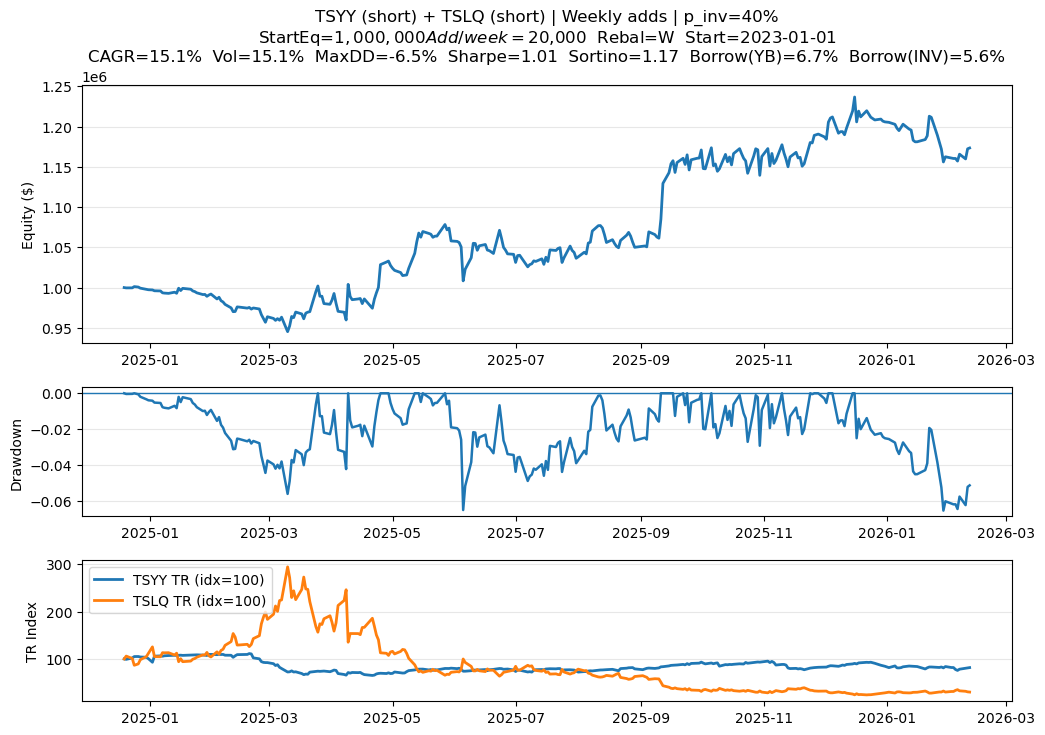

In [91]:
def run_pair_for_mix(
    *,
    tr_prices: pd.DataFrame,
    yb: str,
    inv: str,
    beta_yb: float,
    p_inv: float,
    beta_inv: float | None = None,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    initial_equity: float = 1_000_000.0,
    weekly_gross_add: float = 20_000.0,
    borrow_yb_annual: float | None = None,
    borrow_inv_annual: float | None = None,
) -> dict:
    """
    Runs the weekly-adds strategy for a single pair + mix.
    Mix is defined as the fraction of weekly gross add allocated to the inverse leg.
      p_inv=0 -> all YB
      p_inv=1 -> all INV
    Returns dict with:
      - r: daily returns
      - curve: equity curve
      - dd: drawdown
      - px_norm: normalized TR prices (idx=100)
      - meta: weights used, etc.
    """
    yb  = str(yb).upper().replace(".", "-")
    inv = str(inv).upper().replace(".", "-")
    p_inv = float(np.clip(p_inv, 0.0, 1.0))
    p_yb = 1.0 - p_inv

    yb_col  = f"{yb}_TR"
    inv_col = f"{inv}_TR"
    if yb_col not in tr_prices.columns or inv_col not in tr_prices.columns:
        return {"r": pd.Series(dtype=float)}

    px = tr_prices[[yb_col, inv_col]].copy()
    px = px.loc[px.index >= pd.Timestamp(backtest_start)].dropna()
    if px.empty:
        return {"r": pd.Series(dtype=float)}

    ret = px.pct_change().dropna()
    if ret.empty:
        return {"r": pd.Series(dtype=float)}
    ret.columns = ["yb", "inv"]

    if borrow_yb_annual is None:
        borrow_yb_annual = get_borrow_annual(yb)
    if borrow_inv_annual is None:
        borrow_inv_annual = get_borrow_annual(inv)

    b_yb_daily  = (1.0 + float(borrow_yb_annual)) ** (1.0 / TRADING_DAYS) - 1.0
    b_inv_daily = (1.0 + float(borrow_inv_annual)) ** (1.0 / TRADING_DAYS) - 1.0

    idx = ret.index
    if freq.upper().startswith("W"):
        rebalance_flag = idx.to_series().dt.to_period("W").ne(idx.to_series().shift(1).dt.to_period("W"))
    else:
        rebalance_flag = pd.Series(True, index=idx)

    equity = float(initial_equity)
    prev_equity = equity

    yb_notional_out = 0.0
    inv_notional_out = 0.0

    out_r = []
    for t in idx:
        if rebalance_flag.loc[t]:
            yb_notional_out  += weekly_gross_add * p_yb
            inv_notional_out += weekly_gross_add * p_inv

        pnl = (-yb_notional_out  * ret.at[t, "yb"]) + (-inv_notional_out * ret.at[t, "inv"])
        borrow = (yb_notional_out * b_yb_daily) + (inv_notional_out * b_inv_daily)
        pnl -= borrow

        equity = equity + pnl
        out_r.append((equity / prev_equity) - 1.0)
        prev_equity = equity

        if equity <= 0:
            break

    r = pd.Series(out_r, index=idx[:len(out_r)], name=f"{yb}__{inv}__p_inv={p_inv:.2f}")
    curve = (1.0 + r).cumprod() * initial_equity
    dd = curve / curve.cummax() - 1.0

    # normalized TR prices for plotting
    px_aligned = px.loc[px.index.isin(r.index)].copy()
    px_norm = 100.0 * px_aligned / px_aligned.iloc[0]

    return {
        "r": r,
        "curve": curve,
        "dd": dd,
        "px_norm": px_norm,
        "meta": {
            "yb": yb,
            "inv": inv,
            "p_yb": p_yb,
            "p_inv": p_inv,
            "weekly_gross_add": weekly_gross_add,
            "initial_equity": initial_equity,
            "borrow_yb": float(borrow_yb_annual),
            "borrow_inv": float(borrow_inv_annual),
        }
    }

def plot_pair_diagnostics(
    *,
    tr_prices: pd.DataFrame,
    yb: str,
    inv: str,
    beta_yb: float,
    p_inv: float,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    initial_equity: float = 1_000_000.0,
    weekly_gross_add: float = 20_000.0,
    mar_annual: float = 0.0,
):
    res = run_pair_for_mix(
        tr_prices=tr_prices,
        yb=yb,
        inv=inv,
        beta_yb=beta_yb,
        p_inv=p_inv,
        backtest_start=backtest_start,
        freq=freq,
        initial_equity=initial_equity,
        weekly_gross_add=weekly_gross_add,
    )
    r = res.get("r", pd.Series(dtype=float))
    if r.empty:
        print(f"No data for {yb}/{inv} starting {backtest_start}")
        return

    curve = res["curve"]
    dd = res["dd"]
    px_norm = res["px_norm"]
    meta = res["meta"]
    stats = perf_stats_extended(r, mar_annual=mar_annual)

    yb_col  = f"{meta['yb']}_TR"
    inv_col = f"{meta['inv']}_TR"

    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.1, 1.2], hspace=0.25)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)

    ax1.plot(curve.index, curve.values, linewidth=2.0)
    ax1.set_title(
        f"{meta['yb']} (short) + {meta['inv']} (short) | Weekly adds | p_inv={meta['p_inv']:.0%}\n"
        f"StartEq=${meta['initial_equity']:,.0f}  Add/week=${meta['weekly_gross_add']:,.0f}  Rebal={freq}  Start={backtest_start}\n"
        f"CAGR={stats['CAGR']:.1%}  Vol={stats['AnnVol']:.1%}  MaxDD={stats['MaxDD']:.1%}  "
        f"Sharpe={stats['Sharpe']:.2f}  Sortino={stats['Sortino']:.2f}  "
        f"Borrow(YB)={meta['borrow_yb']:.1%}  Borrow(INV)={meta['borrow_inv']:.1%}"
    )
    ax1.set_ylabel("Equity ($)")
    ax1.grid(True, axis="y", alpha=0.3)

    ax2.plot(dd.index, dd.values, linewidth=1.8)
    ax2.axhline(0, linewidth=1)
    ax2.set_ylabel("Drawdown")
    ax2.grid(True, axis="y", alpha=0.3)

    ax3.plot(px_norm.index, px_norm[yb_col].values, linewidth=2.0, label=f"{meta['yb']} TR (idx=100)")
    ax3.plot(px_norm.index, px_norm[inv_col].values, linewidth=2.0, label=f"{meta['inv']} TR (idx=100)")
    ax3.set_ylabel("TR Index")
    ax3.legend(loc="upper left")
    ax3.grid(True, axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

pair = ("TSYY", "TSLQ")

# Choose p_inv from your sweep table (for example the best Sortino mix)
tmp = sweep[(sweep["YieldBOOST"]==pair[0]) & (sweep["InverseETF"]==pair[1])].copy()
tmp = tmp.sort_values("Sortino", ascending=False)
best_p_inv = float(tmp.iloc[0]["p_inv"])
print("Best p_inv:", best_p_inv)

# beta_yb from your pairs df
beta_yb = float(yieldboost_pairs_df.loc[yieldboost_pairs_df["ETF"].str.upper()==pair[0], "Beta_used"].iloc[0])

plot_pair_diagnostics(
    tr_prices=prices,
    yb=pair[0],
    inv=pair[1],
    beta_yb=beta_yb,
    p_inv=best_p_inv,
    backtest_start="2023-01-01",
    freq="W",
    initial_equity=1_000_000.0,
    weekly_gross_add=20_000.0,
)



ETF Underlying UnderlyingLeveredETF      CAGR    AnnVol     MaxDD  \
4  MSFW       MSFT                 MSFU  0.035375  0.024767 -0.006506   
5  HOOW       HOOD                 HOOX  0.045874  0.034299 -0.012264   
1  MARO       MARA                 MRAL  0.196461  0.179421 -0.126354   
6  PLTW       PLTR                 PTIR  0.063964  0.076518 -0.028214   
7  NFLW       NFLX                 NFLX  0.021817  0.024741 -0.009821   
3  MSTW       MSTR                 MSTX  0.019362  0.051194 -0.018790   
2  BABW       BABA                 BABX  0.016620  0.033336 -0.008103   
0  BABO       BABA                 BABX  0.036060  0.106040 -0.088347   
8  AMZW       AMZN                 AMZZ  0.010465  0.025022 -0.007955   
9  MSOO       MSTR                 MSTX -0.059944  0.118723 -0.074090   

     Sharpe   Sortino  Borrow_ETF  Borrow_UnderlyingLeveredETF  TradingDays  \
4  1.416103  1.575626    0.000000                     0.080134          140   
5  1.324961  1.211967    0.000000                     0.212264          164   
1  1.089626  1.208507    0.005060                     0.553718          293   
6  0.848664  0.865027    0.000000                     0.008712          247   
7  0.884733  0.826571    0.010202                     0.000000          164   
3  0.400093  0.527372    0.047650                     0.390264          140   
2  0.511160  0.490252    0.024596                     0.000000           76   
0  0.386909  0.455549    0.044136                     0.000000          379   
8  0.428587  0.437473    0.037726                     0.013592          164   
9 -0.461181 -0.474934    0.050000                     0.390264          126   

   Beta_used  
4   1.212071  
5   1.205724  
1   0.783981  
6   1.191101  
7   1.185489  
3   1.227288  
2   1.221486  
0   0.769067  
8   1.214240  
9   0.995078

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


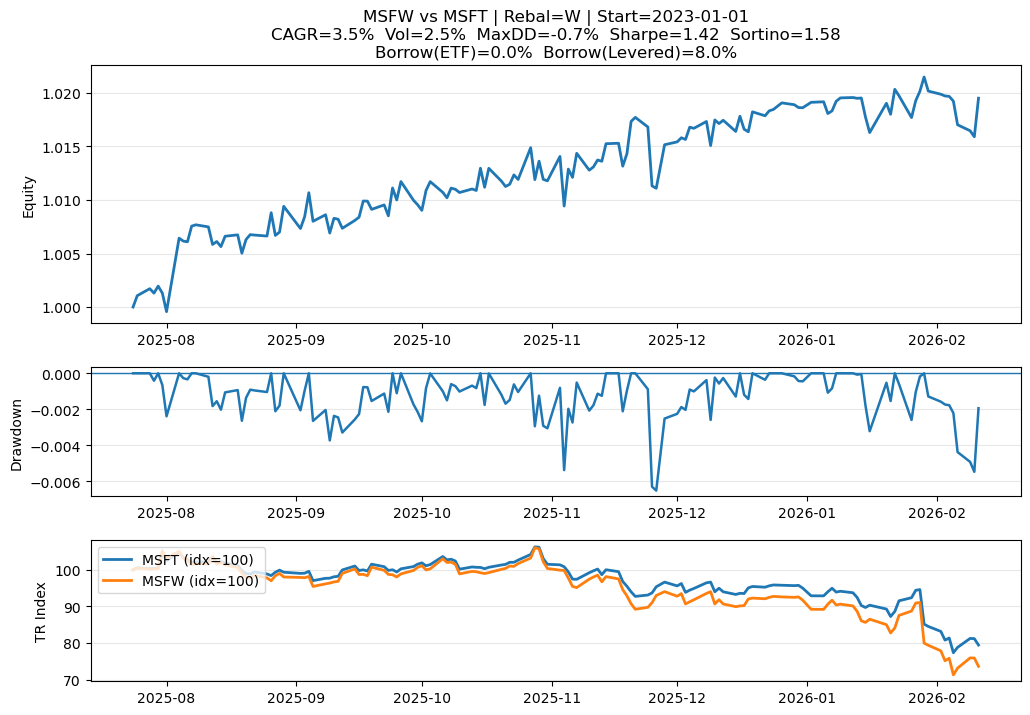

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


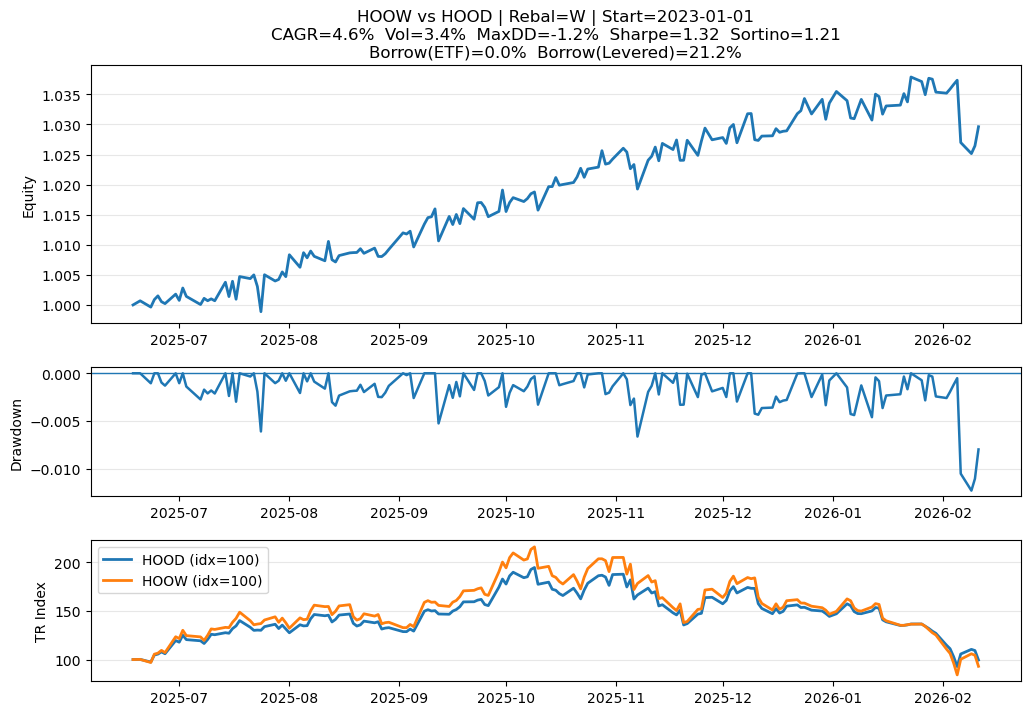

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


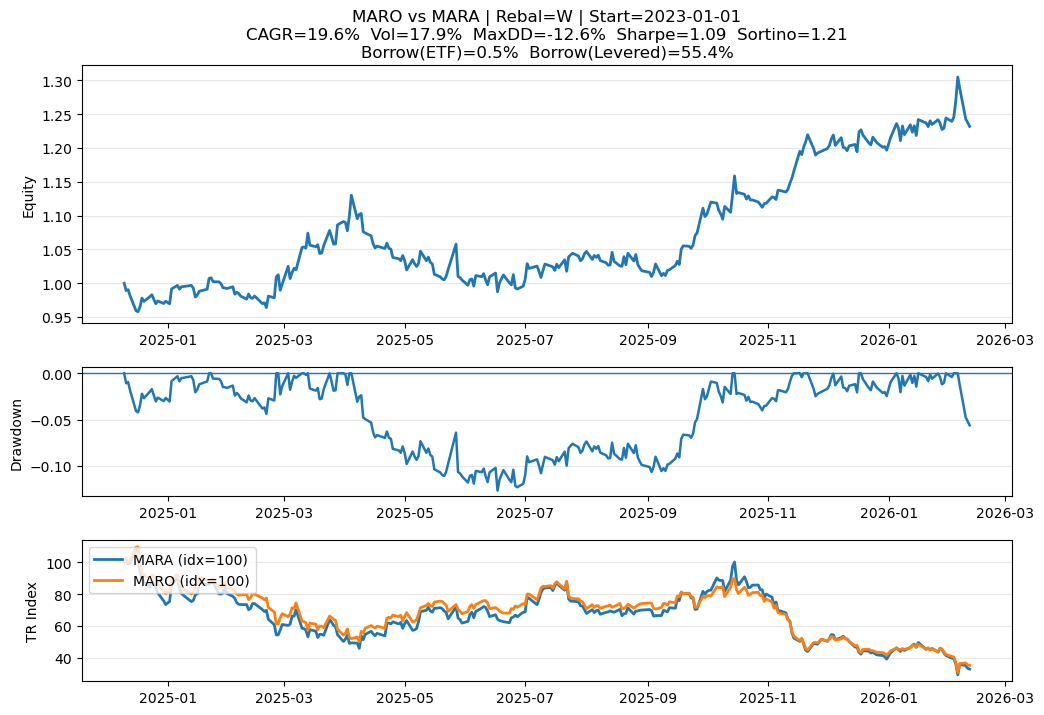

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


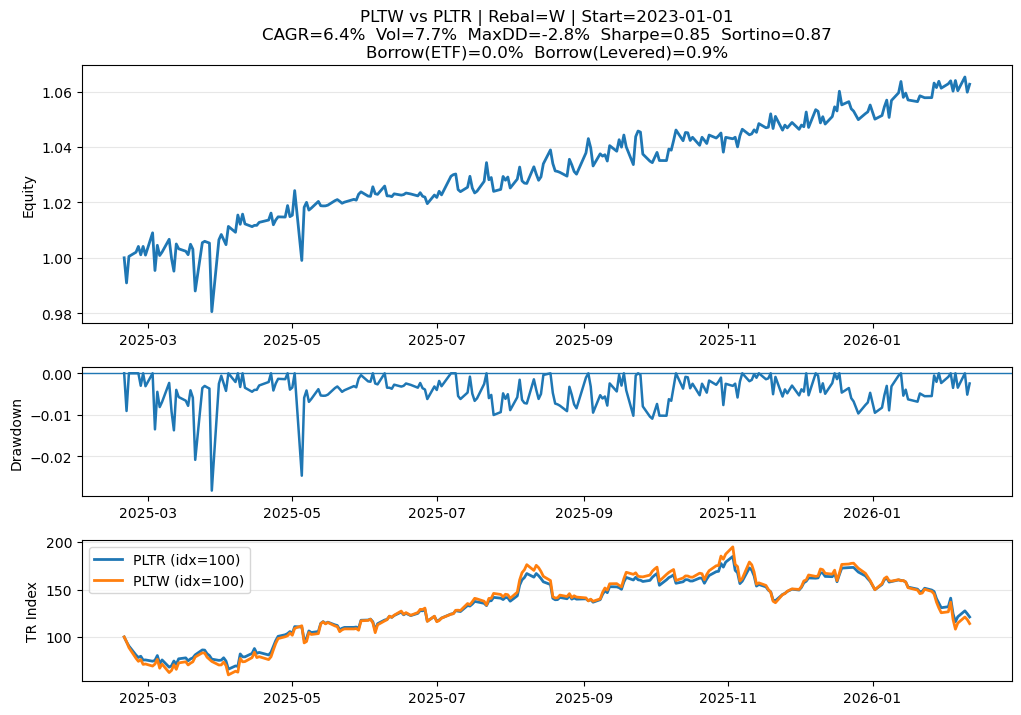

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


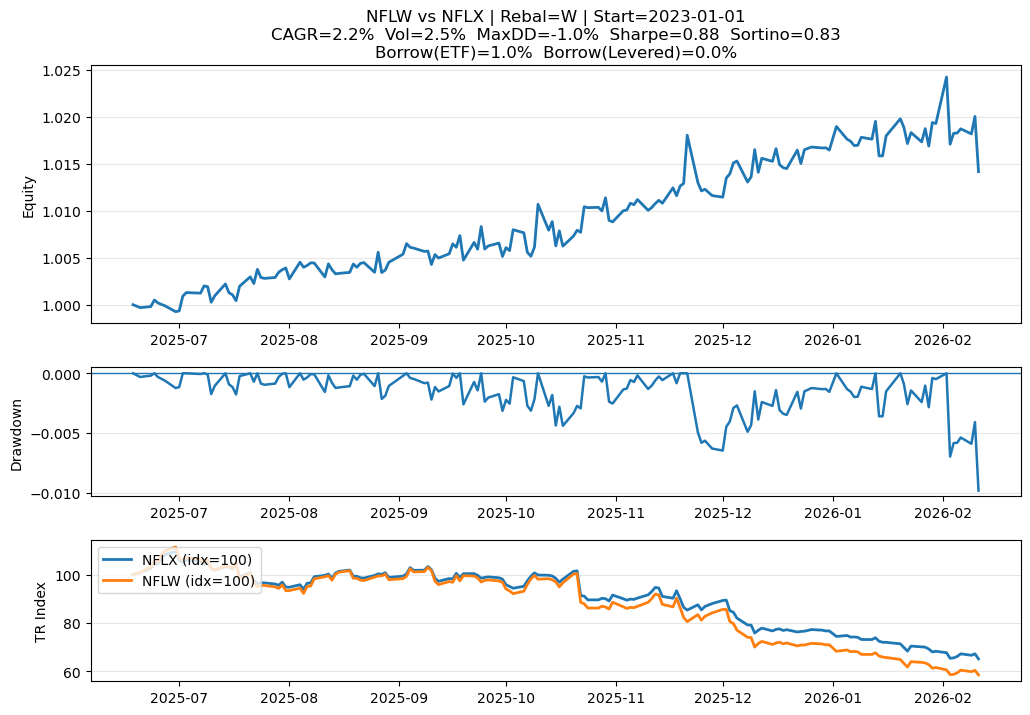

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


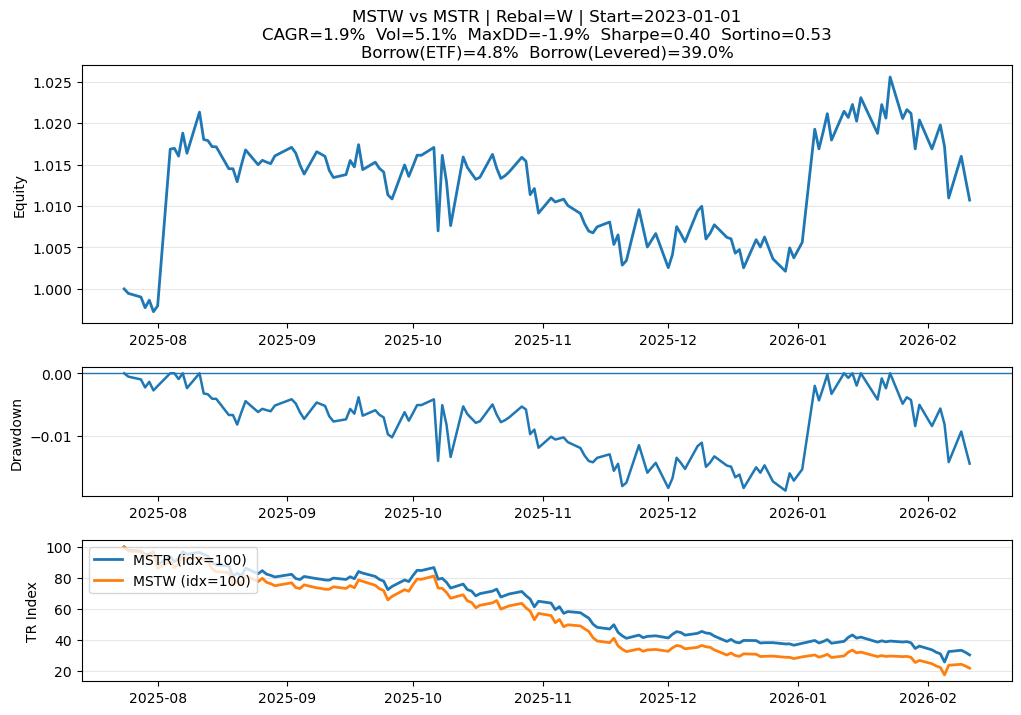

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


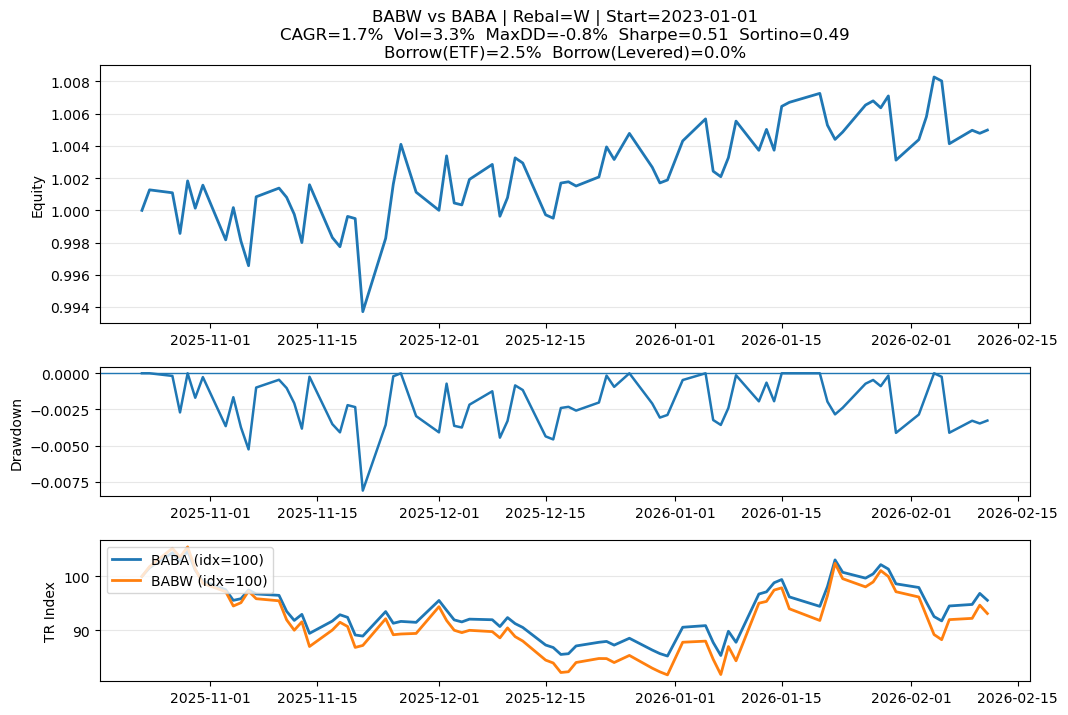

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


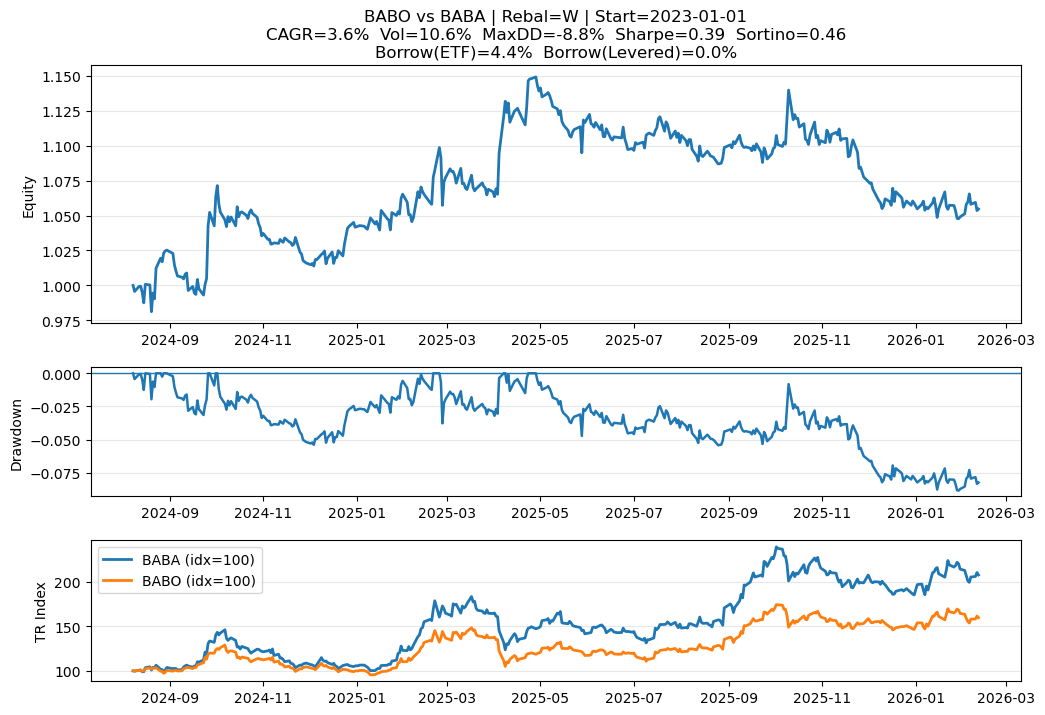

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


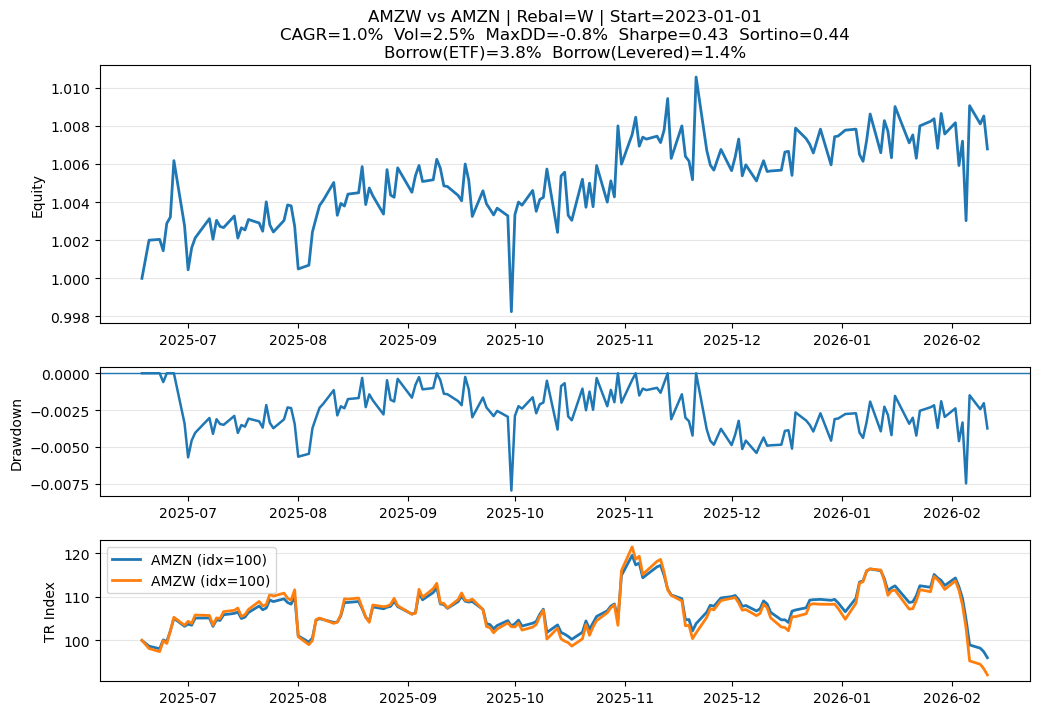

C:\Users\werdn\AppData\Local\Temp\ipykernel_17740\3259184070.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


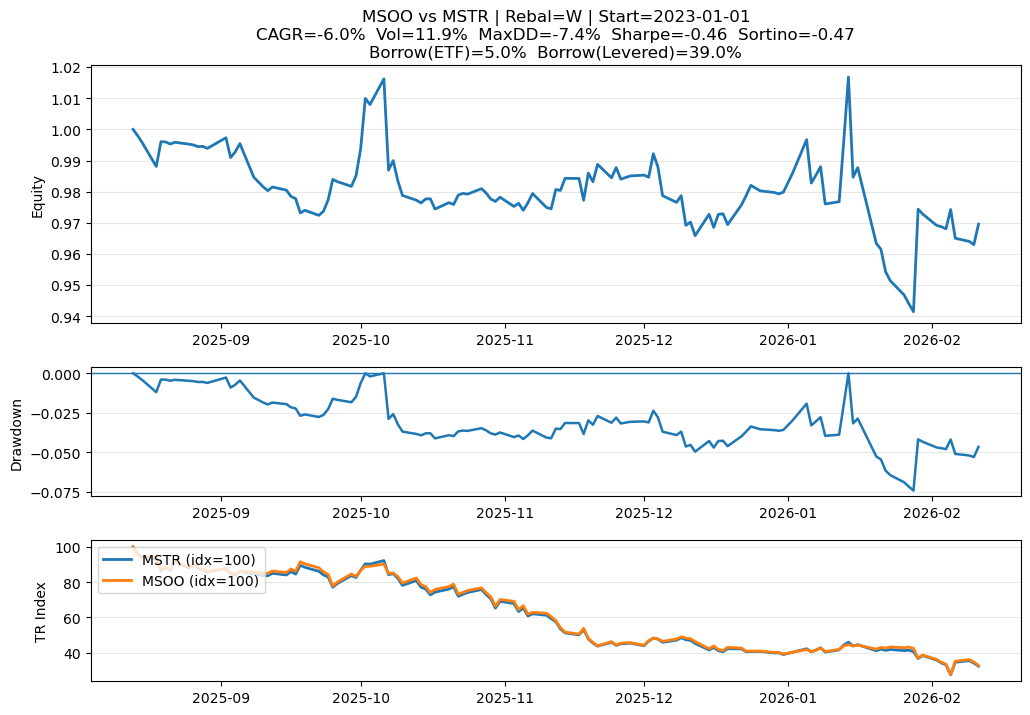

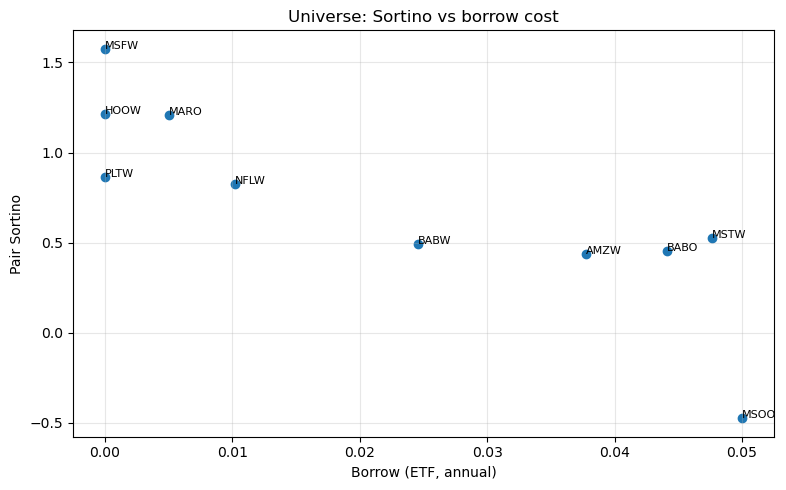

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05

# ============================================================
# 0) Helper: borrow
# ============================================================
def get_borrow_annual(symbol: str) -> float:
    sym = str(symbol).upper().replace(".", "-")
    if "borrow_map" in globals() and (globals().get("borrow_map") is not None):
        bm = globals()["borrow_map"]
        if sym in bm:
            return float(bm[sym])
        if "default" in bm:
            return float(bm["default"])
    return float(DEFAULT_BORROW_ANNUAL)

# ============================================================
# 1) Perf stats (CAGR/Vol/DD/Sortino)
# ============================================================
def perf_stats_extended(ret: pd.Series, mar_annual: float = 0.0) -> dict:
    ret = ret.dropna()
    n = len(ret)
    if n == 0:
        return dict(TradingDays=0, TotalReturn=np.nan, CAGR=np.nan, AnnVol=np.nan,
                    MaxDD=np.nan, Sharpe=np.nan, Sortino=np.nan, Calmar=np.nan)

    curve = (1.0 + ret).cumprod()
    total = float(curve.iloc[-1] - 1.0)
    cagr  = float(curve.iloc[-1] ** (TRADING_DAYS / n) - 1.0)
    vol   = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    dd    = curve / curve.cummax() - 1.0
    maxdd = float(dd.min())

    mu_ann = float(ret.mean() * TRADING_DAYS)
    sharpe = float(mu_ann / vol) if vol > 0 else np.nan

    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0
    downside = ret[ret < mar_daily] - mar_daily
    down_vol = float(np.sqrt((downside**2).mean()) * np.sqrt(TRADING_DAYS)) if len(downside) else 0.0
    sortino  = float(mu_ann / down_vol) if down_vol > 0 else np.nan

    calmar = float(cagr / abs(maxdd)) if maxdd < 0 else np.nan

    return dict(
        TradingDays=int(n),
        TotalReturn=total,
        CAGR=cagr,
        AnnVol=vol,
        MaxDD=maxdd,
        Sharpe=sharpe,
        Sortino=sortino,
        Calmar=calmar,
    )

# ============================================================
# 2) Universe mapping for the new tickers you listed
#    You MUST verify these if your dataset uses different tickers.
# ============================================================
# "UnderlyingLeveredETF" here is the leveraged product whose options these funds write
# (or the closest proxy you want to track borrow on).
stack_map = {
    "BABO": {"Underlying": "BABA", "UnderlyingLeveredETF": "BABX"},  # proxy: 2x BABA
    "BABW": {"Underlying": "BABA", "UnderlyingLeveredETF": "BABX"},
    "MARO": {"Underlying": "MARA", "UnderlyingLeveredETF": "MRAL"},  # proxy: 2x MARA
    "MSTW": {"Underlying": "MSTR", "UnderlyingLeveredETF": "MSTX"},  # proxy: 2x/levered MSTR
    "MSFW": {"Underlying": "MSFT", "UnderlyingLeveredETF": "MSFU"},  # proxy: 2x MSFT (verify)
    "HOOW": {"Underlying": "HOOD", "UnderlyingLeveredETF": "HOOX"},  # proxy: 2x HOOD
    "PLTW": {"Underlying": "PLTR", "UnderlyingLeveredETF": "PTIR"},  # proxy: 2x PLTR
    "NFLW": {"Underlying": "NFLX", "UnderlyingLeveredETF": "NFLX"},  # placeholder if no levered proxy in your universe
    "AMZW": {"Underlying": "AMZN", "UnderlyingLeveredETF": "AMZZ"},  # proxy: 2x AMZN
    "MSOO": {"Underlying": "MSTR", "UnderlyingLeveredETF": "MSTX"}
}

# ============================================================
# 3) Pull total-return column names
# ============================================================
def _tr_col(ticker: str) -> str:
    return f"{str(ticker).upper().replace('.', '-')}_TR"

def _has_cols(tr_prices: pd.DataFrame, cols: list[str]) -> bool:
    return all(c in tr_prices.columns for c in cols)

# ============================================================
# 4) Run one pair through your existing simulator
#    IMPORTANT: requires simulate_pair_weekly_beta_hedged(...) to already exist.
# ============================================================
def run_one_pair(
    *,
    tr_prices: pd.DataFrame,
    etf: str,
    underlying: str,
    beta_used: float,
    borrow_annual: float,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
):
    # sanity check for TR columns
    cols = [_tr_col(etf), _tr_col(underlying)]
    if not _has_cols(tr_prices, cols):
        return None, None

    r = simulate_pair_weekly_beta_hedged(
        tr_prices=tr_prices,
        underlying=underlying,
        etf=etf,
        beta_used=beta_used,
        borrow_annual=borrow_annual,
        backtest_start=backtest_start,
        freq=freq,
        beta_floor=beta_floor,
        initial_equity=1.0,
    )
    if r.empty:
        return None, None

    stats = perf_stats_extended(r, mar_annual=mar_annual)
    return r, stats

# ============================================================
# 5) Summary table for your new tickers
# ============================================================
def summarize_stack_universe(
    *,
    tr_prices: pd.DataFrame,
    tickers: list[str],
    beta_scalar: float = 1.0,          # e.g. 1.0, 1.2, 1.5
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
):
    rows = []

    for tkr in tickers:
        tkr = str(tkr).upper().replace(".", "-")
        if tkr not in stack_map:
            print(f"Skip {tkr}: not in stack_map")
            continue

        und = stack_map[tkr]["Underlying"]
        lev = stack_map[tkr]["UnderlyingLeveredETF"]

        # Use historical Beta from your pairs_ok (if present); else fallback to 1.0
        beta_used = np.nan
        if "pairs_ok" in globals():
            m = pairs_ok[(pairs_ok["ETF"].str.upper()==tkr) & (pairs_ok["Underlying"].str.upper()==und)]
            if len(m) > 0:
                if "Beta" in m.columns:
                    beta_used = float(m["Beta"].iloc[0])
                elif "Beta_used" in m.columns:
                    beta_used = float(m["Beta_used"].iloc[0])

        if not np.isfinite(beta_used):
            beta_used = 1.0

        beta_used *= float(beta_scalar)

        borrow_etf = get_borrow_annual(tkr)
        borrow_lev = get_borrow_annual(lev) if lev else np.nan

        r, stats = run_one_pair(
            tr_prices=tr_prices,
            etf=tkr,
            underlying=und,
            beta_used=beta_used,
            borrow_annual=borrow_etf,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            mar_annual=mar_annual,
        )
        if stats is None:
            print(f"Skip {tkr}/{und}: missing TR cols or no history")
            continue

        rows.append({
            "ETF": tkr,
            "Underlying": und,
            "UnderlyingLeveredETF": lev,
            "Beta_used": beta_used,
            "Borrow_ETF": borrow_etf,
            "Borrow_UnderlyingLeveredETF": borrow_lev,
            **stats
        })

    return pd.DataFrame(rows)

# ============================================================
# 6) Plot each pair (equity, drawdown, normalized prices)
# ============================================================
def plot_pairs_from_summary(
    *,
    tr_prices: pd.DataFrame,
    summary: pd.DataFrame,
    backtest_start: str = "2023-01-01",
    freq: str = "W",
    beta_floor: float = 0.25,
    mar_annual: float = 0.0,
    sort_by: str = "Sortino",
):
    df = summary.copy()
    if sort_by in df.columns:
        df = df.sort_values(sort_by, ascending=False)

    for _, row in df.iterrows():
        etf = row["ETF"]
        und = row["Underlying"]
        beta_used = float(row["Beta_used"])
        borrow_etf = float(row["Borrow_ETF"])

        r, stats = run_one_pair(
            tr_prices=tr_prices,
            etf=etf,
            underlying=und,
            beta_used=beta_used,
            borrow_annual=borrow_etf,
            backtest_start=backtest_start,
            freq=freq,
            beta_floor=beta_floor,
            mar_annual=mar_annual,
        )
        if stats is None:
            continue

        curve = (1 + r).cumprod()
        dd = curve / curve.cummax() - 1.0

        # price panel
        etf_col = _tr_col(etf)
        und_col = _tr_col(und)
        px = tr_prices[[und_col, etf_col]].dropna()
        px = px.loc[px.index >= pd.Timestamp(backtest_start)]
        px = px.loc[px.index.isin(r.index)]
        if px.empty:
            continue
        px_norm = 100.0 * px / px.iloc[0]

        fig = plt.figure(figsize=(12, 8))
        gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.1, 1.2], hspace=0.25)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        ax3 = fig.add_subplot(gs[2], sharex=ax1)

        ax1.plot(curve.index, curve.values, linewidth=2.0)
        ax1.set_title(
            f"{etf} vs {und} | Rebal={freq} | Start={backtest_start}\n"
            f"CAGR={stats['CAGR']:.1%}  Vol={stats['AnnVol']:.1%}  MaxDD={stats['MaxDD']:.1%}  "
            f"Sharpe={stats['Sharpe']:.2f}  Sortino={stats['Sortino']:.2f}\n"
            f"Borrow(ETF)={row['Borrow_ETF']:.1%}  Borrow(Levered)={row['Borrow_UnderlyingLeveredETF'] if pd.notna(row['Borrow_UnderlyingLeveredETF']) else np.nan:.1%}"
        )
        ax1.set_ylabel("Equity")
        ax1.grid(True, axis="y", alpha=0.3)

        ax2.plot(dd.index, dd.values, linewidth=1.8)
        ax2.axhline(0, linewidth=1)
        ax2.set_ylabel("Drawdown")
        ax2.grid(True, axis="y", alpha=0.3)

        ax3.plot(px_norm.index, px_norm[und_col], linewidth=2.0, label=f"{und} (idx=100)")
        ax3.plot(px_norm.index, px_norm[etf_col], linewidth=2.0, label=f"{etf} (idx=100)")
        ax3.set_ylabel("TR Index")
        ax3.legend(loc="upper left")
        ax3.grid(True, axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()

# ============================================================
# RUN: same analysis for your tickers
# ============================================================
tickers = ["BABO", "MARO", "BABW", "MSTW", "MSFW", "HOOW", "PLTW", "NFLW", "AMZW", "MSOO"]

# Choose beta scalar like you did before (1.0, 1.2, 1.5)
BETA_SCALAR = 1.0

summary2 = summarize_stack_universe(
    tr_prices=prices,           # your TR price wide DF
    tickers=tickers,
    beta_scalar=BETA_SCALAR,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    mar_annual=0.0,
)

display(
    summary2.sort_values("Sortino", ascending=False)[
        ["ETF","Underlying","UnderlyingLeveredETF","CAGR","AnnVol","MaxDD","Sharpe","Sortino",
         "Borrow_ETF","Borrow_UnderlyingLeveredETF","TradingDays","Beta_used"]
    ]
)

plot_pairs_from_summary(
    tr_prices=prices,
    summary=summary2,
    backtest_start="2023-01-01",
    freq="W",
    beta_floor=0.25,
    mar_annual=0.0,
    sort_by="Sortino",
)

# Optional scatter: Sortino vs borrow costs (ETF borrow on x-axis)
tmp = summary2.dropna(subset=["Sortino"]).copy()
plt.figure(figsize=(8,5))
plt.scatter(tmp["Borrow_ETF"], tmp["Sortino"])
for _, r in tmp.iterrows():
    plt.text(r["Borrow_ETF"], r["Sortino"], r["ETF"], fontsize=8)
plt.xlabel("Borrow (ETF, annual)")
plt.ylabel("Pair Sortino")
plt.title("Universe: Sortino vs borrow cost")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# =========================
# CONFIG (ADD / UPDATE)
# =========================
TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05  # 5%

# NEW: Margin financing assumptions (IBKR-style daily accrual on debit)
MARGIN_ANNUAL   = 0.04428   # 4.428% blended
MARGIN_DAYCOUNT = 360       # IBKR-style Actual/360 convention for daily accrual

def simulate_sleeve_fixed_shares_rebalanced_to_gross(
    tr_prices: pd.DataFrame,
    pairs: list[tuple[str, str]],
    short_ratio: float,
    borrow_daily_map: dict[str, float],
    freq: str = "M",
    start_when_first_pair_active: bool = True,
    target_gross_mult: float = 4.0,
    initial_equity: float = 1.0,
    default_borrow_daily: float = DEFAULT_BORROW_ANNUAL / TRADING_DAYS,
    lock_universe_if_never: bool = True,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    px = tr_prices.copy()
    if px.index.tz is not None:
        px.index = px.index.tz_convert("UTC").tz_localize(None)

    idx = px.index
    rebal_days = get_rebalance_days(idx, freq)
    pair_start = build_pair_start_dates(px, pairs)

    equity = float(initial_equity)
    shares_under = pd.Series(dtype=float)
    shares_etf   = pd.Series(dtype=float)
    port_ret = pd.Series(index=idx, dtype=float)
    pair_count = pd.Series(index=idx, dtype=int)

    # NEW: diagnostics
    diag = pd.DataFrame(index=idx, columns=[
        "Equity",
        "LongNotional_prev",
        "ShortNotional_prev",
        "NetLong_prev",
        "Debit_prev",
        "MarginInterest",
        "BorrowCost",
    ], dtype=float)

    first_active_day = None
    locked_pairs = None

    def eligible_pairs_on(t):
        elig = []
        for (und, etf), d0 in pair_start.items():
            if d0 is None or d0 > t:
                continue
            elig.append((und, etf))
        return elig

    def rebalance_to_target_gross(t, active_pairs):
        nonlocal shares_under, shares_etf

        n = len(active_pairs)
        if n == 0:
            shares_under = pd.Series(dtype=float)
            shares_etf   = pd.Series(dtype=float)
            return

        gross_target = target_gross_mult * equity
        gross_per_pair = gross_target / n
        a = gross_per_pair / (1.0 + abs(short_ratio))

        su, se = {}, {}
        for und, etf in active_pairs:
            und_col = f"{und}_TR"
            etf_col = f"{etf}_TR"
            if und_col not in px.columns or etf_col not in px.columns:
                continue

            pu = float(px.at[t, und_col])
            pe = float(px.at[t, etf_col])
            if not np.isfinite(pu) or pu <= 0 or not np.isfinite(pe) or pe <= 0:
                continue

            long_u_dol  = a
            short_e_dol = a * abs(short_ratio)

            su[und] = su.get(und, 0.0) + (long_u_dol / pu)
            se[etf] = se.get(etf, 0.0) - (short_e_dol / pe)

        shares_under = pd.Series(su, dtype=float)
        shares_etf   = pd.Series(se, dtype=float)

    prev_t = None
    margin_daily = float(margin_annual) / float(margin_daycount)

    for t in idx:
        # rebalance logic (unchanged)
        if str(freq).upper() == "NEVER" and lock_universe_if_never:
            if locked_pairs is None:
                elig = eligible_pairs_on(t)
                if len(elig) > 0:
                    locked_pairs = elig
                    rebalance_to_target_gross(t, locked_pairs)
                    if first_active_day is None:
                        first_active_day = t
            pair_count.at[t] = 0 if locked_pairs is None else len(locked_pairs)
        else:
            if t in rebal_days:
                active_pairs = eligible_pairs_on(t)
                pair_count.at[t] = len(active_pairs)
                if first_active_day is None and len(active_pairs) > 0:
                    first_active_day = t
                rebalance_to_target_gross(t, active_pairs)
            else:
                pair_count.at[t] = 0 if prev_t is None else int(pair_count.at[prev_t])

        diag.at[t, "Equity"] = equity

        if shares_under.empty and shares_etf.empty:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        if prev_t is None:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        pnl = 0.0

        # PnL: underlyings
        for und, sh in shares_under.items():
            col = f"{und}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

        # PnL: ETFs + borrow
        borrow_cost = 0.0
        for etf, sh in shares_etf.items():
            col = f"{etf}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

            b = float(borrow_daily_map.get(etf, default_borrow_daily))
            if np.isfinite(p0):
                borrow_cost += abs(float(sh)) * p0 * b

        # NEW: notionals (prev day) + margin interest
        long_notional_prev = 0.0
        for und, sh in shares_under.items():
            col = f"{und}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            if np.isfinite(p0):
                long_notional_prev += float(sh) * p0

        short_notional_prev = 0.0
        for etf, sh in shares_etf.items():
            col = f"{etf}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            if np.isfinite(p0):
                short_notional_prev += abs(float(sh)) * p0

        net_long_prev = long_notional_prev - short_notional_prev
        debit_prev = max(0.0, net_long_prev - equity)
        margin_interest = debit_prev * margin_daily

        # store diagnostics
        diag.at[t, "LongNotional_prev"]  = long_notional_prev
        diag.at[t, "ShortNotional_prev"] = short_notional_prev
        diag.at[t, "NetLong_prev"]       = net_long_prev
        diag.at[t, "Debit_prev"]         = debit_prev
        diag.at[t, "MarginInterest"]     = margin_interest
        diag.at[t, "BorrowCost"]         = borrow_cost

        pnl -= (borrow_cost + margin_interest)

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        port_ret.at[t] = r
        prev_t = t

    if start_when_first_pair_active and first_active_day is not None:
        port_ret = port_ret.loc[first_active_day:]
        pair_count = pair_count.loc[first_active_day:]
        diag = diag.loc[first_active_day:]

    return port_ret.dropna(), pair_count, diag

def simulate_hybrid_fixed_shares(
    tr_prices: pd.DataFrame,
    borrow_daily_map: dict[str, float],
    cc_pairs: list[tuple[str, str]],
    lev_pairs: list[tuple[str, str]],
    cc_freq: str = "M",
    lev_freq: str = "W",
    target_gross_mult_sleeve: float = 4.0,
    sleeve_mix: float = 0.5,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    ret_cc, pc_cc, diag_cc = simulate_sleeve_fixed_shares_rebalanced_to_gross(
        tr_prices, cc_pairs, short_ratio=CC_SHORT_RATIO,
        borrow_daily_map=borrow_daily_map, freq=cc_freq,
        target_gross_mult=target_gross_mult_sleeve,
        margin_annual=margin_annual, margin_daycount=margin_daycount,
    )

    ret_lev, pc_lev, diag_lev = simulate_sleeve_fixed_shares_rebalanced_to_gross(
        tr_prices, lev_pairs, short_ratio=LEV2_SHORT_RATIO,
        borrow_daily_map=borrow_daily_map, freq=lev_freq,
        target_gross_mult=target_gross_mult_sleeve,
        margin_annual=margin_annual, margin_daycount=margin_daycount,
    )

    common = ret_cc.index.intersection(ret_lev.index)
    if common.empty:
        raise ValueError("No overlapping dates between sleeves.")

    ret_cc = ret_cc.loc[common]
    ret_lev = ret_lev.loc[common]
    pc_cc = pc_cc.loc[common]
    pc_lev = pc_lev.loc[common]
    diag_cc = diag_cc.loc[common]
    diag_lev = diag_lev.loc[common]

    w = float(sleeve_mix)
    port_ret = w * ret_cc + (1.0 - w) * ret_lev

    # return both diags so grid can choose (you’re using sleeve_mix=0, so lev is what matters)
    return port_ret.dropna(), ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev

def run_grid_test(
    prices: pd.DataFrame,
    cc_pairs: list[tuple[str,str]],
    lev_pairs: list[tuple[str,str]],
    cc_freqs=("M",),
    lev_freqs=("W",),
    gross_levels=(2,3,4),
    backtest_start="2022-01-01",
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    start_dt = pd.Timestamp(backtest_start)
    prices_bt = prices.loc[prices.index >= start_dt].copy()
    if prices_bt.empty:
        raise ValueError("No price data after backtest_start.")

    all_etfs = sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    borrow_daily_map = make_borrow_daily_map(all_etfs)

    all_results = []
    best_curves = {}
    best_rows = []

    combos = [(a,b) for a in cc_freqs for b in lev_freqs]

    for g in gross_levels:
        rows = []
        curves = {}

        for cc_f, lev_f in combos:
            port_ret, ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev = simulate_hybrid_fixed_shares(
                prices_bt, borrow_daily_map, cc_pairs, lev_pairs,
                cc_freq=cc_f, lev_freq=lev_f,
                target_gross_mult_sleeve=float(g),
                sleeve_mix=0.0,  # your case: 0% CC / 100% Lev
                margin_annual=margin_annual,
                margin_daycount=margin_daycount,
            )

            # choose which diag to report (since sleeve_mix=0, leveraged sleeve matters)
            diag_use = diag_lev.copy()

            # metrics (all in "per $1 equity" terms because sleeve initial_equity=1)
            # net long utilization as multiple of equity:
            net_long_mult_mean = float((diag_use["NetLong_prev"] / diag_use["Equity"]).dropna().mean())
            debit_mult_mean    = float((diag_use["Debit_prev"]   / diag_use["Equity"]).dropna().mean())

            total_margin_interest = float(diag_use["MarginInterest"].dropna().sum())
            total_borrow_cost     = float(diag_use["BorrowCost"].dropna().sum())

            label = f"Gross={g}x | CC={cc_f}, Lev={lev_f}"
            s = perf_stats(port_ret, label)
            cc_stats  = summarize_pair_count(pc_cc, min_pairs=20, prefix="CC_")
            lev_stats = summarize_pair_count(pc_lev, min_pairs=20, prefix="Lev_")

            rows.append({
                "TargetGross": g,
                "CC_freq": cc_f,
                "Lev_freq": lev_f,
                **s,
                **cc_stats,
                **lev_stats,

                # NEW reporting:
                "NetLong_xEq_mean": net_long_mult_mean,      # e.g. 2.00 means net long = 2x equity on avg
                "Debit_xEq_mean": debit_mult_mean,           # e.g. 1.00 means borrowing ~1x equity on avg
                "MarginInterest_total": total_margin_interest, # total paid over backtest (per $1 starting equity)
                "BorrowCost_total": total_borrow_cost,         # total borrow paid (per $1 starting equity)
            })

            curves[label] = (1 + port_ret).cumprod()

        res_df = pd.DataFrame(rows).sort_values("CAGR", ascending=False)
        all_results.append(res_df)

        print(f"\n===== Target Gross (per sleeve) = {g}x equity =====")
        cols = [
            "TargetGross","CC_freq","Lev_freq",
            "CAGR","Vol","MaxDD","TradingDays",
            "NetLong_xEq_mean","Debit_xEq_mean",
            "MarginInterest_total","BorrowCost_total",
        ]
        print(res_df[cols].to_string(index=False))

        best = res_df.iloc[0].to_dict()
        best_rows.append({
            "TargetGross": g,
            "Best_CC": best["CC_freq"],
            "Best_Lev": best["Lev_freq"],
            "Best_CAGR": best["CAGR"],
            "Best_Vol": best["Vol"],
            "Best_MaxDD": best["MaxDD"],
            "NetLong_xEq_mean": best["NetLong_xEq_mean"],
            "Debit_xEq_mean": best["Debit_xEq_mean"],
            "MarginInterest_total": best["MarginInterest_total"],
            "BorrowCost_total": best["BorrowCost_total"],
            "TradingDays": best["TradingDays"],
        })

        best_label = f"Gross={g}x | CC={best['CC_freq']}, Lev={best['Lev_freq']}"
        best_curves[g] = (best_label, curves[best_label])

    best_df = pd.DataFrame(best_rows).sort_values("TargetGross")
    print("\n===== Best combo by gross =====")
    print(best_df.to_string(index=False))

    plt.figure(figsize=(12,6))
    for g, (lbl, curve) in best_curves.items():
        plt.plot(curve.index, curve.values, label=lbl)
    plt.title("Best equity curve for each target gross (fixed-shares, discrete rebalance)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_results, best_df


# ============================================================
# MAIN (YOU RUN THIS) - call stays the same, but you CAN override margin here
# ============================================================
# prices, cc_pairs, lev_pairs = build_tr_prices_for_universe(dx_df, ym_df)

all_results, best_df = run_grid_test(
    prices,
    cc_pairs,
    lev_pairs,
    cc_freqs=("M","Q"),
    lev_freqs=("W","M"),
    gross_levels=[4, 6, 8],
    backtest_start="2023-01-01",
    margin_annual=0.04428,
    margin_daycount=360,
)


NameError: name 'cc_pairs' is not defined

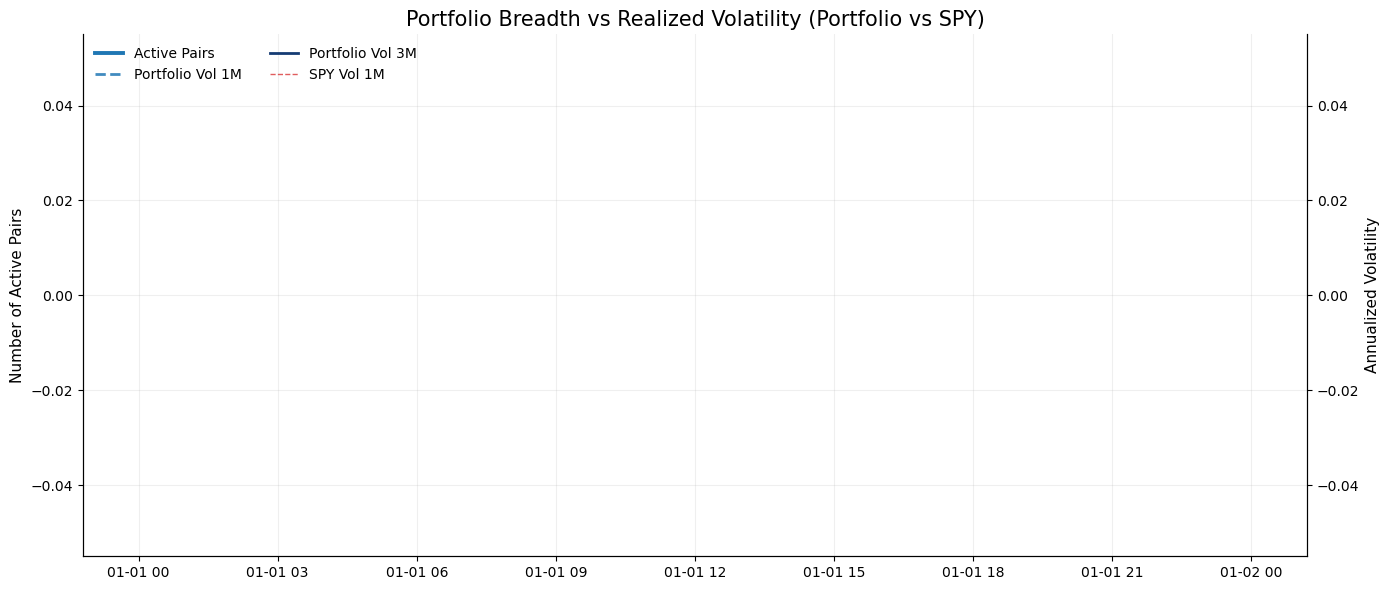

In [86]:
# Align everything
common = port_ret.index.intersection(pc_cc.index).intersection(pc_lev.index)

ret = port_ret.loc[common]
pairs_total = (pc_cc.loc[common] + pc_lev.loc[common]).astype(float)

TRADING_DAYS = 252

# --- SPY rolling vol ---
spy_px = get_total_return_series("SPY").dropna()
spy_ret = spy_px.pct_change().dropna()

# Align to portfolio index
common2 = ret.index.intersection(spy_ret.index)
ret_al  = ret.loc[common2]
pairs_al = pairs_total.loc[common2]
spy_ret_al = spy_ret.loc[common2]

# Recompute rolling vol on the aligned index (portfolio + SPY)
rolling_vol = pd.DataFrame(index=common2)
rolling_vol["Port_Vol_1m"] = ret_al.rolling(21).std()  * np.sqrt(TRADING_DAYS)
rolling_vol["Port_Vol_3m"] = ret_al.rolling(63).std()  * np.sqrt(TRADING_DAYS)
rolling_vol["Port_Vol_6m"] = ret_al.rolling(126).std() * np.sqrt(TRADING_DAYS)

rolling_vol["SPY_Vol_1m"]  = spy_ret_al.rolling(21).std()  * np.sqrt(TRADING_DAYS)
rolling_vol["SPY_Vol_3m"]  = spy_ret_al.rolling(63).std()  * np.sqrt(TRADING_DAYS)
rolling_vol["SPY_Vol_6m"]  = spy_ret_al.rolling(126).std() * np.sqrt(TRADING_DAYS)
plt.figure(figsize=(14,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# --- Pair count (left axis)
ax1.plot(pairs_al.index, pairs_al.values, linewidth=2.8, label="Active Pairs")
ax1.set_ylabel("Number of Active Pairs", fontsize=11)

# --- Portfolio vol (right axis)
# --- Portfolio volatility (blues)
ax2.plot(
    rolling_vol.index,
    rolling_vol["Port_Vol_1m"],
    color="#1f77b4",        # deep blue
    linestyle="--",
    linewidth=2.0,
    alpha=0.85,
    label="Portfolio Vol 1M"
)

ax2.plot(
    rolling_vol.index,
    rolling_vol["Port_Vol_3m"],
    color="#08306b",        # darker blue
    linestyle="-",
    linewidth=2,
    alpha=0.95,
    label="Portfolio Vol 3M"
)

# --- SPY volatility (reds)
ax2.plot(
    rolling_vol.index,
    rolling_vol["SPY_Vol_1m"],
    color="#d62728",        # red
    linestyle="--",
    linewidth=1,
    alpha=0.75,
    label="SPY Vol 1M"
)



ax2.set_ylabel("Annualized Volatility", fontsize=11)

# --- Aesthetics
ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax1.grid(True, alpha=0.2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, frameon=False, loc="upper left", ncols=2)

plt.title("Portfolio Breadth vs Realized Volatility (Portfolio vs SPY)", fontsize=15)
plt.tight_layout()
plt.show()



=== Backtest Summary (Aligned daily returns) ===
                    Series      Start        End TargetGross CC_weight Lev_weight CC_freq Lev_freq AnnReturn AnnVol  MaxDD Sharpe Sortino NetLong_xEq_mean Debit_xEq_mean MarginInterest_total BorrowCost_total
Diamond Creek ETF Arb Fund 2023-01-31 2026-02-05        4.00      0.00       1.00       M        W     33.4%   8.5%  -5.7%   3.44    6.27             1.33           0.33                 5.7%            26.8%
                       SPY 2023-01-31 2026-02-05                                                       20.9%  15.2% -18.8%   1.32    1.98                                                                      


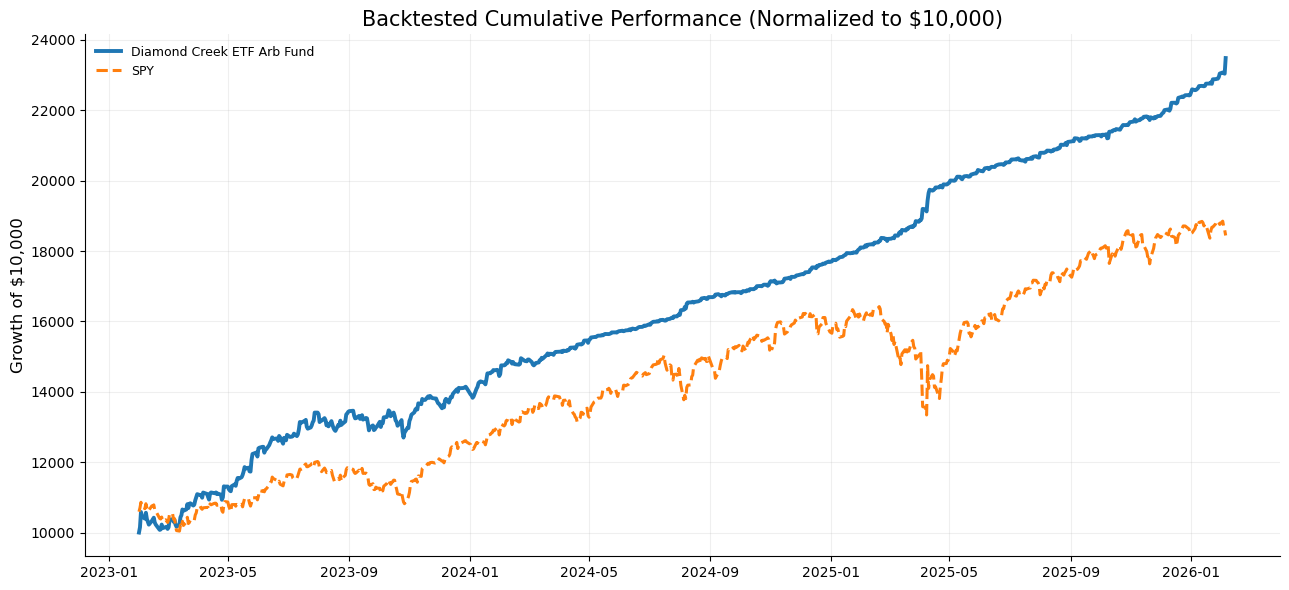

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# -----------------------------
# Perf helpers
# -----------------------------
def max_drawdown_from_curve(curve: pd.Series) -> float:
    dd = curve / curve.cummax() - 1.0
    return float(dd.min())

def sharpe_ratio(ret: pd.Series, rf_annual: float = 0.00) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    rf_daily = (1.0 + rf_annual) ** (1.0 / TRADING_DAYS) - 1.0
    ex = ret - rf_daily
    vol = ex.std(ddof=0)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(ex.mean() / vol * np.sqrt(TRADING_DAYS))

def sortino_ratio(ret: pd.Series, rf_annual: float = 0.00, mar_annual: float | None = None) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan

    mar_annual = rf_annual if mar_annual is None else mar_annual
    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0

    downside = (ret - mar_daily).clip(upper=0.0)
    downside_dev = np.sqrt((downside ** 2).mean())
    if downside_dev == 0 or np.isnan(downside_dev):
        return np.nan

    excess_mean_daily = (ret - mar_daily).mean()
    return float(excess_mean_daily / downside_dev * np.sqrt(TRADING_DAYS))

def perf_from_returns(ret: pd.Series, label: str, rf_annual: float = 0.00) -> dict:
    ret = ret.dropna()
    if ret.empty:
        return {
            "Series": label, "Start": None, "End": None,
            "AnnReturn": np.nan, "AnnVol": np.nan, "MaxDD": np.nan,
            "Sharpe": np.nan, "Sortino": np.nan
        }

    curve = (1.0 + ret).cumprod()
    T = len(ret)

    ann_return = float(curve.iloc[-1] ** (TRADING_DAYS / T) - 1.0)
    ann_vol = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    mdd = max_drawdown_from_curve(curve)

    sh = sharpe_ratio(ret, rf_annual=rf_annual)
    so = sortino_ratio(ret, rf_annual=rf_annual)

    return {
        "Series": label,
        "Start": ret.index.min().date(),
        "End": ret.index.max().date(),
        "AnnReturn": ann_return,
        "AnnVol": ann_vol,
        "MaxDD": mdd,
        "Sharpe": sh,
        "Sortino": so,
    }

def best_row_for_gross(all_results, target_gross: float, tol: float = 1e-6) -> pd.Series:
    candidates = []

    for res_df in all_results:
        if "TargetGross" not in res_df.columns:
            continue

        df = res_df.copy()
        tg = df["TargetGross"]

        if tg.dtype == object:
            tg_num = (
                tg.astype(str)
                  .str.replace("x", "", regex=False)
                  .str.strip()
            )
            tg_num = pd.to_numeric(tg_num, errors="coerce")
        else:
            tg_num = pd.to_numeric(tg, errors="coerce")

        df = df.assign(_tg_num=tg_num)
        m = np.isclose(df["_tg_num"].values, float(target_gross), atol=tol, rtol=0)
        if m.any():
            cand = df.loc[m].sort_values("CAGR", ascending=False).iloc[0]
            candidates.append(cand)

    if candidates:
        best = pd.DataFrame(candidates).sort_values("CAGR", ascending=False).iloc[0]
        return best

    all_rows = []
    for res_df in all_results:
        if "TargetGross" not in res_df.columns:
            continue
        df = res_df.copy()
        tg = df["TargetGross"]
        if tg.dtype == object:
            tg_num = (
                tg.astype(str)
                  .str.replace("x", "", regex=False)
                  .str.strip()
            )
            tg_num = pd.to_numeric(tg_num, errors="coerce")
        else:
            tg_num = pd.to_numeric(tg, errors="coerce")

        df["_tg_num"] = tg_num
        df = df.dropna(subset=["_tg_num", "CAGR"])
        all_rows.append(df)

    if not all_rows:
        raise ValueError("all_results has no usable TargetGross/CAGR rows.")

    big = pd.concat(all_rows, axis=0, ignore_index=True)
    big["dist"] = (big["_tg_num"] - float(target_gross)).abs()

    closest_gross = big.sort_values(["dist", "CAGR"], ascending=[True, False]).iloc[0]["_tg_num"]
    best = big.loc[big["_tg_num"] == closest_gross].sort_values("CAGR", ascending=False).iloc[0]

    print(
        f"WARNING: TargetGross={target_gross} not found in grid. "
        f"Falling back to closest gross={closest_gross} for CC_freq/Lev_freq selection, "
        f"but running simulation at TargetGross={target_gross}."
    )
    return best


# -----------------------------
# Run one configuration and return aligned returns + $10k curve + stats
# UPDATED for new simulate_hybrid_fixed_shares() return signature
# -----------------------------
def run_one_config(
    prices_bt: pd.DataFrame,
    cc_pairs,
    lev_pairs,
    all_results,
    target_gross: float,
    sleeve_mix: float,
    label: str,
    rf_annual: float = 0.00,

    # NEW: margin pass-through (optional)
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    best = best_row_for_gross(all_results, target_gross=target_gross)
    cc_f = str(best["CC_freq"])
    lev_f = str(best["Lev_freq"])

    all_etfs = sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    borrow_daily_map = make_borrow_daily_map(all_etfs)

    # NEW return values: includes diag_cc, diag_lev
    port_ret, ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev = simulate_hybrid_fixed_shares(
        prices_bt,
        borrow_daily_map,
        cc_pairs,
        lev_pairs,
        cc_freq=cc_f,
        lev_freq=lev_f,
        target_gross_mult_sleeve=float(target_gross),
        sleeve_mix=float(sleeve_mix),
        margin_annual=float(margin_annual),
        margin_daycount=int(margin_daycount),
    )

    # Build $10k curve
    curve = (1.0 + port_ret.dropna()).cumprod()
    curve_10k = 10_000.0 * (curve / curve.iloc[0])

    stats = perf_from_returns(port_ret, label, rf_annual=rf_annual)
    stats["TargetGross"] = float(target_gross)
    stats["CC_weight"] = float(sleeve_mix)
    stats["Lev_weight"] = float(1.0 - sleeve_mix)
    stats["CC_freq"] = cc_f
    stats["Lev_freq"] = lev_f

    # Optional: add simple financing diagnostics (reported per $1 initial equity)
    # Choose the sleeve diagnostics that actually drives exposure given the mix:
    diag_use = diag_lev if float(sleeve_mix) <= 0.0 else diag_cc if float(sleeve_mix) >= 1.0 else None
    if diag_use is not None and "Equity" in diag_use.columns:
        net_long_mult_mean = float((diag_use["NetLong_prev"] / diag_use["Equity"]).dropna().mean())
        debit_mult_mean = float((diag_use["Debit_prev"] / diag_use["Equity"]).dropna().mean())
        total_margin_interest = float(diag_use["MarginInterest"].dropna().sum())
        total_borrow_cost = float(diag_use["BorrowCost"].dropna().sum())

        stats["NetLong_xEq_mean"] = net_long_mult_mean
        stats["Debit_xEq_mean"] = debit_mult_mean
        stats["MarginInterest_total"] = total_margin_interest
        stats["BorrowCost_total"] = total_borrow_cost
    else:
        stats["NetLong_xEq_mean"] = np.nan
        stats["Debit_xEq_mean"] = np.nan
        stats["MarginInterest_total"] = np.nan
        stats["BorrowCost_total"] = np.nan

    return port_ret, curve_10k, stats, diag_cc, diag_lev


# ============================================================
# MAIN
# ============================================================
START = pd.Timestamp("2023-01-01")
RF_ANNUAL = 0.00  # set to 0.04 if you want

# Restrict prices to backtest window
prices_bt = prices.loc[prices.index >= START].copy()

# SPY series (aligned later)
spy_px = get_total_return_series("SPY")
spy_px = spy_px.loc[START:].dropna()
spy_ret = spy_px.pct_change().dropna()
spy_curve = (1.0 + spy_ret).cumprod()
spy_curve_10k = 10_000.0 * (spy_curve / spy_curve.iloc[0])

# Desired configurations: (gross, cc_weight, label)
configs = [
    (4.0, 0.0, "Diamond Creek ETF Arb Fund"),
]

results = []
curves = {}
diag_store = {}  # optional: keep diags if you want to inspect

for gross, cc_w, label in configs:
    port_ret, curve_10k, stats, diag_cc, diag_lev = run_one_config(
        prices_bt=prices_bt,
        cc_pairs=cc_pairs,
        lev_pairs=lev_pairs,
        all_results=all_results,
        target_gross=gross,
        sleeve_mix=cc_w,
        label=label,
        rf_annual=RF_ANNUAL,
        margin_annual=MARGIN_ANNUAL,
        margin_daycount=MARGIN_DAYCOUNT,
    )
    results.append(stats)
    curves[label] = curve_10k
    diag_store[label] = {"cc": diag_cc, "lev": diag_lev}

# Align SPY to common curve index for reporting consistency:
common_idx = spy_ret.index
for s in curves.values():
    common_idx = common_idx.intersection(s.index)

spy_ret_aligned = spy_ret.loc[common_idx]
spy_stats = perf_from_returns(spy_ret_aligned, "SPY", rf_annual=RF_ANNUAL)
spy_stats["TargetGross"] = np.nan
spy_stats["CC_weight"] = np.nan
spy_stats["Lev_weight"] = np.nan
spy_stats["CC_freq"] = ""
spy_stats["Lev_freq"] = ""
spy_stats["NetLong_xEq_mean"] = np.nan
spy_stats["Debit_xEq_mean"] = np.nan
spy_stats["MarginInterest_total"] = np.nan
spy_stats["BorrowCost_total"] = np.nan
results.append(spy_stats)

# -----------------------------
# Summary table
# -----------------------------
stats_df = pd.DataFrame(results)

cols = [
    "Series", "Start", "End",
    "TargetGross", "CC_weight", "Lev_weight", "CC_freq", "Lev_freq",
    "AnnReturn", "AnnVol", "MaxDD", "Sharpe", "Sortino",
    # NEW optional diagnostics:
    "NetLong_xEq_mean", "Debit_xEq_mean", "MarginInterest_total", "BorrowCost_total",
]
stats_df = stats_df[cols]

# Format for printing
fmt = stats_df.copy()
for c in ["AnnReturn", "AnnVol", "MaxDD"]:
    fmt[c] = (fmt[c] * 100).map(lambda x: f"{x:,.1f}%" if pd.notna(x) else "")
for c in ["Sharpe", "Sortino"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
for c in ["TargetGross", "CC_weight", "Lev_weight", "NetLong_xEq_mean", "Debit_xEq_mean"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
for c in ["MarginInterest_total", "BorrowCost_total"]:
    # these are totals per $1 initial equity; show as %
    fmt[c] = (fmt[c] * 100).map(lambda x: f"{x:,.1f}%" if pd.notna(x) else "")

print("\n=== Backtest Summary (Aligned daily returns) ===")
print(fmt.to_string(index=False))

# -----------------------------
# Plot all curves normalized to $10,000
# -----------------------------
plt.figure(figsize=(13, 6))

for label, c10k in curves.items():
    c10k_aligned = c10k.loc[common_idx]
    plt.plot(c10k_aligned.index, c10k_aligned.values, linewidth=2.8, label=label)

spy_curve_10k_aligned = spy_curve_10k.loc[common_idx]
plt.plot(
    spy_curve_10k_aligned.index,
    spy_curve_10k_aligned.values,
    linewidth=2.2,
    linestyle="--",
    label="SPY",
)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.20)

plt.title("Backtested Cumulative Performance (Normalized to $10,000)", fontsize=15)
plt.ylabel("Growth of $10,000", fontsize=12)
plt.legend(frameon=False, fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()



=== Backtest Summary (Gross vs Net-to-LPs) ===
                                         Series      Start        End TargetGross CC_weight Lev_weight CC_freq Lev_freq AnnReturn AnnVol  MaxDD Sharpe Sortino
Diamond Creek ETF Arb Fund (Gross of Fund Fees) 2023-02-01 2026-02-05        6.00      0.00       1.00       M        W     50.4%  12.7%  -8.7%   3.28    5.93
        Diamond Creek ETF Arb Fund (Net to LPs) 2023-02-01 2026-02-05        6.00      0.00       1.00       M        W     39.2%  13.1%  -9.2%   2.59    4.36
                                            SPY 2023-02-01 2026-02-05                                                       20.3%  15.2% -18.8%   1.29    1.93


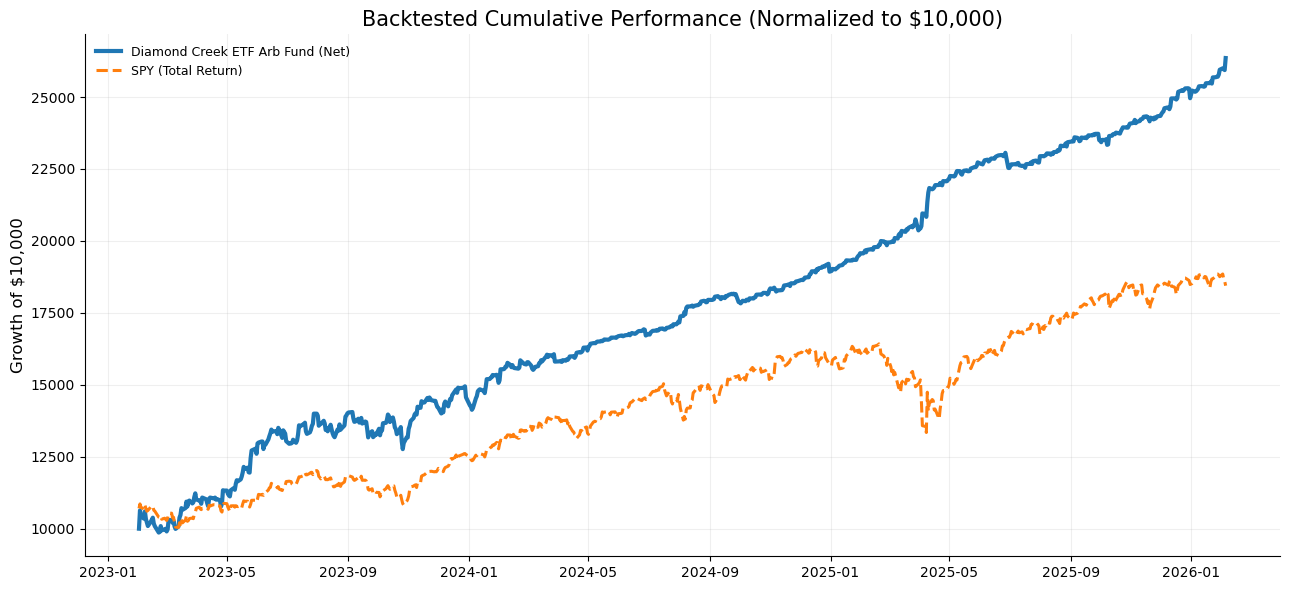

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# ============================================================
# FUND FEE TERMS (LP-LEVEL)
# ============================================================
MGMT_FEE_ANNUAL = 0.02          # 2% per year
INCENTIVE_FEE = 0.20            # 20% performance allocation
HURDLE_ANNUAL = 0.10            # 10% annual hurdle
CRYSTALLIZE_FREQ = "Q"          # quarterly crystallization (and mgmt fee paid quarterly)

# Helpers: convert annual hurdle to per-quarter hurdle (compounded)
HURDLE_Q = (1.0 + HURDLE_ANNUAL) ** (1.0 / 4.0) - 1.0
MGMT_FEE_Q = MGMT_FEE_ANNUAL / 4.0  # simple quarterly charge (industry standard for mgmt fee)

# -----------------------------
# Perf helpers
# -----------------------------
def max_drawdown_from_curve(curve: pd.Series) -> float:
    dd = curve / curve.cummax() - 1.0
    return float(dd.min())

def sharpe_ratio(ret: pd.Series, rf_annual: float = 0.00) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    rf_daily = (1.0 + rf_annual) ** (1.0 / TRADING_DAYS) - 1.0
    ex = ret - rf_daily
    vol = ex.std(ddof=0)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(ex.mean() / vol * np.sqrt(TRADING_DAYS))

def sortino_ratio(ret: pd.Series, rf_annual: float = 0.00, mar_annual: float | None = None) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan

    mar_annual = rf_annual if mar_annual is None else mar_annual
    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0

    downside = (ret - mar_daily).clip(upper=0.0)
    downside_dev = np.sqrt((downside ** 2).mean())
    if downside_dev == 0 or np.isnan(downside_dev):
        return np.nan

    excess_mean_daily = (ret - mar_daily).mean()
    return float(excess_mean_daily / downside_dev * np.sqrt(TRADING_DAYS))

def perf_from_returns(ret: pd.Series, label: str, rf_annual: float = 0.00) -> dict:
    ret = ret.dropna()
    if ret.empty:
        return {
            "Series": label, "Start": None, "End": None,
            "AnnReturn": np.nan, "AnnVol": np.nan, "MaxDD": np.nan,
            "Sharpe": np.nan, "Sortino": np.nan
        }

    curve = (1.0 + ret).cumprod()
    T = len(ret)

    ann_return = float(curve.iloc[-1] ** (TRADING_DAYS / T) - 1.0)
    ann_vol = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    mdd = max_drawdown_from_curve(curve)

    sh = sharpe_ratio(ret, rf_annual=rf_annual)
    so = sortino_ratio(ret, rf_annual=rf_annual)

    return {
        "Series": label,
        "Start": ret.index.min().date(),
        "End": ret.index.max().date(),
        "AnnReturn": ann_return,
        "AnnVol": ann_vol,
        "MaxDD": mdd,
        "Sharpe": sh,
        "Sortino": so,
    }

# ============================================================
# NEW: LP FEE WRAPPER (Quarterly Mgmt + Quarterly Incentive, HWM, Hurdle, Full Catch-Up)
# ============================================================
def apply_lp_fees_quarterly(
    gross_daily_ret: pd.Series,
    mgmt_fee_q: float = MGMT_FEE_Q,
    incentive_fee: float = INCENTIVE_FEE,
    hurdle_q: float = HURDLE_Q,
    crystallize_freq: str = "Q",
) -> tuple[pd.Series, pd.DataFrame]:
    """
    Takes a daily return series (already net of trading/borrow/margin) and applies:
      - Management fee: 2%/yr paid quarterly (subtract mgmt_fee_q from NAV each quarter-end)
      - Incentive fee: 20% above quarterly hurdle, with full GP catch-up
      - High watermark (post-fee NAV)
    Crystallization: quarterly at period end.
    Returns:
      - net_daily_ret (LP net-of-fees daily returns, aligned to input index)
      - fee_diag (period-level diagnostics: gross, mgmt fee $, perf alloc $, HWM, etc.)
    """
    r = gross_daily_ret.replace([np.inf, -np.inf], np.nan).dropna().copy()
    if r.empty:
        return r, pd.DataFrame()

    idx = pd.DatetimeIndex(r.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)

    # Build NAV path with discrete fee events at quarter ends
    nav = 1.0
    hwm = 1.0
    nav_series = pd.Series(index=idx, dtype=float)

    # Diagnostics at crystallization points
    fee_rows = []

    # Define quarter-end dates present in the return index
    # Using period ends ensures robust handling even if not all calendar days exist.
    periods = idx.to_period("Q")
    # For each quarter, take the last trading day in that quarter available in idx
    quarter_ends = (
        pd.Series(idx, index=idx)
        .groupby(periods)
        .max()
        .sort_values()
        .to_list()
    )
    quarter_ends = set(pd.to_datetime(quarter_ends))

    # Track start NAV for hurdle computation within each quarter (post-fee start)
    q_start_nav = nav

    for t in idx:
        # daily compounding (gross of fund fees)
        nav *= (1.0 + float(r.loc[t]))
        nav_series.loc[t] = nav

        # crystallize at quarter end
        if t in quarter_ends:
            nav_pre_fees = nav

            # (1) Management fee charged on quarter-end NAV
            mgmt_fee_amt = mgmt_fee_q * nav_pre_fees
            nav_after_mgmt = nav_pre_fees - mgmt_fee_amt

            # (2) Incentive fee with HWM + hurdle + full catch-up
            perf_fee_amt = 0.0
            hurdle_nav = q_start_nav * (1.0 + hurdle_q)

            # Performance fees only if above BOTH:
            # - high watermark (post-fee)
            # - hurdle for the quarter
            if nav_after_mgmt > hwm and nav_after_mgmt > hurdle_nav:
                # Profits above hurdle, measured from quarter start NAV
                profit_over_hurdle = nav_after_mgmt - hurdle_nav  # dollars of NAV

                # With full catch-up:
                # - After hurdle, GP gets 100% until GP has 20% of total profits
                # - Equivalent closed form: GP allocation = carry * (nav_after_mgmt - hurdle_nav)
                #   when full catch-up is assumed and hurdle is a preferred return.
                # Note: This is the standard “preferred return + catch-up to carry” model.
                perf_fee_amt = incentive_fee * profit_over_hurdle
                nav_after_perf = nav_after_mgmt - perf_fee_amt

                # update HWM to post-fee NAV if it increased
                hwm = max(hwm, nav_after_perf)
                nav = nav_after_perf
            else:
                # no incentive fee; still update HWM if mgmt-fee NAV sets new HWM (rare)
                hwm = max(hwm, nav_after_mgmt)
                nav = nav_after_mgmt

            # record diag
            q_ret_gross = (nav_pre_fees / q_start_nav) - 1.0
            q_ret_net = (nav / q_start_nav) - 1.0

            fee_rows.append({
                "QuarterEnd": t,
                "StartNAV": q_start_nav,
                "EndNAV_preFees": nav_pre_fees,
                "MgmtFee_amt": mgmt_fee_amt,
                "EndNAV_postMgmt": nav_after_mgmt,
                "HurdleNAV": hurdle_nav,
                "PerfFee_amt": perf_fee_amt,
                "EndNAV_postFees": nav,
                "HWM_postFees": hwm,
                "QuarterGrossRet": q_ret_gross,
                "QuarterNetRet": q_ret_net,
            })

            # reset quarter start NAV after crystallization
            q_start_nav = nav

            # overwrite the NAV series at quarter end with post-fee NAV (so curve is post-fee)
            nav_series.loc[t] = nav

    # Convert NAV series to daily net returns (LP net-of-fees)
    nav_series = nav_series.dropna()
    net_daily_ret = nav_series.pct_change().dropna()
    net_daily_ret.name = "LP_NetRet"

    fee_diag = pd.DataFrame(fee_rows)
    if not fee_diag.empty:
        fee_diag["QuarterEnd"] = pd.to_datetime(fee_diag["QuarterEnd"])

    return net_daily_ret, fee_diag


# ============================================================
# Robust "best row for gross"
# ============================================================
def best_row_for_gross(all_results, target_gross: float, tol: float = 1e-6) -> pd.Series:
    candidates = []

    for res_df in all_results:
        if "TargetGross" not in res_df.columns:
            continue

        df = res_df.copy()
        tg = df["TargetGross"]

        if tg.dtype == object:
            tg_num = (
                tg.astype(str)
                  .str.replace("x", "", regex=False)
                  .str.strip()
            )
            tg_num = pd.to_numeric(tg_num, errors="coerce")
        else:
            tg_num = pd.to_numeric(tg, errors="coerce")

        df = df.assign(_tg_num=tg_num)
        m = np.isclose(df["_tg_num"].values, float(target_gross), atol=tol, rtol=0)
        if m.any():
            cand = df.loc[m].sort_values("CAGR", ascending=False).iloc[0]
            candidates.append(cand)

    if candidates:
        best = pd.DataFrame(candidates).sort_values("CAGR", ascending=False).iloc[0]
        return best

    all_rows = []
    for res_df in all_results:
        if "TargetGross" not in res_df.columns:
            continue
        df = res_df.copy()
        tg = df["TargetGross"]
        if tg.dtype == object:
            tg_num = (
                tg.astype(str)
                  .str.replace("x", "", regex=False)
                  .str.strip()
            )
            tg_num = pd.to_numeric(tg_num, errors="coerce")
        else:
            tg_num = pd.to_numeric(tg, errors="coerce")

        df["_tg_num"] = tg_num
        df = df.dropna(subset=["_tg_num", "CAGR"])
        all_rows.append(df)

    if not all_rows:
        raise ValueError("all_results has no usable TargetGross/CAGR rows.")

    big = pd.concat(all_rows, axis=0, ignore_index=True)
    big["dist"] = (big["_tg_num"] - float(target_gross)).abs()

    closest_gross = big.sort_values(["dist", "CAGR"], ascending=[True, False]).iloc[0]["_tg_num"]
    best = big.loc[big["_tg_num"] == closest_gross].sort_values("CAGR", ascending=False).iloc[0]

    print(
        f"WARNING: TargetGross={target_gross} not found in grid. "
        f"Falling back to closest gross={closest_gross} for CC_freq/Lev_freq selection, "
        f"but running simulation at TargetGross={target_gross}."
    )
    return best


# ============================================================
# Run one configuration and return:
# - gross (strategy) returns
# - LP net-of-fee returns (mgmt + incentive quarterly)
# - $10k curves for both
# - stats for both
# ============================================================
def run_one_config_with_fees(
    prices_bt: pd.DataFrame,
    cc_pairs,
    lev_pairs,
    all_results,
    target_gross: float,
    sleeve_mix: float,
    label: str,
    rf_annual: float = 0.00,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    best = best_row_for_gross(all_results, target_gross=target_gross)
    cc_f = str(best["CC_freq"])
    lev_f = str(best["Lev_freq"])

    all_etfs = sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    borrow_daily_map = make_borrow_daily_map(all_etfs)

    # strategy-level daily returns (already net of trading/borrow/margin from your simulator)
    port_ret_gross, ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev = simulate_hybrid_fixed_shares(
        prices_bt,
        borrow_daily_map,
        cc_pairs,
        lev_pairs,
        cc_freq=cc_f,
        lev_freq=lev_f,
        target_gross_mult_sleeve=float(target_gross),
        sleeve_mix=float(sleeve_mix),
        margin_annual=float(margin_annual),
        margin_daycount=int(margin_daycount),
    )

    # Apply LP fees quarterly
    port_ret_net, fee_diag = apply_lp_fees_quarterly(
        port_ret_gross,
        mgmt_fee_q=MGMT_FEE_Q,
        incentive_fee=INCENTIVE_FEE,
        hurdle_q=HURDLE_Q,
        crystallize_freq=CRYSTALLIZE_FREQ,
    )

    # Align net to gross index intersection for plotting/stats consistency
    common = port_ret_gross.index.intersection(port_ret_net.index)
    port_ret_gross = port_ret_gross.loc[common]
    port_ret_net = port_ret_net.loc[common]

    # Build $10k curves
    curve_gross = (1.0 + port_ret_gross).cumprod()
    curve_net = (1.0 + port_ret_net).cumprod()

    curve_gross_10k = 10_000.0 * (curve_gross / curve_gross.iloc[0])
    curve_net_10k = 10_000.0 * (curve_net / curve_net.iloc[0])

    # Stats
    stats_gross = perf_from_returns(port_ret_gross, f"{label} (Gross of Fund Fees)", rf_annual=rf_annual)
    stats_net = perf_from_returns(port_ret_net, f"{label} (Net to LPs)", rf_annual=rf_annual)

    # add config meta
    for st in (stats_gross, stats_net):
        st["TargetGross"] = float(target_gross)
        st["CC_weight"] = float(sleeve_mix)
        st["Lev_weight"] = float(1.0 - sleeve_mix)
        st["CC_freq"] = cc_f
        st["Lev_freq"] = lev_f

    return {
        "ret_gross": port_ret_gross,
        "ret_net": port_ret_net,
        "curve_gross_10k": curve_gross_10k,
        "curve_net_10k": curve_net_10k,
        "stats_gross": stats_gross,
        "stats_net": stats_net,
        "fee_diag": fee_diag,
        "diag_cc": diag_cc,
        "diag_lev": diag_lev,
    }


# ============================================================
# MAIN
# ============================================================
START = pd.Timestamp("2023-01-01")
RF_ANNUAL = 0.00

prices_bt = prices.loc[prices.index >= START].copy()

# SPY
spy_px = get_total_return_series("SPY")
spy_px = spy_px.loc[START:].dropna()
spy_ret = spy_px.pct_change().dropna()
spy_curve = (1.0 + spy_ret).cumprod()
spy_curve_10k = 10_000.0 * (spy_curve / spy_curve.iloc[0])

# Configs (you can add more)
configs = [
    (6.0, 0.0, "Diamond Creek ETF Arb Fund"),
]

results = []
curves = {}

for gross, cc_w, label in configs:
    out = run_one_config_with_fees(
        prices_bt=prices_bt,
        cc_pairs=cc_pairs,
        lev_pairs=lev_pairs,
        all_results=all_results,
        target_gross=gross,
        sleeve_mix=cc_w,
        label=label,
        rf_annual=RF_ANNUAL,
        margin_annual=MARGIN_ANNUAL,
        margin_daycount=MARGIN_DAYCOUNT,
    )

    # store stats rows
    results.append(out["stats_gross"])
    results.append(out["stats_net"])

    # store curves (plot both)
    #curves[f"{label} (Gross of Fund Fees)"] = out["curve_gross_10k"]
    curves[f"{label} (Net)"] = out["curve_net_10k"]

# Align SPY with all curves
common_idx = spy_ret.index
for s in curves.values():
    common_idx = common_idx.intersection(s.index)

spy_ret_aligned = spy_ret.loc[common_idx]
spy_stats = perf_from_returns(spy_ret_aligned, "SPY", rf_annual=RF_ANNUAL)
spy_stats["TargetGross"] = np.nan
spy_stats["CC_weight"] = np.nan
spy_stats["Lev_weight"] = np.nan
spy_stats["CC_freq"] = ""
spy_stats["Lev_freq"] = ""
results.append(spy_stats)

# -----------------------------
# Summary table
# -----------------------------
stats_df = pd.DataFrame(results)

cols = [
    "Series", "Start", "End",
    "TargetGross", "CC_weight", "Lev_weight", "CC_freq", "Lev_freq",
    "AnnReturn", "AnnVol", "MaxDD", "Sharpe", "Sortino",
]
stats_df = stats_df[cols]

fmt = stats_df.copy()
for c in ["AnnReturn", "AnnVol", "MaxDD"]:
    fmt[c] = (fmt[c] * 100).map(lambda x: f"{x:,.1f}%" if pd.notna(x) else "")
for c in ["Sharpe", "Sortino"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
for c in ["TargetGross", "CC_weight", "Lev_weight"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")

print("\n=== Backtest Summary (Gross vs Net-to-LPs) ===")
print(fmt.to_string(index=False))

# -----------------------------
# Plot curves normalized to $10,000
# -----------------------------
plt.figure(figsize=(13, 6))

for label, c10k in curves.items():
    c10k_aligned = c10k.loc[common_idx]
    plt.plot(c10k_aligned.index, c10k_aligned.values, linewidth=3, label=label)

spy_curve_10k_aligned = spy_curve_10k.loc[common_idx]
plt.plot(
    spy_curve_10k_aligned.index,
    spy_curve_10k_aligned.values,
    linewidth=2.2,
    linestyle="--",
    label="SPY (Total Return)",
)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.20)

plt.title("Backtested Cumulative Performance (Normalized to $10,000)", fontsize=15)
plt.ylabel("Growth of $10,000", fontsize=12)
plt.legend(frameon=False, fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()

# -----------------------------
# Optional: show fee diagnostics (quarterly)
# -----------------------------
# If you want a quick view of fees paid:
# print(out["fee_diag"].tail(12).to_string(index=False))
# print("Total mgmt fees (% of start NAV):", out["fee_diag"]["MgmtFee_amt"].sum())
# print("Total incentive fees (% of start NAV):", out["fee_diag"]["PerfFee_amt"].sum())


In [89]:
import numpy as np
import pandas as pd

# ============================================================
# Quarterly returns table (same as before)
# ============================================================

def quarterly_return_table(daily_ret: pd.Series) -> pd.DataFrame:
    r = daily_ret.dropna().copy()
    r.index = pd.to_datetime(r.index)
    r = r.sort_index()

    q_ret = (1.0 + r).resample("Q").prod() - 1.0

    rows = []
    for y in sorted(q_ret.index.year.unique()):
        qy = q_ret[q_ret.index.year == y]
        out = {"Year": y, "Q1": np.nan, "Q2": np.nan, "Q3": np.nan, "Q4": np.nan, "FY / YTD": np.nan}

        for ts, val in qy.items():
            q = pd.Timestamp(ts).quarter
            out[f"Q{q}"] = float(val)

        out["FY / YTD"] = float((1.0 + qy).prod() - 1.0) if len(qy) > 0 else np.nan
        rows.append(out)

    df = pd.DataFrame(rows).set_index("Year")
    return df.loc[df.notna().any(axis=1)]

def format_pct_table(df: pd.DataFrame) -> pd.DataFrame:
    def fmt(x):
        if pd.isna(x):
            return ""
        return f"({abs(x)*100:.1f}%)" if x < 0 else f"{x*100:.1f}%"
    return df.applymap(fmt)


# ============================================================
# FIXED fee model (prevents "fee spill" into next year)
#
# Mechanics:
# 1) Build NAV from gross daily returns
# 2) Apply management fee daily to NAV
# 3) At each calendar YEAR-END date that exists in the series:
#    - compute that year's return (after mgmt)
#    - incentive fee = 20% * max(year_return - 10%, 0)
#    - apply the fee ON THE YEAR-END DATE by scaling NAV from that date forward
#
# Key fix vs your version:
# - The performance fee is realized on the LAST DATE OF THE YEAR in your data,
#   not on the first day of the following year (which was making 2026 look too low).
#
# Optional:
# - crystallize_final_partial_year=False by default (so you don't take a partial-year
#   incentive fee at the end of the backtest).
# ============================================================

def gross_to_net_daily_returns(
    gross_daily_ret: pd.Series,
    mgmt_fee_annual: float = 0.02,
    perf_fee: float = 0.20,
    hurdle_annual: float = 0.10,
    trading_days: int = 252,
    crystallize_final_partial_year: bool = False,
) -> pd.Series:
    r = gross_daily_ret.dropna().copy()
    r.index = pd.to_datetime(r.index)
    r = r.sort_index()

    # 1) Gross NAV
    nav_gross = (1.0 + r).cumprod()

    # 2) Apply management fee daily (simple daily accrual on NAV)
    mgmt_fee_daily = mgmt_fee_annual / trading_days
    mgmt_multiplier = (1.0 - mgmt_fee_daily) ** np.arange(len(nav_gross))
    nav_after_mgmt = nav_gross * mgmt_multiplier
    nav_after_mgmt = nav_after_mgmt.astype(float)

    # 3) Apply incentive fees at year-end dates (scale NAV from year-end forward)
    nav_net = nav_after_mgmt.copy()

    years = sorted(nav_net.index.year.unique())
    for i, y in enumerate(years):
        year_mask = nav_net.index.year == y
        year_idx = nav_net.index[year_mask]
        if len(year_idx) < 2:
            continue

        year_start = year_idx[0]
        year_end = year_idx[-1]

        # If it's the final year and we don't want partial-year crystallization, skip.
        is_final_year = (y == years[-1])
        if is_final_year and (not crystallize_final_partial_year):
            continue

        year_ret = (nav_net.loc[year_end] / nav_net.loc[year_start]) - 1.0
        perf_base = max(year_ret - hurdle_annual, 0.0)
        perf_charge = perf_fee * perf_base  # fraction of year-start NAV

        if perf_charge > 0:
            # Apply the fee ON the year-end date (affects year-end daily return, not next year)
            scale = (1.0 - perf_charge)
            nav_net.loc[year_end:] = nav_net.loc[year_end:] * scale

    # Convert NAV back to daily returns
    net_daily_ret = nav_net.pct_change().dropna()
    return net_daily_ret


# ============================================================
# Build BOTH tables (gross + net)
# Assumes you already have: port_ret (gross daily returns)
# ============================================================

q_table_gross = quarterly_return_table(port_ret)
q_table_gross_fmt = format_pct_table(q_table_gross)

port_ret_net = gross_to_net_daily_returns(
    port_ret,
    mgmt_fee_annual=0.02,
    perf_fee=0.20,
    hurdle_annual=0.10,
    trading_days=252,
    crystallize_final_partial_year=False,  # IMPORTANT: avoids extra fee drag in 2026 YTD
)

q_table_net = quarterly_return_table(port_ret_net)
q_table_net_fmt = format_pct_table(q_table_net)

print("\n=== Quarterly Net Performance (GROSS of fees) ===")
print(q_table_gross_fmt.to_string())

print("\n=== Quarterly Net Performance (NET to LPs, 2/20 w/ 10% hurdle) ===")
print(q_table_net_fmt.to_string())



=== Quarterly Net Performance (GROSS of fees) ===
         Q1     Q2    Q3    Q4 FY / YTD
Year                                   
2023  12.2%  15.2%  1.8%  8.4%    42.7%
2024   7.3%   5.0%  6.0%  5.1%    25.4%
2025   6.5%   9.0%  3.8%  5.3%    26.8%
2026   4.7%                        4.7%

=== Quarterly Net Performance (NET to LPs, 2/20 w/ 10% hurdle) ===
         Q1     Q2    Q3    Q4 FY / YTD
Year                                   
2023  10.5%  14.6%  1.3%  1.7%    30.6%
2024   6.8%   4.4%  5.4%  1.5%    19.3%
2025   6.0%   8.4%  3.2%  1.8%    20.8%
2026   4.5%                        4.5%


In [97]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression

TRADING_DAYS = 252
BENCH_1 = ["SPY"]
BENCH_4 = ["SPY", "AGG", "HYG", "DBC"]

# ----------------------------
# Helpers: index normalization
# ----------------------------
def _to_date_index(s: pd.Series) -> pd.Series:
    s = s.copy()
    idx = pd.to_datetime(s.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    idx = idx.normalize()
    s.index = idx
    s = s[~s.index.duplicated(keep="last")]
    return s

def load_adjclose_returns(ticker: str, start: str) -> pd.Series:
    df = yf.download(
        ticker, start=start,
        auto_adjust=False, progress=False, threads=False, timeout=30
    )
    if df is None or df.empty:
        return pd.Series(dtype=float, name=ticker)

    col = "Adj Close" if "Adj Close" in df.columns else "Close"
    px = df[col]
    if isinstance(px, pd.DataFrame):
        px = px.iloc[:, 0]
    px = px.dropna().astype(float)
    px.index = pd.to_datetime(px.index).tz_localize(None)

    ret = px.pct_change().dropna()
    ret.name = ticker
    return _to_date_index(ret)

# ----------------------------
# Regression (sklearn)
# ----------------------------
def regress_r2(port_ret: pd.Series, bench: list[str], min_obs: int = 50):
    y = port_ret.replace([np.inf, -np.inf], np.nan).dropna()
    if y.empty:
        raise ValueError("port_ret is empty after dropping NaN/inf.")
    y.name = "PORT"
    y = _to_date_index(y)

    start = str(y.index.min().date())
    X = pd.concat([load_adjclose_returns(t, start=start) for t in bench], axis=1)

    df = pd.concat([y, X], axis=1).dropna()
    if len(df) < min_obs:
        raise ValueError(f"Not enough overlapping observations after alignment: {len(df)}")

    yv = df["PORT"].to_numpy()
    Xv = df[bench].to_numpy()

    lr = LinearRegression(fit_intercept=True)
    lr.fit(Xv, yv)

    r2 = float(lr.score(Xv, yv))
    alpha_daily = float(lr.intercept_)
    betas = pd.Series(lr.coef_, index=bench)

    return {
        "n_obs": int(len(df)),
        "r2": r2,
        "alpha_daily": alpha_daily,
        "alpha_ann": float((1.0 + alpha_daily) ** TRADING_DAYS - 1.0),
        "betas": betas,
    }

# ----------------------------
# Robust "best row for gross" (handles 4 vs 4.0 vs "4x"; falls back to closest)
# ----------------------------
def _coerce_targetgross_to_numeric(s: pd.Series) -> pd.Series:
    if s.dtype == object:
        out = (
            s.astype(str)
             .str.replace("x", "", regex=False)
             .str.strip()
        )
        return pd.to_numeric(out, errors="coerce")
    return pd.to_numeric(s, errors="coerce")

def best_row_for_gross(all_results, target_gross: float, tol: float = 1e-8) -> pd.Series:
    rows = []
    for df in all_results:
        if "TargetGross" not in df.columns:
            continue
        d = df.copy()
        d["_tg"] = _coerce_targetgross_to_numeric(d["TargetGross"])
        d = d.dropna(subset=["_tg", "CAGR"])
        rows.append(d)

    if not rows:
        raise ValueError("all_results has no usable TargetGross/CAGR rows.")

    res_all = pd.concat(rows, ignore_index=True)

    m = np.isclose(res_all["_tg"].to_numpy(), float(target_gross), atol=tol, rtol=0)
    if m.any():
        best = res_all.loc[m].sort_values("CAGR", ascending=False).iloc[0]
        return best

    # fallback: closest gross available
    res_all["dist"] = (res_all["_tg"] - float(target_gross)).abs()
    closest = float(res_all.sort_values(["dist", "CAGR"], ascending=[True, False]).iloc[0]["_tg"])
    best = res_all.loc[res_all["_tg"] == closest].sort_values("CAGR", ascending=False).iloc[0]

    return best

# ----------------------------
# Run a config -> port_ret
# UPDATED for new simulate_hybrid_fixed_shares() return signature (adds diag_cc, diag_lev)
# AND passes margin params through
# ----------------------------
def run_portfolio_returns_for_config(
    prices_bt: pd.DataFrame,
    cc_pairs,
    lev_pairs,
    all_results,
    target_gross: float,
    sleeve_mix: float,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    best = best_row_for_gross(all_results, target_gross=target_gross)
    best_cc = str(best["CC_freq"])
    best_lev = str(best["Lev_freq"])

    borrow_daily_map = make_borrow_daily_map(
        sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    )

    # NEW: simulate_hybrid_fixed_shares returns 7 values now
    port_ret, ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev = simulate_hybrid_fixed_shares(
        prices_bt,
        borrow_daily_map,
        cc_pairs, lev_pairs,
        cc_freq=best_cc,
        lev_freq=best_lev,
        target_gross_mult_sleeve=float(target_gross),
        sleeve_mix=float(sleeve_mix),
        margin_annual=float(margin_annual),
        margin_daycount=int(margin_daycount),
    )

    meta = {
        "TargetGross": float(target_gross),
        "sleeve_mix": float(sleeve_mix),
        "CC_freq": best_cc,
        "Lev_freq": best_lev,
        "grid_CAGR": float(best["CAGR"]),
    }
    return port_ret, meta, diag_cc, diag_lev

# ============================================================
# Run the configs + regressions
# ============================================================
START = pd.Timestamp("2023-01-01")
prices_bt = prices.loc[prices.index >= START].copy()

configs = [
    #(4.0, 0.50, "4.0x gross | 50/50 (CC/Lev)"),
    #(2.5, 0.20, "2.5x gross | 20/80 (CC/Lev)"),
    (4.0, 0.00, "4.0x gross | 0/100 (CC/Lev)"),
]

rows = []

for gross, mix, label in configs:
    port_ret, meta, diag_cc, diag_lev = run_portfolio_returns_for_config(
        prices_bt=prices_bt,
        cc_pairs=cc_pairs,
        lev_pairs=lev_pairs,
        all_results=all_results,
        target_gross=gross,
        sleeve_mix=mix,
        margin_annual=MARGIN_ANNUAL,
        margin_daycount=MARGIN_DAYCOUNT,
    )

    out1 = regress_r2(port_ret, BENCH_1)
    out4 = regress_r2(port_ret, BENCH_4)

    # Optional: include financing diagnostics in the output table (per $1 initial equity)
    # (for mix=0, leveraged sleeve diag is the relevant one)
    diag_use = diag_lev if float(mix) <= 0.0 else diag_cc if float(mix) >= 1.0 else None
    if diag_use is not None and "Equity" in diag_use.columns:
        net_long_mult_mean = float((diag_use["NetLong_prev"] / diag_use["Equity"]).dropna().mean())
        debit_mult_mean = float((diag_use["Debit_prev"] / diag_use["Equity"]).dropna().mean())
        total_margin_interest = float(diag_use["MarginInterest"].dropna().sum())
        total_borrow_cost = float(diag_use["BorrowCost"].dropna().sum())
    else:
        net_long_mult_mean = np.nan
        debit_mult_mean = np.nan
        total_margin_interest = np.nan
        total_borrow_cost = np.nan

    row = {
        "Config": label,
        "TargetGross": meta["TargetGross"],
        "CC_weight": meta["sleeve_mix"],
        "Lev_weight": 1.0 - meta["sleeve_mix"],
        "CC_freq": meta["CC_freq"],
        "Lev_freq": meta["Lev_freq"],
        "n_obs": out1["n_obs"],

        # SPY only
        "R2_SPY": out1["r2"],
        "beta_SPY": float(out1["betas"].loc["SPY"]),
        "alpha_ann_SPY": out1["alpha_ann"],

        # NEW optional:
        "NetLong_xEq_mean": net_long_mult_mean,
        "Debit_xEq_mean": debit_mult_mean,
        "MarginInterest_total": total_margin_interest,
        "BorrowCost_total": total_borrow_cost,
    }
    rows.append(row)

out_df = pd.DataFrame(rows)

# Pretty print
pretty = out_df.copy()
for c in ["R2_SPY"]:
    pretty[c] = pretty[c].map(lambda x: f"{x:.3f}")
for c in ["beta_SPY"]:
    pretty[c] = pretty[c].map(lambda x: f"{x:.3f}")
for c in ["alpha_ann_SPY"]:
    pretty[c] = pretty[c].map(lambda x: f"{x*100:+.2f}%")

for c in ["NetLong_xEq_mean", "Debit_xEq_mean"]:
    pretty[c] = pretty[c].map(lambda x: f"{x:.2f}" if pd.notna(x) else "")
for c in ["MarginInterest_total", "BorrowCost_total"]:
    pretty[c] = pretty[c].map(lambda x: f"{x*100:.1f}%" if pd.notna(x) else "")

print("\n=== R² / Beta Summary ===")
print(pretty[[
    "Config", "TargetGross", "CC_weight", "Lev_weight", "CC_freq", "Lev_freq",
    "n_obs",
    "R2_SPY", "beta_SPY", "alpha_ann_SPY",
    "NetLong_xEq_mean", "Debit_xEq_mean", "MarginInterest_total", "BorrowCost_total",
]].to_string(index=False))



=== R² / Beta Summary ===
                     Config  TargetGross  CC_weight  Lev_weight CC_freq Lev_freq  n_obs R2_SPY beta_SPY alpha_ann_SPY NetLong_xEq_mean Debit_xEq_mean MarginInterest_total BorrowCost_total
4.0x gross | 0/100 (CC/Lev)          4.0        0.0         1.0       M        W    756  0.136    0.206       +28.12%             1.33           0.33                 5.7%            26.8%


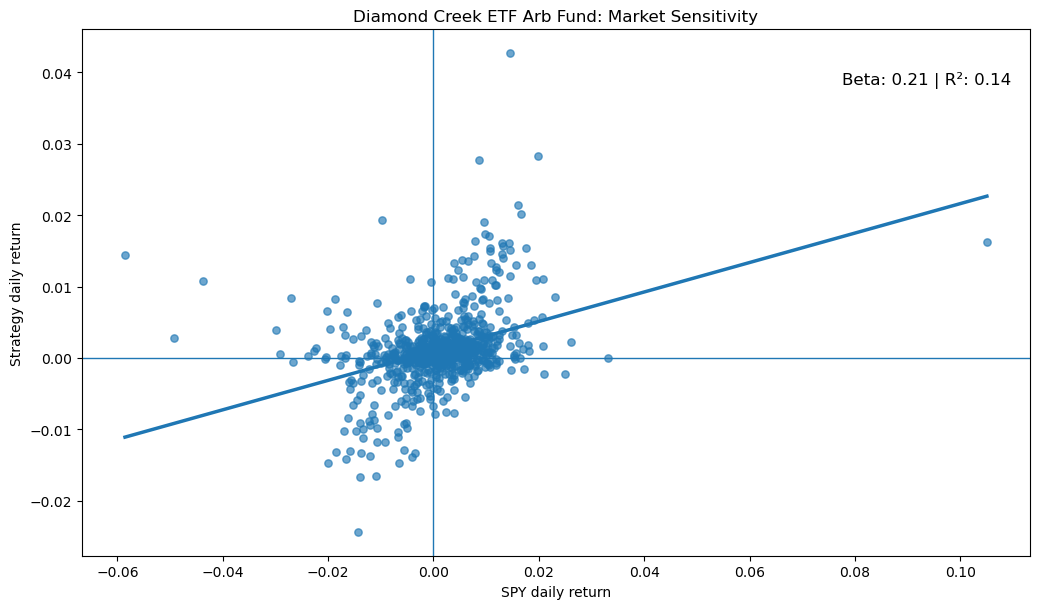

{'beta': 0.2063277395275817, 'r2': 0.1361817998913677, 'n_obs': 756}


In [99]:
# ============================================
# Scatter: Strategy daily returns vs SPY daily returns
# + regression line
# + show Beta and R^2 on chart
# (matches the style of your example image)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

TRADING_DAYS = 252

def plot_spy_scatter_with_beta_r2(port_ret: pd.Series, start: str | None = None, title: str = "Diamond Creek ETF Arb Fund: Market Sensitivity"):
    """
    port_ret: daily strategy returns (pd.Series indexed by date)
    start: optional YYYY-MM-DD to trim the plot/regression window
    """
    # --- load SPY daily returns aligned to port_ret dates (uses your helper)
    y = port_ret.replace([np.inf, -np.inf], np.nan).dropna()
    if start is not None:
        y = y.loc[pd.Timestamp(start):]
    y = _to_date_index(y)

    spy = load_adjclose_returns("SPY", start=str(y.index.min().date()))
    spy = _to_date_index(spy)

    df = pd.concat([spy.rename("SPY"), y.rename("STRAT")], axis=1).dropna()
    if len(df) < 50:
        raise ValueError(f"Not enough overlapping observations: {len(df)}")

    X = df[["SPY"]].to_numpy()
    Y = df["STRAT"].to_numpy()

    lr = LinearRegression(fit_intercept=True)
    lr.fit(X, Y)

    beta = float(lr.coef_[0])
    r2 = float(lr.score(X, Y))

    # --- line for plotting
    x_line = np.linspace(df["SPY"].min(), df["SPY"].max(), 200).reshape(-1, 1)
    y_line = lr.predict(x_line)

    # --- plot (style matches screenshot: points, fit line, crosshairs)
    plt.figure(figsize=(10.5, 6.2))
    plt.scatter(df["SPY"], df["STRAT"], alpha=0.65, s=28)
    plt.plot(x_line.flatten(), y_line, linewidth=2.5)

    plt.axhline(0, linewidth=1)
    plt.axvline(0, linewidth=1)

    plt.title(title)
    plt.xlabel("SPY daily return")
    plt.ylabel("Strategy daily return")

    # place text in upper-right like your image
    plt.text(
        0.98, 0.92,
        f"Beta: {beta:.2f} | R²: {r2:.2f}",
        transform=plt.gca().transAxes,
        ha="right", va="top",
        fontsize=12
    )

    plt.tight_layout()
    plt.show()

    return {"beta": beta, "r2": r2, "n_obs": len(df)}

# ============================================
# Example usage (plug in your port_ret from the loop)
# ============================================
#port_ret, meta, diag_cc, diag_lev = run_portfolio_returns_for_config(...)
stats = plot_spy_scatter_with_beta_r2(port_ret, start="2023-01-01",
                                     title="Diamond Creek ETF Arb Fund: Market Sensitivity")
print(stats)


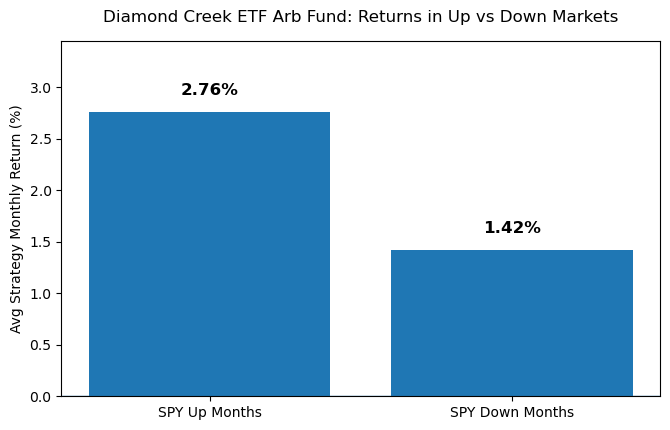

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_up_down_markets(
    port_ret: pd.Series,
    spy_ret: pd.Series,
    title: str = "Diamond Creek ETF Arb Fund: Returns in Up vs Down Markets",
    savepath: str | None = None,
):
    port_ret = port_ret.replace([np.inf, -np.inf], np.nan).dropna()
    spy_ret  = spy_ret.replace([np.inf, -np.inf], np.nan).dropna()

    port_ret.index = pd.to_datetime(port_ret.index).tz_localize(None)
    spy_ret.index  = pd.to_datetime(spy_ret.index).tz_localize(None)

    df = pd.concat([port_ret.rename("PORT"), spy_ret.rename("SPY")], axis=1).dropna()

    m = (1.0 + df).resample("M").prod() - 1.0
    m = m.dropna()

    up_mask = m["SPY"] > 0
    down_mask = m["SPY"] <= 0

    avg_up = m.loc[up_mask, "PORT"].mean() * 100
    avg_down = m.loc[down_mask, "PORT"].mean() * 100

    counts = [int(up_mask.sum()), int(down_mask.sum())]
    labels = ["SPY Up Months", "SPY Down Months"]
    values = [avg_up, avg_down]

    # --- plot ---
    fig, ax = plt.subplots(figsize=(6.8, 4.4))
    bars = ax.bar(labels, values)

    ax.set_title(title, pad=14)  # move title up a bit
    ax.set_ylabel("Avg Strategy Monthly Return (%)")
    ax.axhline(0, linewidth=1)
    ax.grid(False)

    # --- reserve headroom so labels NEVER hit the title ---
    vmax = max(values) if len(values) else 0
    ax.set_ylim(0, vmax * 1.25)  # <-- the key fix (25% headroom)

    # offsets as a fraction of y-range (scales nicely)
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    off_pct = 0.04 * yr   # percent label offset
    off_n   = 0.015 * yr  # n label offset

    for bar, val, n in zip(bars, values, counts):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()

        ax.text(
            x, y + off_pct,
            f"{val:.2f}%",
            ha="center", va="bottom",
            fontsize=12, fontweight="semibold"
        )


    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()


spy_ret = load_adjclose_returns(
    "SPY",
    start=str(port_ret.index.min().date())
)

plot_up_down_markets(
    port_ret,
    spy_ret,
    savepath="returns_up_vs_down.png"
)


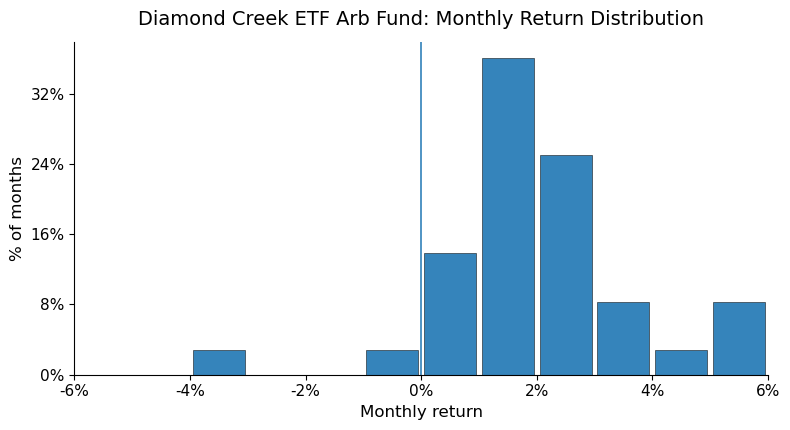

{'n_months': 38, 'mean_monthly': 0.023257675904041396, 'median_monthly': 0.019278238539153114, 'pct_positive_months': 0.9473684210526315, 'worst_month': -0.031427377436092474, 'best_month': 0.09115331050986186}


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

def plot_monthly_return_distribution_clean(
    port_ret_daily: pd.Series,
    title: str = "Diamond Creek ETF Arb Fund: Monthly Return Distribution",
    bin_width: float = 0.01,        # 1% buckets
    xlim: float = 0.06,             # show +/-6% only (clean & concise)
    show_mean: bool = False,
    savepath: str | None = None,
):
    # --- clean daily returns ---
    r = port_ret_daily.replace([np.inf, -np.inf], np.nan).dropna()
    r.index = pd.to_datetime(r.index).tz_localize(None)

    # --- monthly compounded returns ---
    monthly = (1.0 + r).resample("M").prod() - 1.0
    monthly = monthly.dropna()

    # --- clip ONLY for display ---
    monthly_plot = monthly[np.abs(monthly) <= xlim]

    # --- bins ---
    bins = np.arange(-xlim, xlim + bin_width, bin_width)
    counts, edges = np.histogram(monthly_plot, bins=bins)
    pct = counts / counts.sum() * 100
    centers = 0.5 * (edges[:-1] + edges[1:])

    # --- formatters ---
    pct_fmt = FuncFormatter(lambda y, _: f"{y:.0f}%")
    ret_fmt = FuncFormatter(lambda x, _: f"{100*x:.0f}%")

    # --- plot ---
    fig, ax = plt.subplots(figsize=(8.0, 4.4))

    ax.bar(
        centers,
        pct,
        width=bin_width * 0.9,
        edgecolor="black",
        linewidth=0.4,
        alpha=0.9
    )

    # zero line
    ax.axvline(0, linewidth=1.1)

    # optional mean
    if show_mean:
        ax.axvline(monthly.mean(), linestyle="--", linewidth=1)

    # labels
    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xlabel("Monthly return", fontsize=12)
    ax.set_ylabel("% of months", fontsize=12)

    # axis formatting
    ax.set_xlim(-xlim, xlim)
    ax.xaxis.set_major_formatter(ret_fmt)
    ax.yaxis.set_major_formatter(pct_fmt)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax.tick_params(axis="both", labelsize=11)

    # clean frame
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)

    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()

    return {
        "n_months": int(len(monthly)),
        "mean_monthly": float(monthly.mean()),
        "median_monthly": float(monthly.median()),
        "pct_positive_months": float((monthly > 0).mean()),
        "worst_month": float(monthly.min()),
        "best_month": float(monthly.max()),
    }

stats = plot_monthly_return_distribution_clean(
    port_ret,
    bin_width=0.01,   # 1% buckets
    xlim=0.06,        # +/-6% keeps it tight and honest
    savepath="monthly_return_distribution.png"
)
print(stats)


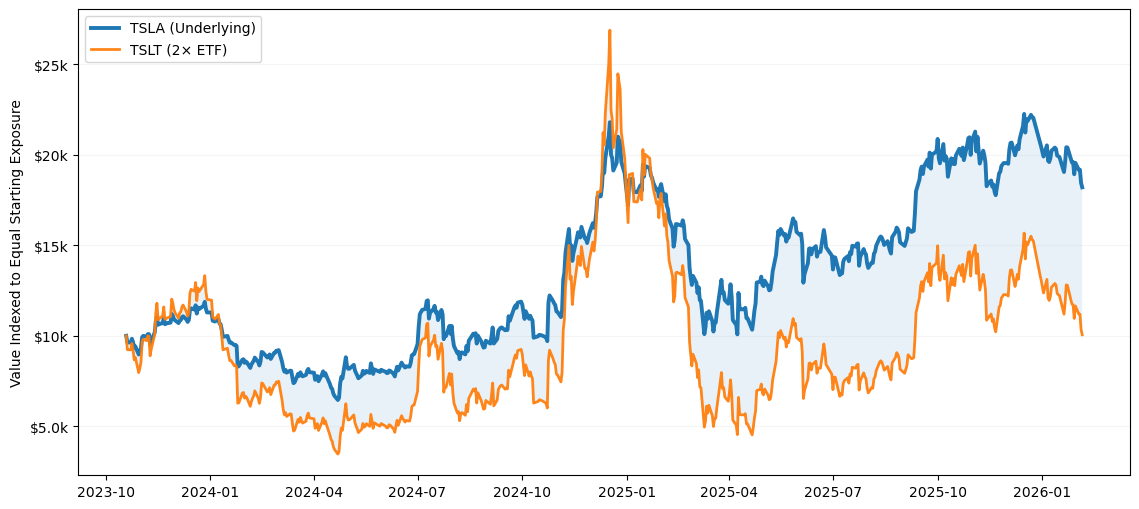

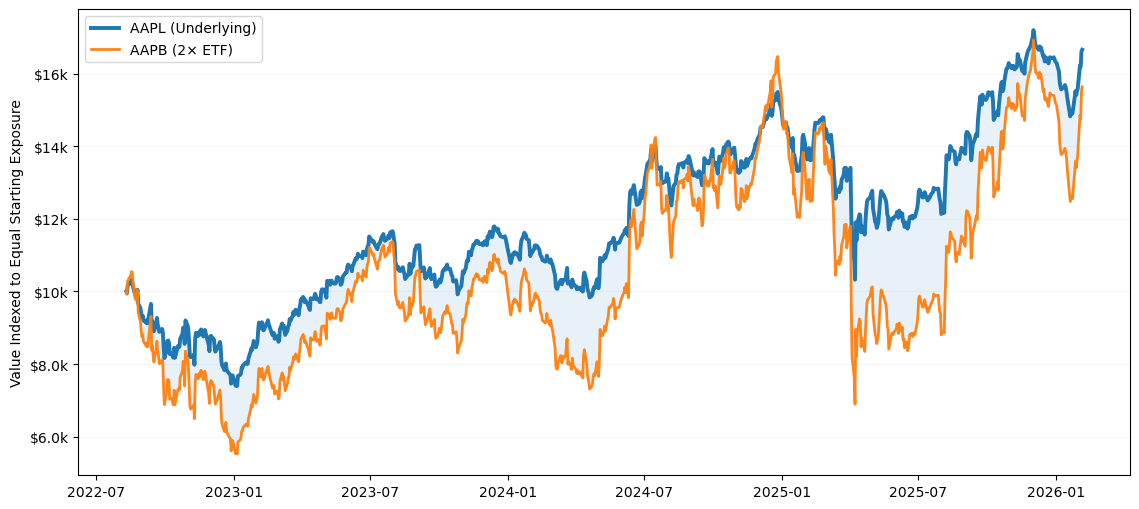

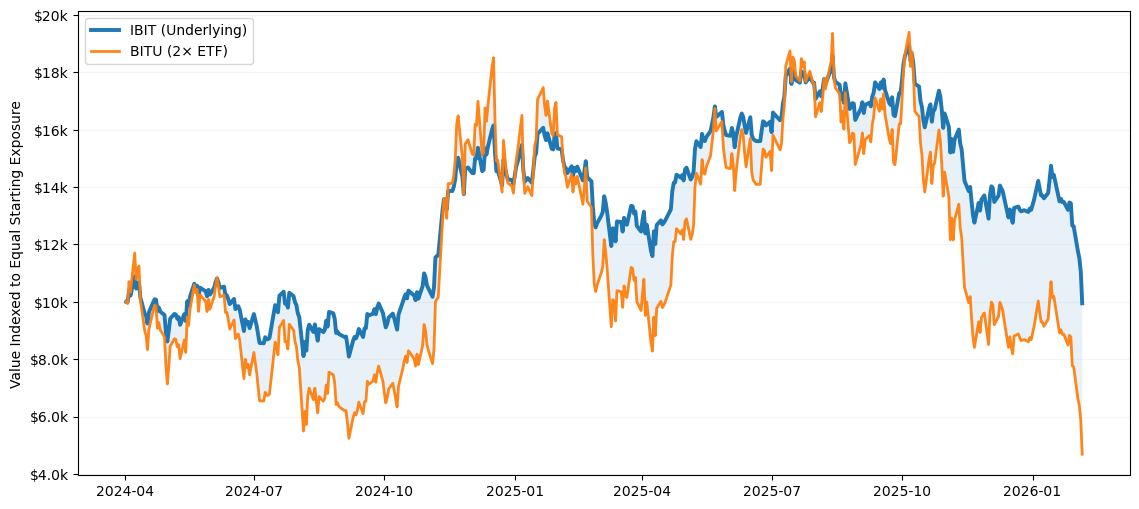

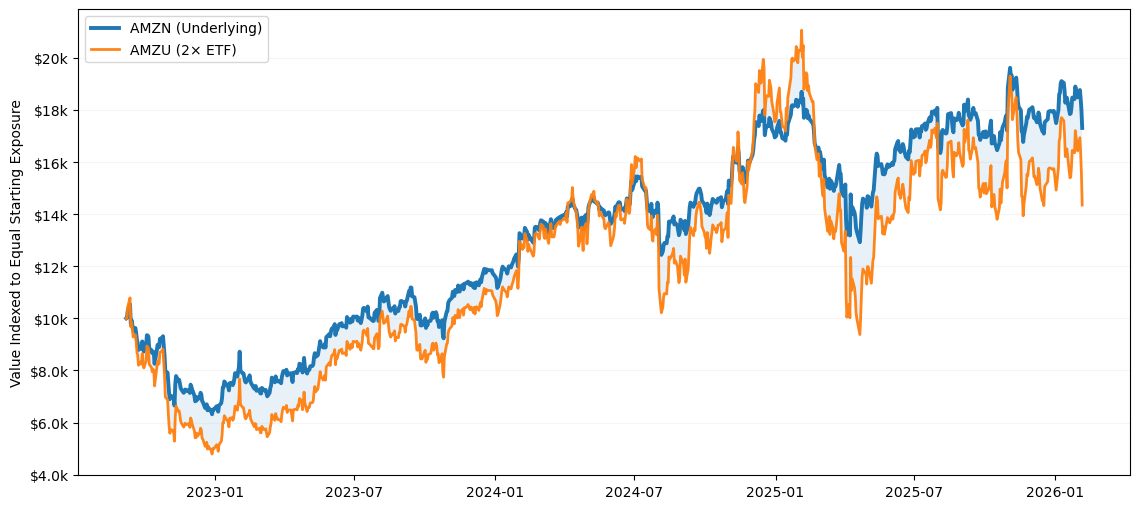

        pair      start        end  end_under_$10k  end_lev_$10k  end_diff_$  max_diff_$   min_diff_$
TSLA vs TSLT 2023-10-19 2026-02-05    18201.916946  10055.729529 8146.187418 8146.187418 -5081.173030
AAPL vs AAPB 2022-08-10 2026-02-05    16656.490695  15633.391607 1023.099088 3427.256270  -978.453455
IBIT vs BITU 2024-04-02 2026-02-05     9946.809320   4686.414604 5260.394717 5260.394717 -2362.690465
AMZN vs AMZU 2022-09-07 2026-02-05    17307.693350  14349.224183 2958.469167 3544.731257 -2364.852560


In [93]:
# LP-READY CHART (SINGLE AXIS): Growth of $10,000 with shaded divergence
# - One axis only (no dollar gap axis)
# - Underlying emphasized, ETF de-emphasized
# - Shaded area between lines shows divergence intuitively
# - Minimal grid, simple legend, no title/footnote by default

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def fetch_adj_close(tickers, start="2020-01-01", end=None) -> pd.DataFrame:
    px = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=False,
        progress=False,
        threads=True,
        group_by="ticker",
    )

    if isinstance(tickers, str) or len(tickers) == 1:
        t = tickers if isinstance(tickers, str) else tickers[0]
        if "Adj Close" not in px.columns:
            raise ValueError(f"No 'Adj Close' for {t}.")
        return px[["Adj Close"]].rename(columns={"Adj Close": t})

    if "Adj Close" in px.columns.get_level_values(0):
        out = px["Adj Close"].copy()
    elif "Adj Close" in px.columns.get_level_values(-1):
        out = px.xs("Adj Close", axis=1, level=-1)
    else:
        raise ValueError("Could not find 'Adj Close' in downloaded data.")
    return out


def _dollar_formatter(x, pos):
    # compact dollar formatter (k for thousands)
    sign = "-" if x < 0 else ""
    x = abs(x)
    if x >= 1_000_000:
        return f"{sign}${x/1_000_000:.1f}m"
    if x >= 1000:
        return f"{sign}${x/1000:.0f}k" if x >= 10000 else f"{sign}${x/1000:.1f}k"
    return f"{sign}${x:.0f}"


def plot_lp_ready_single_axis(
    under: str,
    lev: str,
    start="2020-01-01",
    end=None,
    initial_investment=10_000,
    under_label=None,
    lev_label=None,
    shade_alpha=0.10,
    show_title=False,
):
    under_label = under_label or f"{under} (Underlying)"
    lev_label   = lev_label   or f"{lev} (2× ETF)"

    adj = fetch_adj_close([under, lev], start=start, end=end)[[under, lev]].dropna()
    if len(adj) < 30:
        print(f"[WARN] Not enough overlap data for {under} vs {lev}.")
        return None

    under_val = initial_investment * (adj[under] / adj[under].iloc[0])
    lev_val   = initial_investment * (adj[lev]   / adj[lev].iloc[0])

    fig, ax = plt.subplots(figsize=(11.5, 5.2))

    # Minimal grid (y-only)
    ax.grid(axis="y", alpha=0.12)
    ax.grid(axis="x", alpha=0.0)

    # Lines: underlying dominant, ETF slightly lighter
    ax.plot(under_val.index, under_val.values, linewidth=2.8, label=under_label)
    ax.plot(lev_val.index,   lev_val.values,   linewidth=2.0, alpha=0.95, label=lev_label)

    # Shaded divergence area
    ax.fill_between(
        under_val.index,
        under_val.values,
        lev_val.values,
        alpha=shade_alpha,
        linewidth=0
    )

    ax.set_ylabel("Value Indexed to Equal Starting Exposure")
    ax.yaxis.set_major_formatter(FuncFormatter(_dollar_formatter))

    # Clean legend
    ax.legend(loc="upper left", frameon=True)

    if show_title:
        ax.set_title(f"{under} vs {lev}")

    plt.tight_layout()
    plt.show()

    return {
        "pair": f"{under} vs {lev}",
        "start": str(adj.index[0].date()),
        "end": str(adj.index[-1].date()),
        "end_under_$10k": float(under_val.iloc[-1]),
        "end_lev_$10k": float(lev_val.iloc[-1]),
        "end_diff_$": float((under_val - lev_val).iloc[-1]),
        "max_diff_$": float((under_val - lev_val).max()),
        "min_diff_$": float((under_val - lev_val).min()),
    }


# --- Run set ---
pairs = [
    ("TSLA", "TSLT"),
    ("AAPL", "AAPB"),
    ("IBIT", "BITU"),
    ("AMZN", "AMZU"),
]

summaries = []
for u, l in pairs:
    s = plot_lp_ready_single_axis(u, l, start="2020-01-01", initial_investment=10_000)
    if s:
        summaries.append(s)

if summaries:
    print(pd.DataFrame(summaries).to_string(index=False))


In [ ]:
import re
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

NASDAQ_LISTED_URL = "https://www.nasdaqtrader.com/dynamic/symdir/nasdaqlisted.txt"
OTHER_LISTED_URL  = "https://www.nasdaqtrader.com/dynamic/symdir/otherlisted.txt"

def _read_nasdaq_pipe_file(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, sep="|", dtype=str)
    # last row is a file timestamp; drop it
    df = df[~df.iloc[:, 0].astype(str).str.contains("File Creation Time", na=False)].copy()
    return df

def load_all_us_symbols() -> pd.DataFrame:
    n = _read_nasdaq_pipe_file(NASDAQ_LISTED_URL)
    o = _read_nasdaq_pipe_file(OTHER_LISTED_URL)

    # Normalize columns
    n = n.rename(columns={"Symbol": "ticker", "Security Name": "name", "ETF": "is_etf"})
    o = o.rename(columns={"ACT Symbol": "ticker", "Security Name": "name", "ETF": "is_etf"})

    keep_cols = ["ticker", "name", "is_etf"]
    df = pd.concat([n[keep_cols], o[keep_cols]], ignore_index=True)
    df["ticker"] = df["ticker"].str.strip()
    df["name"]   = df["name"].str.strip()
    df["is_etf"] = df["is_etf"].str.strip()
    df = df.dropna(subset=["ticker", "name", "is_etf"]).drop_duplicates(subset=["ticker"])
    return df

# Conservative name-based filter: you can tighten/loosen this
LEV_PATTERNS = [
    r"\b2x\b", r"\b3x\b", r"\b-2x\b", r"\b-3x\b",
    r"\bull\b", r"\bbear\b",
    r"\bultra\b", r"\bultrapro\b",
    r"\binverse\b", r"\bleveraged\b",
    r"\bdaily\b",
    r"\bshort\b",  # catches "short" ETFs (be careful: can include non-levered)
]

# Exclusions to reduce false positives (optional)
EXCLUDE_PATTERNS = [
    r"\bultra short\b",   # can be duration, not leverage
    r"\bultrashort\b",
    r"\bshort[- ]term\b", # duration
]

def is_leveraged_name(name: str) -> bool:
    s = name.lower()
    if any(re.search(p, s) for p in EXCLUDE_PATTERNS):
        return False
    return any(re.search(p, s) for p in LEV_PATTERNS)

def infer_first_trade_date(ticker: str) -> pd.Timestamp | None:
    try:
        h = yf.download(ticker, period="max", auto_adjust=False, progress=False)
        if h is None or h.empty:
            return None
        return pd.to_datetime(h.index[0]).tz_localize(None)
    except Exception:
        return None

def build_leveraged_universe(max_tickers: int | None = None) -> pd.DataFrame:
    df = load_all_us_symbols()

    # ETFs only
    df = df[df["is_etf"].eq("Y")].copy()

    # Leveraged/inverse by name
    df["is_leveraged_guess"] = df["name"].apply(is_leveraged_name)
    df = df[df["is_leveraged_guess"]].copy()

    # Optional: cap for quick testing
    if max_tickers is not None:
        df = df.head(max_tickers).copy()

    # First-trade date proxy via yfinance
    first_dates = []
    for t in df["ticker"]:
        first_dates.append(infer_first_trade_date(t))

    df["first_price_date"] = first_dates
    df = df.dropna(subset=["first_price_date"]).copy()
    df["first_price_date"] = pd.to_datetime(df["first_price_date"])
    return df

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

def plot_leveraged_count_over_time(df: pd.DataFrame, freq: str = "M"):
    # freq: "M" monthly, "Q" quarterly

    launched = (
        df.assign(period=df["first_price_date"].dt.to_period(freq).dt.to_timestamp())
          .groupby("period")["ticker"].nunique()
          .sort_index()
    )

    outstanding = launched.cumsum()

    fig, ax = plt.subplots(figsize=(11, 4.6))

    # Main line
    ax.plot(
        outstanding.index,
        outstanding.values,
        linewidth=2.8
    )

    # --- Axes labels (clean, PPT-friendly) ---
    ax.set_ylabel("Number of Leveraged & Inverse ETFs", fontsize=11)
    ax.set_xlabel("")

    # --- X-axis formatting (sparse, readable) ---
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)

    # --- Y-axis formatting (integers only) ---
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

    # --- Grid (LP style) ---
    ax.grid(axis="y", alpha=0.18, linewidth=1.0)
    ax.grid(axis="x", alpha=0.0)

    # --- Clean spines ---
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # --- Margins for right-edge breathing room ---
    ax.margins(x=0.03)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        "launched": launched,
        "outstanding": outstanding
    })

# ---- RUN ----
lev = build_leveraged_universe()  # optionally: build_leveraged_universe(max_tickers=300)


: 

: 

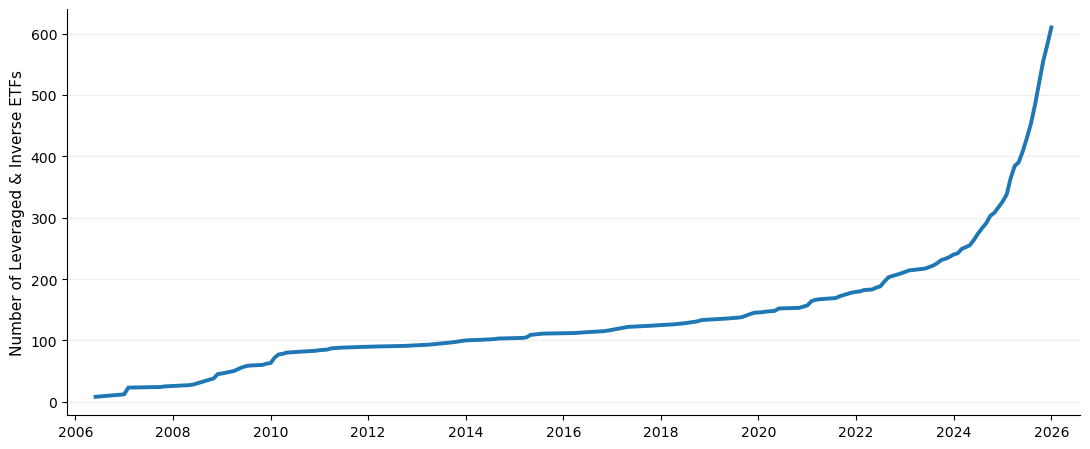

launched  outstanding
period                           
2006-06-01         8            8
2007-01-01         4           12
2007-02-01        11           23
2007-10-01         1           24
2007-11-01         1           25
...              ...          ...
2025-09-01        31          484
2025-10-01        35          519
2025-11-01        36          555
2025-12-01        26          581
2026-01-01        29          610

[117 rows x 2 columns]

: 

: 

In [ ]:
plot_leveraged_count_over_time(lev)

In [ ]:
import re
import time
import random
import pandas as pd
import requests
from bs4 import BeautifulSoup

ETF_CAGR_PATH = "../config/etf_cagr.csv"
OUT_EXPENSE_CSV = "etf_expense_ratios_2x.csv"
OUT_SUMMARY_CSV = "expense_ratio_summary_2x.csv"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; ExpenseRatioBot/1.0; +https://example.com)"
}

def parse_percent_to_float(s: str):
    """
    Convert strings like '0.95%' -> 0.0095
    Return None if cannot parse.
    """
    if not isinstance(s, str):
        return None
    m = re.search(r"([-+]?\d+(\.\d+)?)\s*%", s)
    if not m:
        return None
    return float(m.group(1)) / 100.0

def fetch_etfdb_expense_ratio(ticker: str):
    """
    Scrape expense ratio from ETFdb ETF page:
      https://etfdb.com/etf/{TICKER}/
    Returns (expense_ratio_float, raw_text, url) or (None, None, url) on failure.
    """
    url = f"https://etfdb.com/etf/{ticker}/"
    try:
        r = requests.get(url, headers=HEADERS, timeout=20)
        if r.status_code != 200:
            return None, None, url

        soup = BeautifulSoup(r.text, "html.parser")

        # ETFdb typically shows "Expense Ratio" in the "Vitals" / "Basics" section.
        # We'll find the label text and grab the adjacent value.
        label = soup.find(string=re.compile(r"\bExpense Ratio\b", re.I))
        if not label:
            return None, None, url

        # Walk up to a container row and find the value.
        # This is intentionally a bit flexible to survive minor HTML changes.
        container = label.find_parent()
        # Search nearby for a percent
        text_window = container.get_text(" ", strip=True)
        # Sometimes label container doesn't include value; expand to parent
        if "%" not in text_window:
            parent = container.find_parent()
            if parent:
                text_window = parent.get_text(" ", strip=True)

        # Find first percent in that window
        m = re.search(r"([-+]?\d+(\.\d+)?)\s*%", text_window)
        if not m:
            return None, None, url

        raw = m.group(0)
        val = parse_percent_to_float(raw)
        return val, raw, url

    except Exception:
        return None, None, url

def main():
    etf_cagr = pd.read_csv(ETF_CAGR_PATH)

    # You said: "only read ETFs and corresponding underlyings classified as 2x"
    df_2x = etf_cagr[etf_cagr["LevType"].astype(str).str.lower().eq("2x")].copy()
    tickers = sorted(df_2x["ETF"].astype(str).str.upper().unique())

    rows = []
    for i, tkr in enumerate(tickers, 1):
        val, raw, url = fetch_etfdb_expense_ratio(tkr)

        rows.append({
            "ticker": tkr,
            "expense_ratio": val,          # decimal (e.g. 0.0095)
            "expense_ratio_raw": raw,      # string (e.g. '0.95%')
            "source_url": url,
            "ok": val is not None
        })

        # polite throttle to avoid getting blocked
        time.sleep(0.6 + random.random() * 0.7)

        if i % 25 == 0:
            print(f"Scraped {i}/{len(tickers)}...")

    out = pd.DataFrame(rows)
    out.to_csv(OUT_EXPENSE_CSV, index=False)

    # ----- compute the averages you want -----
    # Long side: corresponding underlyings (stocks) => 0 expense ratio by definition
    # Short side: the 2x ETFs => average of scraped expense ratios
    short_avg = out.loc[out["ok"], "expense_ratio"].mean()

    summary = pd.DataFrame([{
        "n_2x_etfs_total": len(out),
        "n_2x_etfs_with_expense_ratio": int(out["ok"].sum()),
        "avg_expense_ratio_short_2x_etfs": short_avg,
        "avg_expense_ratio_long_underlyings": 0.0,
        "fee_differential_short_minus_long": (short_avg - 0.0) if short_avg is not None else None
    }])
    summary.to_csv(OUT_SUMMARY_CSV, index=False)

    print("\nSaved:")
    print(f" - {OUT_EXPENSE_CSV}")
    print(f" - {OUT_SUMMARY_CSV}")
    print("\nSummary:")
    print(summary.to_string(index=False))

if __name__ == "__main__":
    main()


Scraped 25/236...
Scraped 50/236...
Scraped 75/236...
Scraped 100/236...
Scraped 125/236...
Scraped 150/236...
Scraped 175/236...
Scraped 200/236...
Scraped 225/236...

Saved:
 - etf_expense_ratios_2x.csv
 - expense_ratio_summary_2x.csv

Summary:
 n_2x_etfs_total  n_2x_etfs_with_expense_ratio  avg_expense_ratio_short_2x_etfs  avg_expense_ratio_long_underlyings  fee_differential_short_minus_long
             236                           228                         0.011108                                 0.0                           0.011108


: 

: 

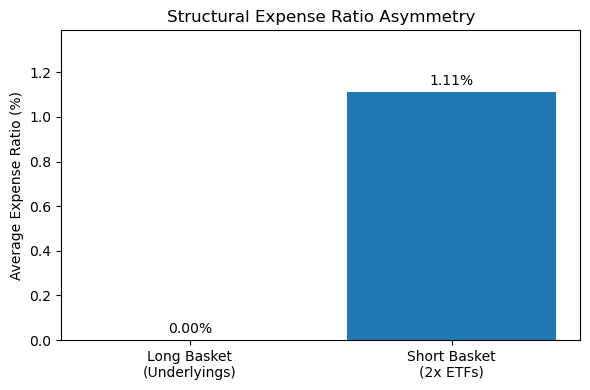

: 

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Load expense ratio data (2x ETFs)
# -------------------------------------------------
df = pd.read_csv("etf_expense_ratios_2x.csv")

# Keep only successfully scraped rows
df = df[df["ok"] == True].copy()

# -------------------------------------------------
# Compute averages
# -------------------------------------------------
short_avg = df["expense_ratio"].mean()      # decimal (e.g. 0.0111)
long_avg = 0.0                              # underlyings assumed 0%

# Convert to percentages for display
values = [long_avg * 100, short_avg * 100]
labels = [
    "Long Basket\n(Underlyings)",
    "Short Basket\n(2x ETFs)"
]

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values)

plt.ylabel("Average Expense Ratio (%)")
plt.title("Structural Expense Ratio Asymmetry")

# Annotate values above bars
for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.2f}%",
        ha="center",
        va="bottom"
    )

# Clean, LP-friendly formatting
plt.ylim(0, max(values) * 1.25)
plt.tight_layout()

plt.show()


: 

: 